In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from os import walk
import tarfile
import os
import time

from lcdb import *

from tqdm.notebook import tqdm

# Compute Learning Curves

In [2]:
def get_meta_features(openmlid):
    
    # load dataset object
    dataset = openml.datasets.get_dataset(openmlid)
    
    # analyze columns of data
    if False:
        dfDataset = dataset.get_data()[0]
        types = dfDataset.dtypes
        cnt_normalized = 0
        cnt_zero_mean = 0
        cnt_one_std = 0
        cnt_numerical = 0
        for i, col in enumerate(dfDataset.columns):
            if "float" in str(types[i]):
                cnt_numerical += 1
                vals = dfDataset[col].values
                is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
                is_zero_mean = np.round(np.mean(vals), 3) == 0
                is_one_std = np.round(np.std(vals), 3) == 1
                if is_normalized:
                    cnt_normalized += 1
                if is_zero_mean:
                    cnt_zero_mean += 1
                if is_one_std:
                    cnt_one_std += 1
        if cnt_numerical > 0:
            feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
        else:
            feature_stats_entries = 3 * ["n/a"]
    
    
    num_instances = int(dataset.qualities["NumberOfInstances"])
    num_features = len(dataset.features) - 1
    num_features_numeric = int(dataset.qualities["NumberOfNumericFeatures"])
    num_classes = int(dataset.qualities["NumberOfClasses"])
    missing_values = int(dataset.qualities["PercentageOfMissingValues"])
    
    return [openmlid, dataset.name[:20].replace("_", "\\_"), num_instances, num_features, num_features_numeric, num_classes, missing_values]


In [3]:
def get_dataframes(folder, filename, metrics = ["accuracy", "f1", "logloss", "auc"]):
    
    print(f"Extracting {folder}/{filename}")
    my_tar = tarfile.open(folder + "/" + file)
    my_tar.extractall(folder) # specify which folder to extract to
    my_tar.close()
    
    csv_filename = filename[:-7] + ".csv"
    
    batch_size = 10
    rows = {m: [] for m in metrics}
    
    print(f"Preparing dataframe for file {filename}.")
    for offset_index in range(60):
        
        offset = offset_index * batch_size + 1
        
        print(f"Reading lines {offset} to {offset + batch_size - 1}.")
        df = pd.read_csv(folder + "/" + csv_filename, delimiter=";", skiprows=lambda x: not(x == 0 or x in range(offset, offset + batch_size)))
        print(f"Finished. Read dataframe with {len(df)} lines. Now parsing the rows.")
        
        if len(df) == 0:
            break
        
        pbar = tqdm(total=len(df))
        for i, row in df.iterrows():
            try:
                print("Getting curves")
                start = time.time()
                curves = { metric: get_curve_for_metric_as_dataframe(json.loads(row["result"]), metric) for metric in metrics }
                print(f"Ready after {time.time() - start}s")
                prefix = list(row[["openmlid", "learner"]])
                for metric in metrics:
                    for j, compiled_row in curves[metric].iterrows():
                        rows[metric].append(prefix + list(compiled_row))
            except:
                print(f"Ignoring seed setup {row['outer_seed']}/{row['inner_seed_index']} dataset {row['openmlid']} and learner {row['learner']} because of an error.")
                #raise
            pbar.update(1)
        pbar.close()

    os.remove(folder + "/" + csv_filename)
            
    print("Done")
    return tuple([pd.DataFrame(rows[m], columns=["openmlid", "learner", 'size_train', 'size_test', 'outer_seed', 'inner_seed', 'traintime', 'score_train', 'score_valid', 'score_test']).astype({a: int for a in ["size_train", "size_test", "outer_seed", "inner_seed"]}) for m in metrics])

In [4]:


folder = "database-original"
filenames = next(walk(folder), (None, None, []))[2]
filenames = [f for f in filenames if f[-7:] == ".tar.gz"]

df_curves = {m: pd.read_csv("lcdb_" + m + ".csv") for m in ["accuracy", "f1", "logloss", "auc"]}
rows_metadata = []

for file in tqdm(filenames[170:]):
    
    openmlid = int(file[file.index("-") + 1:file.index(".")])
    
    if openmlid in [1591]:
        continue
    
    print(f"Getting meta-features of {openmlid}")
    meta_data = get_meta_features(openmlid)#lcdb.compute_meta_data_of_dataset(openmlid)
    #rows_metadata.append(meta_data)
    num_classes = meta_data[-2]
    
    if np.count_nonzero(df_curves["accuracy"]["openmlid"] == openmlid) > 0:
        print(f"skipping {openmlid}")
        continue
    
    print(f"Done, now computing curves for {openmlid}")
    if num_classes > 2:
        df_accuracy, df_logloss = get_dataframes(folder, file, metrics=["accuracy", "logloss"])
        df_list = [df_accuracy, None, df_logloss, None]
    else:
        df_list = list(get_dataframes(folder, file, metrics=["accuracy", "f1", "logloss", "auc"]))
    
    
    for m, df_new in zip(["accuracy", "f1", "logloss", "auc"], df_list):
        df_curves[m] = df_new if df_curves[m] is None else pd.concat([df_curves[m], df_new])
        df_curves[m].to_csv("lcdb_" + m + ".csv", index = False)
#df_meta = pd.DataFrame(rows_metadata, columns=["openmlid", "name"] + lcdb.get_names_of_meta_features() + ["AttributesAfterBinarization"])

  0%|          | 0/79 [00:00<?, ?it/s]

Getting meta-features of 4135
skipping 4135
Getting meta-features of 40978
skipping 40978
Getting meta-features of 971
skipping 971
Getting meta-features of 727
skipping 727
Getting meta-features of 396
skipping 396
Getting meta-features of 1461
skipping 1461
Getting meta-features of 41228
skipping 41228
Getting meta-features of 977
skipping 977
Getting meta-features of 40983
skipping 40983
Getting meta-features of 1138
skipping 1138
Getting meta-features of 881
skipping 881
Getting meta-features of 399
skipping 399
Getting meta-features of 1042
skipping 1042
Getting meta-features of 41144
skipping 41144
Getting meta-features of 1597
skipping 1597
Getting meta-features of 1509
skipping 1509
Getting meta-features of 1485
skipping 1485
Getting meta-features of 723
skipping 723
Getting meta-features of 1019
skipping 1019
Getting meta-features of 40685
skipping 40685
Getting meta-features of 930
skipping 930
Getting meta-features of 42742
skipping 42742
Getting meta-features of 40910
skipp

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 261.05985045433044s
Getting curves
Ready after 262.681941986084s
Getting curves
Ready after 268.50247073173523s
Getting curves
Ready after 269.9199299812317s
Getting curves
Ready after 270.9090428352356s
Getting curves
Ready after 2.8894166946411133s
Getting curves
Ready after 2.8659448623657227s
Getting curves
Ready after 2.8780739307403564s
Getting curves
Ready after 2.8518288135528564s
Getting curves
Ready after 2.8640964031219482s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.691718101501465s
Getting curves
Ready after 2.7052674293518066s
Getting curves
Ready after 2.7133677005767822s
Getting curves
Ready after 2.737710952758789s
Getting curves
Ready after 2.7298386096954346s
Getting curves
Ready after 5.908845901489258s
Getting curves
Ready after 5.918743133544922s
Getting curves
Ready after 5.906139612197876s
Getting curves
Ready after 4.637022972106934s
Getting curves
Ready after 5.895453929901123s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.016184091567993164s
Getting curves
Ready after 0.007028341293334961s
Getting curves
Ready after 0.007996559143066406s
Getting curves
Ready after 0.007730960845947266s
Getting curves
Ready after 0.007832527160644531s
Getting curves
Ready after 0.007736682891845703s
Getting curves
Ready after 0.0078008174896240234s
Getting curves
Ready after 0.007950782775878906s
Getting curves
Ready after 0.007757902145385742s
Getting curves
Ready after 0.008667945861816406s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ready after 82.92676258087158s
Getting curves
Ready after 81.21378993988037s
Getting curves
Ready after 86.14514231681824s
Getting curves
Ready after 93.0644645690918s
Getting curves
Ready after 87.04242944717407s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ready after 329.09269070625305s
Getting curves
Ready after 288.2682898044586s
Getting curves
Ready after 281.34065866470337s
Getting curves
Ready after 286.6133418083191s
Getting curves
Ready after 280.7092032432556s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 300.49148440361023s
Getting curves
Ready after 284.233647108078s
Getting curves
Ready after 267.4105522632599s
Getting curves
Ready after 268.11805391311646s
Getting curves
Ready after 269.1899960041046s
Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.linear_model.RidgeClassifier because of an error.
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 262.56291127204895s
Getting curves
Ready after 263.44059658050537s
Getting curves
Ready after 276.19018959999084s
Getting curves
Ready after 276.3158655166626s
Getting curves
Ready after 273.57752799987793s
Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Igno

  0%|          | 0/5 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 42732 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 42732 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 42732 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 42732 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 42732 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Reading lines 91 to 100.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 41159
Done, now computing curves for 41159
Extracting database-original/lcdb-41159.tar.gz
Preparing dataframe for file lcdb-41159.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.819147825241089s
Getting curves
Ready after 2.8343310356140137s
Getting curves
Ready after 2.847369432449341s
Getting curves
Ready after 2.852602005004883s
Getting curves
Ready after 2.8440093994140625s
Getting curves
Ready after 1.1352922916412354s
Getting curves
Ready after 1.1442251205444336s
Getting curves
Ready after 1.065234899520874s
Getting curves
Ready after 1.1291429996490479s
Getting curves
Ready after 1.1322221755981445s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5834798812866211s
Getting curves
Ready after 0.5741171836853027s
Getting curves
Ready after 0.9142372608184814s
Getting curves
Ready after 0.5730917453765869s
Getting curves
Ready after 0.9172749519348145s
Getting curves
Ready after 1.1349353790283203s
Getting curves
Ready after 1.1337921619415283s
Getting curves
Ready after 1.133291482925415s
Getting curves
Ready after 1.1337382793426514s
Getting curves
Ready after 1.1381292343139648s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.702367782592773s
Getting curves
Ready after 5.056612491607666s
Getting curves
Ready after 5.045441389083862s
Getting curves
Ready after 5.06467342376709s
Getting curves
Ready after 5.016250848770142s
Getting curves
Ready after 4.988710641860962s
Getting curves
Ready after 4.849480628967285s
Getting curves
Ready after 4.933051586151123s
Getting curves
Ready after 5.010420322418213s
Getting curves
Ready after 4.755384206771851s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 6.239362478256226s
Getting curves
Ready after 5.02350378036499s
Getting curves
Ready after 5.030825614929199s
Getting curves
Ready after 4.964786052703857s
Getting curves
Ready after 4.991654396057129s
Getting curves
Ready after 1.7487268447875977s
Getting curves
Ready after 1.6985845565795898s
Getting curves
Ready after 1.7769780158996582s
Getting curves
Ready after 1.694901704788208s
Getting curves
Ready after 1.7666051387786865s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.033736944198608s
Getting curves
Ready after 4.939244508743286s
Getting curves
Ready after 4.950692415237427s
Getting curves
Ready after 5.073339223861694s
Getting curves
Ready after 4.8784825801849365s
Getting curves
Ready after 4.999119758605957s
Getting curves
Ready after 5.0126402378082275s
Getting curves
Ready after 4.869530916213989s
Getting curves
Ready after 5.003354549407959s
Getting curves
Ready after 5.000207424163818s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.9818270206451416s
Getting curves
Ready after 2.978097677230835s
Getting curves
Ready after 2.9692602157592773s
Getting curves
Ready after 2.7956271171569824s
Getting curves
Ready after 2.7512052059173584s
Getting curves
Ready after 2.772646188735962s
Getting curves
Ready after 2.7887604236602783s
Getting curves
Ready after 2.8319060802459717s
Getting curves
Ready after 2.843905448913574s
Getting curves
Ready after 2.8460116386413574s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.8874781131744385s
Getting curves
Ready after 2.8549704551696777s
Getting curves
Ready after 2.8640336990356445s
Getting curves
Ready after 2.846747398376465s
Getting curves
Ready after 2.856389045715332s
Getting curves
Ready after 2.8575150966644287s
Getting curves
Ready after 2.8517963886260986s
Getting curves
Ready after 2.8455746173858643s
Getting curves
Ready after 2.8556900024414062s
Getting curves
Ready after 2.850416421890259s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.023344993591309s
Getting curves
Ready after 4.858105182647705s
Getting curves
Ready after 4.944838762283325s
Getting curves
Ready after 4.844543695449829s
Getting curves
Ready after 4.836400270462036s
Getting curves
Ready after 0.014266252517700195s
Getting curves
Ready after 0.006364583969116211s
Getting curves
Ready after 0.006394147872924805s
Getting curves
Ready after 0.0061910152435302734s
Getting curves
Ready after 0.00640416145324707s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.825676441192627s
Getting curves
Ready after 4.730447053909302s
Getting curves
Ready after 4.936084985733032s
Getting curves
Ready after 5.002983808517456s
Getting curves
Ready after 4.697311162948608s
Getting curves
Ready after 3.7492382526397705s
Getting curves
Ready after 3.761418104171753s
Getting curves
Ready after 3.8400821685791016s
Getting curves
Ready after 3.4642014503479004s
Getting curves
Ready after 3.8603878021240234s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.007917642593384s
Getting curves
Ready after 4.687820911407471s
Getting curves
Ready after 4.96099328994751s
Getting curves
Ready after 4.790134906768799s
Getting curves
Ready after 4.947986602783203s
Getting curves
Ready after 4.813918590545654s
Getting curves
Ready after 4.938744783401489s
Getting curves
Ready after 4.95824122428894s
Getting curves
Ready after 4.8667519092559814s
Getting curves
Ready after 4.942785978317261s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 833
Done, now computing curves for 833
Extracting database-original/lcdb-833.tar.gz
Preparing dataframe for file lcdb-833.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4124395847320557s
Getting curves
Ready after 1.408501148223877s
Getting curves
Ready after 1.4128108024597168s
Getting curves
Ready after 1.4178483486175537s
Getting curves
Ready after 1.4267516136169434s
Getting curves
Ready after 1.4236762523651123s
Getting curves
Ready after 1.4266469478607178s
Getting curves
Ready after 1.4325265884399414s
Getting curves
Ready after 1.4304661750793457s
Getting curves
Ready after 1.4513120651245117s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4630942344665527s
Getting curves
Ready after 1.4515583515167236s
Getting curves
Ready after 1.4531450271606445s
Getting curves
Ready after 1.4448552131652832s
Getting curves
Ready after 1.441575288772583s
Getting curves
Ready after 1.4361374378204346s
Getting curves
Ready after 1.4439024925231934s
Getting curves
Ready after 1.441112756729126s
Getting curves
Ready after 1.4482202529907227s
Getting curves
Ready after 1.4384047985076904s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4661495685577393s
Getting curves
Ready after 2.428576707839966s
Getting curves
Ready after 2.374661684036255s
Getting curves
Ready after 2.2892937660217285s
Getting curves
Ready after 2.2906816005706787s
Getting curves
Ready after 2.2909343242645264s
Getting curves
Ready after 2.3255364894866943s
Getting curves
Ready after 2.332131862640381s
Getting curves
Ready after 2.2950351238250732s
Getting curves
Ready after 2.2825448513031006s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.2931346893310547s
Getting curves
Ready after 2.329881191253662s
Getting curves
Ready after 2.34405517578125s
Getting curves
Ready after 2.3329415321350098s
Getting curves
Ready after 2.3241467475891113s
Getting curves
Ready after 2.3476009368896484s
Getting curves
Ready after 2.3368818759918213s
Getting curves
Ready after 2.340606689453125s
Getting curves
Ready after 2.3559372425079346s
Getting curves
Ready after 2.3645105361938477s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.354055643081665s
Getting curves
Ready after 2.3676741123199463s
Getting curves
Ready after 2.3886632919311523s
Getting curves
Ready after 2.4016599655151367s
Getting curves
Ready after 2.400421142578125s
Getting curves
Ready after 2.347750186920166s
Getting curves
Ready after 2.355772018432617s
Getting curves
Ready after 2.3273515701293945s
Getting curves
Ready after 2.358513116836548s
Getting curves
Ready after 2.3948798179626465s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4182941913604736s
Getting curves
Ready after 1.4261054992675781s
Getting curves
Ready after 1.430952548980713s
Getting curves
Ready after 1.4376249313354492s
Getting curves
Ready after 1.4516944885253906s
Getting curves
Ready after 1.4519615173339844s
Getting curves
Ready after 1.4570252895355225s
Getting curves
Ready after 1.4567837715148926s
Getting curves
Ready after 1.4574220180511475s
Getting curves
Ready after 1.4537792205810547s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4549658298492432s
Getting curves
Ready after 1.4598870277404785s
Getting curves
Ready after 1.4493870735168457s
Getting curves
Ready after 1.4565246105194092s
Getting curves
Ready after 1.454369306564331s
Getting curves
Ready after 1.447507619857788s
Getting curves
Ready after 1.4556446075439453s
Getting curves
Ready after 1.4530303478240967s
Getting curves
Ready after 1.4602556228637695s
Getting curves
Ready after 1.4537804126739502s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4330687522888184s
Getting curves
Ready after 2.4196128845214844s
Getting curves
Ready after 2.450336456298828s
Getting curves
Ready after 2.5072994232177734s
Getting curves
Ready after 2.4982967376708984s
Getting curves
Ready after 0.007442474365234375s
Getting curves
Ready after 0.007414579391479492s
Getting curves
Ready after 0.007358074188232422s
Getting curves
Ready after 0.00735020637512207s
Getting curves
Ready after 0.007379055023193359s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4957938194274902s
Getting curves
Ready after 2.3405089378356934s
Getting curves
Ready after 2.4564719200134277s
Getting curves
Ready after 2.357795476913452s
Getting curves
Ready after 2.3165695667266846s
Getting curves
Ready after 2.356907844543457s
Getting curves
Ready after 2.3634579181671143s
Getting curves
Ready after 2.3739030361175537s
Getting curves
Ready after 2.3583335876464844s
Getting curves
Ready after 2.3730664253234863s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.380117893218994s
Getting curves
Ready after 2.452270269393921s
Getting curves
Ready after 2.3555331230163574s
Getting curves
Ready after 2.4615135192871094s
Getting curves
Ready after 2.465411901473999s
Getting curves
Ready after 2.4529685974121094s
Getting curves
Ready after 2.3586223125457764s
Getting curves
Ready after 2.4448678493499756s
Getting curves
Ready after 2.3098843097686768s
Getting curves
Ready after 2.395254611968994s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1041
Done, now computing curves for 1041
Extracting database-original/lcdb-1041.tar.gz
Preparing dataframe for file lcdb-1041.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.34210824966430664s
Getting curves
Ready after 0.3363497257232666s
Getting curves
Ready after 0.34089016914367676s
Getting curves
Ready after 0.3369417190551758s
Getting curves
Ready after 0.3366665840148926s
Getting curves
Ready after 0.33696532249450684s
Getting curves
Ready after 0.33724045753479004s
Getting curves
Ready after 0.33644533157348633s
Getting curves
Ready after 0.3392460346221924s
Getting curves
Ready after 0.33638715744018555s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.37097978591918945s
Getting curves
Ready after 0.3227369785308838s
Getting curves
Ready after 0.32657575607299805s
Getting curves
Ready after 0.3253359794616699s
Getting curves
Ready after 0.32360148429870605s
Getting curves
Ready after 0.32503533363342285s
Getting curves
Ready after 0.3278384208679199s
Getting curves
Ready after 0.32507753372192383s
Getting curves
Ready after 0.3256685733795166s
Getting curves
Ready after 0.32564663887023926s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.7380578517913818s
Getting curves
Ready after 0.673283576965332s
Getting curves
Ready after 0.6625070571899414s
Getting curves
Ready after 0.6668367385864258s
Getting curves
Ready after 0.7122139930725098s
Getting curves
Ready after 0.607813835144043s
Getting curves
Ready after 0.6193106174468994s
Getting curves
Ready after 0.6163513660430908s
Getting curves
Ready after 0.609652042388916s
Getting curves
Ready after 0.6146860122680664s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.7138075828552246s
Getting curves
Ready after 0.6790971755981445s
Getting curves
Ready after 0.6731753349304199s
Getting curves
Ready after 0.6654891967773438s
Getting curves
Ready after 0.7355670928955078s
Getting curves
Ready after 0.6703875064849854s
Getting curves
Ready after 0.6707684993743896s
Getting curves
Ready after 0.6591689586639404s
Getting curves
Ready after 0.7260801792144775s
Getting curves
Ready after 0.6740858554840088s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6889317035675049s
Getting curves
Ready after 0.663424015045166s
Getting curves
Ready after 0.6569643020629883s
Getting curves
Ready after 0.7348611354827881s
Getting curves
Ready after 0.6703445911407471s
Getting curves
Ready after 0.6724834442138672s
Getting curves
Ready after 0.663933515548706s
Getting curves
Ready after 0.7229840755462646s
Getting curves
Ready after 0.6715826988220215s
Getting curves
Ready after 0.6675386428833008s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.35188961029052734s
Getting curves
Ready after 0.3248152732849121s
Getting curves
Ready after 0.3327014446258545s
Getting curves
Ready after 0.32577085494995117s
Getting curves
Ready after 0.33242368698120117s
Getting curves
Ready after 0.3392658233642578s
Getting curves
Ready after 0.3269972801208496s
Getting curves
Ready after 0.3280975818634033s
Getting curves
Ready after 0.32877492904663086s
Getting curves
Ready after 0.34240007400512695s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3395423889160156s
Getting curves
Ready after 0.32581210136413574s
Getting curves
Ready after 0.32372188568115234s
Getting curves
Ready after 0.33283019065856934s
Getting curves
Ready after 0.38587260246276855s
Getting curves
Ready after 0.33915162086486816s
Getting curves
Ready after 0.32457470893859863s
Getting curves
Ready after 0.32625532150268555s
Getting curves
Ready after 0.32883238792419434s
Getting curves
Ready after 0.329486608505249s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6900014877319336s
Getting curves
Ready after 0.6726589202880859s
Getting curves
Ready after 0.6664595603942871s
Getting curves
Ready after 0.7161402702331543s
Getting curves
Ready after 0.6716675758361816s
Getting curves
Ready after 0.6722507476806641s
Getting curves
Ready after 0.6623806953430176s
Getting curves
Ready after 0.6399731636047363s
Getting curves
Ready after 0.7049925327301025s
Getting curves
Ready after 0.6433258056640625s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6460220813751221s
Getting curves
Ready after 0.6289291381835938s
Getting curves
Ready after 0.7022340297698975s
Getting curves
Ready after 0.6494102478027344s
Getting curves
Ready after 0.642369270324707s
Getting curves
Ready after 0.6409623622894287s
Getting curves
Ready after 0.6283745765686035s
Getting curves
Ready after 0.7076547145843506s
Getting curves
Ready after 0.6460006237030029s
Getting curves
Ready after 0.6448345184326172s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.643918514251709s
Getting curves
Ready after 0.7227845191955566s
Getting curves
Ready after 0.6532018184661865s
Getting curves
Ready after 0.6480791568756104s
Getting curves
Ready after 0.6489481925964355s
Getting curves
Ready after 0.7068395614624023s
Getting curves
Ready after 0.6589534282684326s
Getting curves
Ready after 0.6493921279907227s
Getting curves
Ready after 0.6391267776489258s
Getting curves
Ready after 0.6380972862243652s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 40981
Done, now computing curves for 40981
Extracting database-original/lcdb-40981.tar.gz
Preparing dataframe for file lcdb-40981.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.433272123336792s
Getting curves
Ready after 0.4450387954711914s
Getting curves
Ready after 0.47682738304138184s
Getting curves
Ready after 0.4327666759490967s
Getting curves
Ready after 0.4259920120239258s
Getting curves
Ready after 0.42069149017333984s
Getting curves
Ready after 0.4314417839050293s
Getting curves
Ready after 0.42195749282836914s
Getting curves
Ready after 0.43390774726867676s
Getting curves
Ready after 0.41974401473999023s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.44416069984436035s
Getting curves
Ready after 0.4251723289489746s
Getting curves
Ready after 0.42708706855773926s
Getting curves
Ready after 0.42684507369995117s
Getting curves
Ready after 0.42290306091308594s
Getting curves
Ready after 0.4372401237487793s
Getting curves
Ready after 0.4233405590057373s
Getting curves
Ready after 0.4290344715118408s
Getting curves
Ready after 0.4243624210357666s
Getting curves
Ready after 0.426297664642334s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5422933101654053s
Getting curves
Ready after 0.5284698009490967s
Getting curves
Ready after 0.5259668827056885s
Getting curves
Ready after 0.525256872177124s
Getting curves
Ready after 0.5252354145050049s
Getting curves
Ready after 0.4675912857055664s
Getting curves
Ready after 0.5189228057861328s
Getting curves
Ready after 0.5186386108398438s
Getting curves
Ready after 0.528221845626831s
Getting curves
Ready after 0.5190215110778809s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5382838249206543s
Getting curves
Ready after 0.521064281463623s
Getting curves
Ready after 0.5266897678375244s
Getting curves
Ready after 0.4635276794433594s
Getting curves
Ready after 0.5247392654418945s
Getting curves
Ready after 0.5226113796234131s
Getting curves
Ready after 0.5259735584259033s
Getting curves
Ready after 0.5207009315490723s
Getting curves
Ready after 0.5308442115783691s
Getting curves
Ready after 0.5260145664215088s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5393617153167725s
Getting curves
Ready after 0.525963544845581s
Getting curves
Ready after 0.461167573928833s
Getting curves
Ready after 0.5268557071685791s
Getting curves
Ready after 0.5152156352996826s
Getting curves
Ready after 0.5360279083251953s
Getting curves
Ready after 0.5210392475128174s
Getting curves
Ready after 0.5247805118560791s
Getting curves
Ready after 0.5247948169708252s
Getting curves
Ready after 0.5334668159484863s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.43509721755981445s
Getting curves
Ready after 0.42056894302368164s
Getting curves
Ready after 0.4189622402191162s
Getting curves
Ready after 0.42295408248901367s
Getting curves
Ready after 0.418287992477417s
Getting curves
Ready after 0.4274413585662842s
Getting curves
Ready after 0.41674304008483887s
Getting curves
Ready after 0.4183840751647949s
Getting curves
Ready after 0.41976332664489746s
Getting curves
Ready after 0.41948604583740234s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.43937015533447266s
Getting curves
Ready after 0.42055749893188477s
Getting curves
Ready after 0.42607545852661133s
Getting curves
Ready after 0.42192983627319336s
Getting curves
Ready after 0.43053674697875977s
Getting curves
Ready after 0.41884374618530273s
Getting curves
Ready after 0.4176061153411865s
Getting curves
Ready after 0.4282248020172119s
Getting curves
Ready after 0.4245586395263672s
Getting curves
Ready after 0.43040943145751953s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5543181896209717s
Getting curves
Ready after 0.5353841781616211s
Getting curves
Ready after 0.5316345691680908s
Getting curves
Ready after 0.5258369445800781s
Getting curves
Ready after 0.46346497535705566s
Getting curves
Ready after 0.5203087329864502s
Getting curves
Ready after 0.5298902988433838s
Getting curves
Ready after 0.5226809978485107s
Getting curves
Ready after 0.531806230545044s
Getting curves
Ready after 0.5318331718444824s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5408763885498047s
Getting curves
Ready after 0.5249865055084229s
Getting curves
Ready after 0.5287456512451172s
Getting curves
Ready after 0.4751453399658203s
Getting curves
Ready after 0.5245983600616455s
Getting curves
Ready after 0.5261754989624023s
Getting curves
Ready after 0.5259413719177246s
Getting curves
Ready after 0.5327649116516113s
Getting curves
Ready after 0.5267994403839111s
Getting curves
Ready after 0.5260045528411865s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5345876216888428s
Getting curves
Ready after 0.457714319229126s
Getting curves
Ready after 0.5148682594299316s
Getting curves
Ready after 0.5211288928985596s
Getting curves
Ready after 0.5190823078155518s
Getting curves
Ready after 0.5234317779541016s
Getting curves
Ready after 0.5215294361114502s
Getting curves
Ready after 0.5298750400543213s
Getting curves
Ready after 0.5161697864532471s
Getting curves
Ready after 0.529111385345459s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1053
Done, now computing curves for 1053
Extracting database-original/lcdb-1053.tar.gz
Preparing dataframe for file lcdb-1053.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.5443389415740967s
Getting curves
Ready after 2.5458545684814453s
Getting curves
Ready after 2.549489974975586s
Getting curves
Ready after 2.5437381267547607s
Getting curves
Ready after 2.6025054454803467s
Getting curves
Ready after 2.4902379512786865s
Getting curves
Ready after 2.5038554668426514s
Getting curves
Ready after 2.4959096908569336s
Getting curves
Ready after 2.5215513706207275s
Getting curves
Ready after 3.875443458557129s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4628987312316895s
Getting curves
Ready after 2.4662132263183594s
Getting curves
Ready after 2.4663305282592773s
Getting curves
Ready after 2.4772539138793945s
Getting curves
Ready after 2.4869823455810547s
Getting curves
Ready after 2.502357006072998s
Getting curves
Ready after 2.4877936840057373s
Getting curves
Ready after 2.503356456756592s
Getting curves
Ready after 2.4944188594818115s
Getting curves
Ready after 2.6506574153900146s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.060438632965088s
Getting curves
Ready after 4.067472696304321s
Getting curves
Ready after 4.054757833480835s
Getting curves
Ready after 4.0566322803497314s
Getting curves
Ready after 3.9361181259155273s
Getting curves
Ready after 4.034784317016602s
Getting curves
Ready after 3.9660420417785645s
Getting curves
Ready after 4.03724479675293s
Getting curves
Ready after 3.9477970600128174s
Getting curves
Ready after 3.953432321548462s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.032074213027954s
Getting curves
Ready after 5.3504273891448975s
Getting curves
Ready after 3.9851105213165283s
Getting curves
Ready after 3.91375994682312s
Getting curves
Ready after 3.966331720352173s
Getting curves
Ready after 3.9801464080810547s
Getting curves
Ready after 3.858476161956787s
Getting curves
Ready after 3.90634822845459s
Getting curves
Ready after 3.8583033084869385s
Getting curves
Ready after 3.763608932495117s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.0415027141571045s
Getting curves
Ready after 3.9596445560455322s
Getting curves
Ready after 4.120610475540161s
Getting curves
Ready after 3.9853858947753906s
Getting curves
Ready after 4.023057222366333s
Getting curves
Ready after 3.975168466567993s
Getting curves
Ready after 4.008352518081665s
Getting curves
Ready after 4.120256423950195s
Getting curves
Ready after 4.069106817245483s
Getting curves
Ready after 3.966190814971924s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4578680992126465s
Getting curves
Ready after 2.4727838039398193s
Getting curves
Ready after 2.4879202842712402s
Getting curves
Ready after 2.504335880279541s
Getting curves
Ready after 2.48698091506958s
Getting curves
Ready after 2.485499382019043s
Getting curves
Ready after 2.4943864345550537s
Getting curves
Ready after 2.482320547103882s
Getting curves
Ready after 2.475532054901123s
Getting curves
Ready after 2.469179153442383s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.4681997299194336s
Getting curves
Ready after 2.4557580947875977s
Getting curves
Ready after 2.4567480087280273s
Getting curves
Ready after 2.4414000511169434s
Getting curves
Ready after 2.4484920501708984s
Getting curves
Ready after 2.4580090045928955s
Getting curves
Ready after 3.8326218128204346s
Getting curves
Ready after 2.4258856773376465s
Getting curves
Ready after 2.446683883666992s
Getting curves
Ready after 2.459742546081543s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.137635231018066s
Getting curves
Ready after 4.064115762710571s
Getting curves
Ready after 4.024863958358765s
Getting curves
Ready after 4.045880317687988s
Getting curves
Ready after 4.038203001022339s
Getting curves
Ready after 3.993090867996216s
Getting curves
Ready after 3.9229085445404053s
Getting curves
Ready after 3.9814188480377197s
Getting curves
Ready after 4.048262357711792s
Getting curves
Ready after 3.999666213989258s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.9895856380462646s
Getting curves
Ready after 3.889383316040039s
Getting curves
Ready after 3.986079454421997s
Getting curves
Ready after 4.028305530548096s
Getting curves
Ready after 3.9809625148773193s
Getting curves
Ready after 4.097707033157349s
Getting curves
Ready after 4.02978777885437s
Getting curves
Ready after 3.93977689743042s
Getting curves
Ready after 4.123432159423828s
Getting curves
Ready after 4.090554475784302s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.053696870803833s
Getting curves
Ready after 4.025214195251465s
Getting curves
Ready after 4.01464056968689s
Getting curves
Ready after 4.1382896900177s
Getting curves
Ready after 4.044838905334473s
Getting curves
Ready after 4.077935457229614s
Getting curves
Ready after 4.137499094009399s
Getting curves
Ready after 4.025249242782593s
Getting curves
Ready after 4.119619131088257s
Getting curves
Ready after 4.0032548904418945s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 554
Done, now computing curves for 554
Extracting database-original/lcdb-554.tar.gz
Preparing dataframe for file lcdb-554.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.2146778106689453s
Getting curves
Ready after 3.2412023544311523s
Getting curves
Ready after 3.361466407775879s
Getting curves
Ready after 3.40626859664917s
Getting curves
Ready after 3.401996374130249s
Getting curves
Ready after 2.443603277206421s
Getting curves
Ready after 2.0542261600494385s
Getting curves
Ready after 2.4075865745544434s
Getting curves
Ready after 2.0528948307037354s
Getting curves
Ready after 2.351595640182495s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.3885834217071533s
Getting curves
Ready after 1.3648512363433838s
Getting curves
Ready after 1.3723032474517822s
Getting curves
Ready after 1.3662159442901611s
Getting curves
Ready after 1.3662586212158203s
Getting curves
Ready after 1.3721797466278076s
Getting curves
Ready after 1.3988189697265625s
Getting curves
Ready after 1.3720879554748535s
Getting curves
Ready after 1.3855137825012207s
Getting curves
Ready after 1.3758490085601807s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 10.633576154708862s
Getting curves
Ready after 9.667653322219849s
Getting curves
Ready after 9.800348043441772s
Getting curves
Ready after 9.888396978378296s
Getting curves
Ready after 10.045216083526611s
Getting curves
Ready after 9.082688093185425s
Getting curves
Ready after 9.167367458343506s
Getting curves
Ready after 9.39017105102539s
Getting curves
Ready after 9.17381763458252s
Getting curves
Ready after 9.001191854476929s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 10.73621392250061s
Getting curves
Ready after 10.53197693824768s
Getting curves
Ready after 10.727735042572021s
Getting curves
Ready after 10.56964921951294s
Getting curves
Ready after 11.543641328811646s
Getting curves
Ready after 1.7300806045532227s
Getting curves
Ready after 1.8683092594146729s
Getting curves
Ready after 1.8910038471221924s
Getting curves
Ready after 1.803426742553711s
Getting curves
Ready after 1.6756494045257568s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 10.70427393913269s
Getting curves
Ready after 10.549799919128418s
Getting curves
Ready after 10.559069156646729s
Getting curves
Ready after 11.709511995315552s
Getting curves
Ready after 10.287873983383179s
Getting curves
Ready after 10.193137645721436s
Getting curves
Ready after 11.865257501602173s
Getting curves
Ready after 10.332569599151611s
Getting curves
Ready after 10.251791715621948s
Getting curves
Ready after 10.537957191467285s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.688533306121826s
Getting curves
Ready after 3.638021230697632s
Getting curves
Ready after 3.6429388523101807s
Getting curves
Ready after 3.649848461151123s
Getting curves
Ready after 6.417387247085571s
Getting curves
Ready after 3.560328245162964s
Getting curves
Ready after 3.576516628265381s
Getting curves
Ready after 3.6165473461151123s
Getting curves
Ready after 3.6278369426727295s
Getting curves
Ready after 3.64282488822937s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.665381669998169s
Getting curves
Ready after 3.6365981101989746s
Getting curves
Ready after 3.645656108856201s
Getting curves
Ready after 3.606764316558838s
Getting curves
Ready after 3.6126530170440674s
Getting curves
Ready after 3.6010804176330566s
Getting curves
Ready after 3.6195228099823s
Getting curves
Ready after 3.6284995079040527s
Getting curves
Ready after 3.6182467937469482s
Getting curves
Ready after 3.6290438175201416s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 10.108597040176392s
Getting curves
Ready after 9.947010040283203s
Getting curves
Ready after 10.294906616210938s
Getting curves
Ready after 10.22715425491333s
Getting curves
Ready after 9.975087642669678s
Getting curves
Ready after 9.552003145217896s
Getting curves
Ready after 10.041723489761353s
Getting curves
Ready after 9.71994662284851s
Getting curves
Ready after 10.693978071212769s
Getting curves
Ready after 9.741827011108398s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.747632026672363s
Getting curves
Ready after 6.074270486831665s
Getting curves
Ready after 6.163036823272705s
Getting curves
Ready after 6.285924911499023s
Getting curves
Ready after 6.154923915863037s
Getting curves
Ready after 13.010830163955688s
Getting curves
Ready after 10.461406707763672s
Getting curves
Ready after 11.085882186889648s
Getting curves
Ready after 10.43216347694397s
Getting curves
Ready after 10.530058860778809s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 9.844812154769897s
Getting curves
Ready after 9.509766817092896s
Getting curves
Ready after 9.990732192993164s
Getting curves
Ready after 10.044121980667114s
Getting curves
Ready after 9.695040941238403s
Getting curves
Ready after 9.881792783737183s
Getting curves
Ready after 9.70998239517212s
Getting curves
Ready after 10.63217282295227s
Getting curves
Ready after 11.656990051269531s
Getting curves
Ready after 10.465593099594116s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 42769
Done, now computing curves for 42769
Extracting database-original/lcdb-42769.tar.gz
Preparing dataframe for file lcdb-42769.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 46.83896589279175s
Getting curves
Ready after 44.81845474243164s
Getting curves
Ready after 47.06571984291077s
Getting curves
Ready after 47.279699087142944s
Getting curves
Ready after 47.90206694602966s
Getting curves
Ready after 2.9844934940338135s
Getting curves
Ready after 2.9651072025299072s
Getting curves
Ready after 2.9513485431671143s
Getting curves
Ready after 2.9485960006713867s
Getting curves
Ready after 2.9548304080963135s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.933964252471924s
Getting curves
Ready after 2.939387083053589s
Getting curves
Ready after 2.9543943405151367s
Getting curves
Ready after 2.976890802383423s
Getting curves
Ready after 2.996359348297119s
Getting curves
Ready after 2.411707639694214s
Getting curves
Ready after 2.4043197631835938s
Getting curves
Ready after 2.4129579067230225s
Getting curves
Ready after 2.414118766784668s
Getting curves
Ready after 2.416426181793213s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 102.44834566116333s
Getting curves
Ignoring seed setup 1/0 dataset 42769 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ready after 99.46669101715088s
Getting curves
Ready after 99.56968665122986s
Getting curves
Ready after 100.1091365814209s
Getting curves
Ignoring seed setup 0/0 dataset 42769 and learner sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis because of an error.
Getting curves
Ready after 98.88083863258362s
Getting curves
Ready after 99.70726561546326s
Getting curves
Ready after 99.02221393585205s
Getting curves
Ready after 104.9221739768982s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 73.37119746208191s
Getting curves
Ready after 70.28126549720764s
Getting curves
Ready after 70.79750919342041s
Getting curves
Ready after 75.97786402702332s
Getting curves
Ready after 84.41567492485046s
Getting curves
Ready after 32.46501278877258s
Getting curves
Ready after 32.435142517089844s
Getting curves
Ready after 32.2967689037323s
Getting curves
Ready after 35.80422520637512s
Getting curves
Ready after 30.33188533782959s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 41.86484169960022s
Getting curves
Ready after 33.91149616241455s
Getting curves
Ready after 37.685505628585815s
Getting curves
Ready after 31.955463409423828s
Getting curves
Ready after 37.39014172554016s
Getting curves
Ignoring seed setup 0/0 dataset 42769 and learner sklearn.linear_model.LogisticRegression because of an error.
Getting curves
Ready after 99.46866917610168s
Getting curves
Ready after 99.1640214920044s
Getting curves
Ready after 98.88474535942078s
Getting curves
Ready after 99.08223414421082s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 65.0893006324768s
Getting curves
Ready after 68.30611395835876s
Getting curves
Ready after 67.92203187942505s
Getting curves
Ready after 63.6342933177948s
Getting curves
Ready after 63.96728801727295s
Getting curves
Ready after 64.07310080528259s
Getting curves
Ready after 63.794198989868164s
Getting curves
Ready after 64.22071838378906s
Getting curves
Ready after 63.90843844413757s
Getting curves
Ready after 64.23422122001648s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 69.11842322349548s
Getting curves
Ready after 69.76529312133789s
Getting curves
Ready after 69.36933517456055s
Getting curves
Ready after 68.36024713516235s
Getting curves
Ready after 69.09571194648743s
Getting curves
Ready after 69.43071413040161s
Getting curves
Ready after 65.59757113456726s
Getting curves
Ready after 65.18375444412231s
Getting curves
Ready after 65.14629769325256s
Getting curves
Ready after 65.35071969032288s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 98.83816170692444s
Getting curves
Ready after 100.4596471786499s
Getting curves
Ready after 105.60958337783813s
Getting curves
Ready after 98.79451417922974s
Getting curves
Ready after 97.57130718231201s
Getting curves
Ready after 0.016712427139282227s
Getting curves
Ready after 0.0072193145751953125s
Getting curves
Ready after 0.0071523189544677734s
Getting curves
Ready after 0.007162570953369141s
Getting curves
Ready after 0.007166862487792969s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 7.469796895980835s
Getting curves
Ready after 8.437837839126587s
Getting curves
Ready after 8.969018697738647s
Getting curves
Ready after 8.54798698425293s
Getting curves
Ready after 8.641909837722778s
Getting curves
Ready after 21.708414554595947s
Getting curves
Ready after 22.31880831718445s
Getting curves
Ready after 21.950928211212158s
Getting curves
Ready after 21.115447759628296s
Getting curves
Ready after 21.65553569793701s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 107.68076610565186s
Getting curves
Ready after 106.16660451889038s
Getting curves
Ready after 104.91898941993713s
Getting curves
Ready after 104.210031747818s
Getting curves
Ready after 103.3382956981659s
Getting curves
Ready after 106.85989809036255s
Getting curves
Ready after 103.43736433982849s
Getting curves
Ready after 103.13178944587708s
Getting curves
Ready after 104.6095552444458s
Getting curves
Ready after 104.47763800621033s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 734
Done, now computing curves for 734
Extracting database-original/lcdb-734.tar.gz
Preparing dataframe for file lcdb-734.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.3473293781280518s
Getting curves
Ready after 2.340224027633667s
Getting curves
Ready after 2.324221611022949s
Getting curves
Ready after 2.3113090991973877s
Getting curves
Ready after 2.316004753112793s
Getting curves
Ready after 2.261443614959717s
Getting curves
Ready after 2.2794301509857178s
Getting curves
Ready after 2.2720680236816406s
Getting curves
Ready after 2.275386095046997s
Getting curves
Ready after 2.259287118911743s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.294403076171875s
Getting curves
Ready after 2.277228593826294s
Getting curves
Ready after 2.274707555770874s
Getting curves
Ready after 2.2808101177215576s
Getting curves
Ready after 2.271688461303711s
Getting curves
Ready after 2.3084864616394043s
Getting curves
Ready after 2.3152124881744385s
Getting curves
Ready after 2.31099009513855s
Getting curves
Ready after 2.3071675300598145s
Getting curves
Ready after 2.310983419418335s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.28950047492981s
Getting curves
Ready after 4.127253532409668s
Getting curves
Ready after 4.160243272781372s
Getting curves
Ready after 4.205127239227295s
Getting curves
Ready after 4.145212888717651s
Getting curves
Ready after 4.081045150756836s
Getting curves
Ready after 4.114650249481201s
Getting curves
Ready after 4.085207223892212s
Getting curves
Ready after 4.029587984085083s
Getting curves
Ready after 4.205801010131836s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.052564382553101s
Getting curves
Ready after 4.254209280014038s
Getting curves
Ready after 4.112648963928223s
Getting curves
Ready after 4.17435884475708s
Getting curves
Ready after 4.160581350326538s
Getting curves
Ready after 4.191405534744263s
Getting curves
Ready after 4.138741970062256s
Getting curves
Ready after 4.1663689613342285s
Getting curves
Ready after 4.313777923583984s
Getting curves
Ready after 4.115580797195435s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.202784538269043s
Getting curves
Ready after 4.306352376937866s
Getting curves
Ready after 4.2455525398254395s
Getting curves
Ready after 4.012310266494751s
Getting curves
Ready after 4.156635284423828s
Getting curves
Ready after 4.193902015686035s
Getting curves
Ready after 4.169804334640503s
Getting curves
Ready after 4.161098957061768s
Getting curves
Ready after 4.16484522819519s
Getting curves
Ready after 4.189236879348755s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.3138628005981445s
Getting curves
Ready after 2.388490915298462s
Getting curves
Ready after 2.318544864654541s
Getting curves
Ready after 2.3215255737304688s
Getting curves
Ready after 2.3168249130249023s
Getting curves
Ready after 2.333075761795044s
Getting curves
Ready after 2.319756031036377s
Getting curves
Ready after 2.3285882472991943s
Getting curves
Ready after 2.317983388900757s
Getting curves
Ready after 2.33221697807312s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.3288087844848633s
Getting curves
Ready after 2.321441411972046s
Getting curves
Ready after 2.314723491668701s
Getting curves
Ready after 2.3259527683258057s
Getting curves
Ready after 2.318054437637329s
Getting curves
Ready after 2.339898109436035s
Getting curves
Ready after 2.31708025932312s
Getting curves
Ready after 2.3240394592285156s
Getting curves
Ready after 2.3151180744171143s
Getting curves
Ready after 2.323164463043213s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.469273805618286s
Getting curves
Ready after 4.133172273635864s
Getting curves
Ready after 4.09079909324646s
Getting curves
Ready after 4.16887354850769s
Getting curves
Ready after 4.255569219589233s
Getting curves
Ready after 0.0068132877349853516s
Getting curves
Ready after 0.006627798080444336s
Getting curves
Ready after 0.006738185882568359s
Getting curves
Ready after 0.0067288875579833984s
Getting curves
Ready after 0.006721019744873047s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.404056549072266s
Getting curves
Ready after 4.163140058517456s
Getting curves
Ready after 4.208329439163208s
Getting curves
Ready after 4.36073637008667s
Getting curves
Ready after 4.131881952285767s
Getting curves
Ready after 4.301490306854248s
Getting curves
Ready after 4.169186353683472s
Getting curves
Ready after 4.25321626663208s
Getting curves
Ready after 4.343744516372681s
Getting curves
Ready after 4.137759208679199s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.287001848220825s
Getting curves
Ready after 4.368729591369629s
Getting curves
Ready after 4.229096412658691s
Getting curves
Ready after 4.287097215652466s
Getting curves
Ready after 4.2776100635528564s
Getting curves
Ready after 4.221473217010498s
Getting curves
Ready after 4.1561243534088135s
Getting curves
Ready after 4.2617104053497314s
Getting curves
Ready after 4.237346172332764s
Getting curves
Ready after 4.310215473175049s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 6
Done, now computing curves for 6
Extracting database-original/lcdb-6.tar.gz
Preparing dataframe for file lcdb-6.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.6969921588897705s
Getting curves
Ready after 1.7396681308746338s
Getting curves
Ready after 1.7543933391571045s
Getting curves
Ready after 1.8545353412628174s
Getting curves
Ready after 1.832367181777954s
Getting curves
Ready after 1.8710811138153076s
Getting curves
Ready after 1.735004186630249s
Getting curves
Ready after 1.837981939315796s
Getting curves
Ready after 1.8667068481445312s
Getting curves
Ready after 1.865746021270752s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4643120765686035s
Getting curves
Ready after 1.4338231086730957s
Getting curves
Ready after 1.4535443782806396s
Getting curves
Ready after 1.4539527893066406s
Getting curves
Ready after 1.4494965076446533s
Getting curves
Ready after 1.6209495067596436s
Getting curves
Ready after 1.6273071765899658s
Getting curves
Ready after 1.6121821403503418s
Getting curves
Ready after 1.606757640838623s
Getting curves
Ready after 1.6064996719360352s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4917950630187988s
Getting curves
Ready after 1.463655948638916s
Getting curves
Ready after 1.4699344635009766s
Getting curves
Ready after 1.4667930603027344s
Getting curves
Ready after 1.4724326133728027s
Getting curves
Ready after 1.4730393886566162s
Getting curves
Ready after 1.4825024604797363s
Getting curves
Ready after 1.4792125225067139s
Getting curves
Ready after 1.4941480159759521s
Getting curves
Ready after 1.4827685356140137s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4492237567901611s
Getting curves
Ready after 1.458956241607666s
Getting curves
Ready after 1.4568085670471191s
Getting curves
Ready after 1.4713115692138672s
Getting curves
Ready after 1.4613895416259766s
Getting curves
Ready after 1.4663376808166504s
Getting curves
Ready after 1.475024938583374s
Getting curves
Ready after 1.4770383834838867s
Getting curves
Ready after 2.8622710704803467s
Getting curves
Ready after 1.4576265811920166s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.3454506397247314s
Getting curves
Ready after 1.3528831005096436s
Getting curves
Ready after 1.350691318511963s
Getting curves
Ready after 1.361603021621704s
Getting curves
Ready after 1.359490156173706s
Getting curves
Ready after 1.3727059364318848s
Getting curves
Ready after 1.3844828605651855s
Getting curves
Ready after 1.416851282119751s
Getting curves
Ready after 1.4058785438537598s
Getting curves
Ready after 1.4088706970214844s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4617857933044434s
Getting curves
Ready after 1.3398900032043457s
Getting curves
Ready after 1.3376216888427734s
Getting curves
Ready after 1.3465230464935303s
Getting curves
Ready after 1.3430190086364746s
Getting curves
Ready after 1.3524651527404785s
Getting curves
Ready after 1.368781328201294s
Getting curves
Ready after 1.4034640789031982s
Getting curves
Ready after 1.3949084281921387s
Getting curves
Ready after 1.4092152118682861s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.3306713104248047s
Getting curves
Ready after 1.3276679515838623s
Getting curves
Ready after 1.341243028640747s
Getting curves
Ready after 1.3421952724456787s
Getting curves
Ready after 1.340135097503662s
Getting curves
Ready after 1.3552298545837402s
Getting curves
Ready after 1.359832525253296s
Getting curves
Ready after 1.3703093528747559s
Getting curves
Ready after 1.3895854949951172s
Getting curves
Ready after 1.4000327587127686s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.3236641883850098s
Getting curves
Ready after 1.3343794345855713s
Getting curves
Ready after 1.33225417137146s
Getting curves
Ready after 1.3456950187683105s
Getting curves
Ready after 1.3382110595703125s
Getting curves
Ready after 1.3174209594726562s
Getting curves
Ready after 1.3212535381317139s
Getting curves
Ready after 1.4180951118469238s
Getting curves
Ready after 1.3891751766204834s
Getting curves
Ready after 1.3921983242034912s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.3008606433868408s
Getting curves
Ready after 1.3057169914245605s
Getting curves
Ready after 1.3217411041259766s
Getting curves
Ready after 1.3116145133972168s
Getting curves
Ready after 1.3153972625732422s
Getting curves
Ready after 1.3307013511657715s
Getting curves
Ready after 1.3447821140289307s
Getting curves
Ready after 1.3746569156646729s
Getting curves
Ready after 1.3662846088409424s
Getting curves
Ready after 1.586806297302246s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.8083901405334473s
Getting curves
Ready after 1.753460168838501s
Getting curves
Ready after 1.7547214031219482s
Getting curves
Ready after 1.6540155410766602s
Getting curves
Ready after 1.6921560764312744s
Getting curves
Ready after 1.7353160381317139s
Getting curves
Ready after 1.8907880783081055s
Getting curves
Ready after 1.720686912536621s
Getting curves
Ready after 1.6595664024353027s
Getting curves
Ready after 1.6786510944366455s
Reading lines 101 to 110.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 6.368842601776123s
Getting curves
Ready after 6.511979579925537s
Getting curves
Ready after 5.875698089599609s
Getting curves
Ready after 7.1873273849487305s
Getting curves
Ready after 6.1377363204956055s
Getting curves
Ready after 7.231722116470337s
Getting curves
Ready after 5.849589586257935s
Getting curves
Ready after 5.8426361083984375s
Getting curves
Ready after 5.766391038894653s
Getting curves
Ready after 8.812957525253296s
Reading lines 111 to 120.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.68831467628479s
Getting curves
Ready after 5.699380159378052s
Getting curves
Ready after 5.862907886505127s
Getting curves
Ready after 5.857940912246704s
Getting curves
Ready after 5.674059867858887s
Getting curves
Ready after 5.664031505584717s
Getting curves
Ready after 5.839963674545288s
Getting curves
Ready after 5.64582896232605s
Getting curves
Ready after 5.595471143722534s
Getting curves
Ready after 5.710169315338135s
Reading lines 121 to 130.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 6.4340550899505615s
Getting curves
Ready after 6.2240211963653564s
Getting curves
Ready after 5.882482051849365s
Getting curves
Ready after 6.253051519393921s
Getting curves
Ready after 5.69734263420105s
Getting curves
Ready after 4.371785879135132s
Getting curves
Ready after 4.5060341358184814s
Getting curves
Ready after 5.002210378646851s
Getting curves
Ready after 4.478522777557373s
Getting curves
Ready after 4.425702095031738s
Reading lines 131 to 140.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.690185785293579s
Getting curves
Ready after 4.835160255432129s
Getting curves
Ready after 5.30591607093811s
Getting curves
Ready after 5.089739561080933s
Getting curves
Ready after 4.613654613494873s
Getting curves
Ready after 5.083259344100952s
Getting curves
Ready after 4.643050670623779s
Getting curves
Ready after 4.721649169921875s
Getting curves
Ready after 4.568754434585571s
Getting curves
Ready after 4.381269454956055s
Reading lines 141 to 150.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 4.7095627784729s
Getting curves
Ready after 4.415162801742554s
Getting curves
Ready after 4.593900442123413s
Getting curves
Ready after 4.610459566116333s
Getting curves
Ready after 4.6841511726379395s
Getting curves
Ready after 4.661426782608032s
Getting curves
Ready after 4.522518634796143s
Getting curves
Ready after 4.772220134735107s
Getting curves
Ready after 4.867864608764648s
Getting curves
Ready after 4.89739727973938s
Reading lines 151 to 160.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.878431558609009s
Getting curves
Ready after 5.721391201019287s
Getting curves
Ready after 6.158595561981201s
Getting curves
Ready after 6.157066822052002s
Getting curves
Ready after 7.512809991836548s
Getting curves
Ready after 5.694670677185059s
Getting curves
Ready after 6.221389532089233s
Getting curves
Ready after 6.301612138748169s
Getting curves
Ready after 5.734029054641724s
Getting curves
Ready after 5.567151784896851s
Reading lines 161 to 170.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.345826864242554s
Getting curves
Ready after 5.283684253692627s
Getting curves
Ready after 5.389367341995239s
Getting curves
Ready after 5.353165626525879s
Getting curves
Ready after 5.374360799789429s
Getting curves
Ready after 5.4290173053741455s
Getting curves
Ready after 5.441787958145142s
Getting curves
Ready after 5.3033788204193115s
Getting curves
Ready after 5.413079261779785s
Getting curves
Ready after 5.325645685195923s
Reading lines 171 to 180.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.582660675048828s
Getting curves
Ready after 5.556501626968384s
Getting curves
Ready after 5.515558481216431s
Getting curves
Ready after 8.214268207550049s
Getting curves
Ready after 5.428555727005005s
Getting curves
Ready after 5.470900535583496s
Getting curves
Ready after 5.493661642074585s
Getting curves
Ready after 5.4159321784973145s
Getting curves
Ready after 5.486850738525391s
Getting curves
Ready after 5.44236946105957s
Reading lines 181 to 190.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.318907022476196s
Getting curves
Ready after 5.428380489349365s
Getting curves
Ready after 5.743072271347046s
Getting curves
Ready after 5.924777507781982s
Getting curves
Ready after 5.801175355911255s
Getting curves
Ready after 5.793028831481934s
Getting curves
Ready after 5.467862129211426s
Getting curves
Ready after 5.459566593170166s
Getting curves
Ready after 5.552257061004639s
Getting curves
Ready after 6.810149431228638s
Reading lines 191 to 200.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.25063419342041s
Getting curves
Ready after 5.456972360610962s
Getting curves
Ready after 5.433105945587158s
Getting curves
Ready after 5.448141098022461s
Getting curves
Ready after 5.499177694320679s
Getting curves
Ready after 5.663181304931641s
Getting curves
Ready after 5.61185884475708s
Getting curves
Ready after 5.3927161693573s
Getting curves
Ready after 5.448944091796875s
Getting curves
Ready after 5.393284797668457s
Reading lines 201 to 210.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.657018184661865s
Getting curves
Ready after 5.599884748458862s
Getting curves
Ready after 5.7092390060424805s
Getting curves
Ready after 5.609644651412964s
Getting curves
Ready after 5.549267530441284s
Getting curves
Ready after 5.582842588424683s
Getting curves
Ready after 5.693647146224976s
Getting curves
Ready after 5.677870988845825s
Getting curves
Ready after 5.684281826019287s
Getting curves
Ready after 5.617743730545044s
Reading lines 211 to 220.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.442543983459473s
Getting curves
Ready after 5.39137864112854s
Getting curves
Ready after 5.492039918899536s
Getting curves
Ready after 5.585432529449463s
Getting curves
Ready after 5.351034164428711s
Getting curves
Ready after 5.417319059371948s
Getting curves
Ready after 5.42657470703125s
Getting curves
Ready after 5.392656564712524s
Getting curves
Ready after 5.503270864486694s
Getting curves
Ready after 5.500529766082764s
Reading lines 221 to 230.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.355898857116699s
Getting curves
Ready after 5.351600170135498s
Getting curves
Ready after 5.522876501083374s
Getting curves
Ready after 5.412229061126709s
Getting curves
Ready after 5.575129747390747s
Getting curves
Ready after 5.3638787269592285s
Getting curves
Ready after 5.492222785949707s
Getting curves
Ready after 5.439073801040649s
Getting curves
Ready after 5.321566343307495s
Getting curves
Ready after 5.471545457839966s
Reading lines 231 to 240.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.613920211791992s
Getting curves
Ready after 5.832799196243286s
Getting curves
Ready after 5.531252145767212s
Getting curves
Ready after 5.631548166275024s
Getting curves
Ready after 5.666269302368164s
Getting curves
Ready after 5.661499977111816s
Getting curves
Ready after 5.611945152282715s
Getting curves
Ready after 7.024569749832153s
Getting curves
Ready after 5.678907632827759s
Getting curves
Ready after 5.656821012496948s
Reading lines 241 to 250.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.629795551300049s
Getting curves
Ready after 5.587681770324707s
Getting curves
Ready after 5.692725896835327s
Getting curves
Ready after 5.715445280075073s
Getting curves
Ready after 5.656840562820435s
Getting curves
Ready after 5.349971055984497s
Getting curves
Ready after 5.6222124099731445s
Getting curves
Ready after 5.376748561859131s
Getting curves
Ready after 5.609758138656616s
Getting curves
Ready after 5.292457580566406s
Reading lines 251 to 260.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5371224880218506s
Getting curves
Ready after 1.5200598239898682s
Getting curves
Ready after 1.5261576175689697s
Getting curves
Ready after 1.5364091396331787s
Getting curves
Ready after 1.538088321685791s
Getting curves
Ready after 1.5510554313659668s
Getting curves
Ready after 1.5600965023040771s
Getting curves
Ready after 1.5800127983093262s
Getting curves
Ready after 1.5781726837158203s
Getting curves
Ready after 1.4372036457061768s
Reading lines 261 to 270.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4796013832092285s
Getting curves
Ready after 1.4848825931549072s
Getting curves
Ready after 1.4812324047088623s
Getting curves
Ready after 1.5127716064453125s
Getting curves
Ready after 1.4883499145507812s
Getting curves
Ready after 1.4965996742248535s
Getting curves
Ready after 1.4943468570709229s
Getting curves
Ready after 1.4958198070526123s
Getting curves
Ready after 1.4888033866882324s
Getting curves
Ready after 1.4972584247589111s
Reading lines 271 to 280.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4059090614318848s
Getting curves
Ready after 1.4091978073120117s
Getting curves
Ready after 1.414604663848877s
Getting curves
Ready after 1.4205124378204346s
Getting curves
Ready after 1.4123201370239258s
Getting curves
Ready after 1.435547113418579s
Getting curves
Ready after 1.4434337615966797s
Getting curves
Ready after 1.4338979721069336s
Getting curves
Ready after 1.4498932361602783s
Getting curves
Ready after 1.4564688205718994s
Reading lines 281 to 290.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.490109920501709s
Getting curves
Ready after 1.4892909526824951s
Getting curves
Ready after 1.497851848602295s
Getting curves
Ready after 1.5026416778564453s
Getting curves
Ready after 1.504495620727539s
Getting curves
Ready after 1.5131831169128418s
Getting curves
Ready after 1.513319730758667s
Getting curves
Ready after 1.513915777206421s
Getting curves
Ready after 1.608361005783081s
Getting curves
Ready after 1.5312516689300537s
Reading lines 291 to 300.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4070026874542236s
Getting curves
Ready after 1.4074225425720215s
Getting curves
Ready after 1.4132919311523438s
Getting curves
Ready after 1.422264575958252s
Getting curves
Ready after 1.4355602264404297s
Getting curves
Ready after 1.4326248168945312s
Getting curves
Ready after 1.4434177875518799s
Getting curves
Ready after 1.485990047454834s
Getting curves
Ready after 1.4962985515594482s
Getting curves
Ready after 1.5051662921905518s
Reading lines 301 to 310.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4603712558746338s
Getting curves
Ready after 1.4751794338226318s
Getting curves
Ready after 1.4693820476531982s
Getting curves
Ready after 1.4689435958862305s
Getting curves
Ready after 1.4695494174957275s
Getting curves
Ready after 1.4722156524658203s
Getting curves
Ready after 1.4810824394226074s
Getting curves
Ready after 1.493699073791504s
Getting curves
Ready after 1.5239570140838623s
Getting curves
Ready after 1.5073318481445312s
Reading lines 311 to 320.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.460740566253662s
Getting curves
Ready after 1.4297454357147217s
Getting curves
Ready after 1.4317822456359863s
Getting curves
Ready after 1.4398374557495117s
Getting curves
Ready after 1.4229967594146729s
Getting curves
Ready after 1.432786226272583s
Getting curves
Ready after 1.4417297840118408s
Getting curves
Ready after 1.452399492263794s
Getting curves
Ready after 1.443462610244751s
Getting curves
Ready after 1.4344375133514404s
Reading lines 321 to 330.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.571061611175537s
Getting curves
Ready after 1.5543577671051025s
Getting curves
Ready after 1.5561273097991943s
Getting curves
Ready after 1.5637967586517334s
Getting curves
Ready after 1.5677576065063477s
Getting curves
Ready after 1.5588898658752441s
Getting curves
Ready after 1.5572137832641602s
Getting curves
Ready after 1.5546600818634033s
Getting curves
Ready after 1.5584986209869385s
Getting curves
Ready after 1.5527713298797607s
Reading lines 331 to 340.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5427420139312744s
Getting curves
Ready after 1.5351593494415283s
Getting curves
Ready after 2.9291837215423584s
Getting curves
Ready after 1.5256335735321045s
Getting curves
Ready after 1.5158820152282715s
Getting curves
Ready after 1.5057480335235596s
Getting curves
Ready after 1.4262804985046387s
Getting curves
Ready after 1.4363584518432617s
Getting curves
Ready after 1.4496257305145264s
Getting curves
Ready after 1.443913459777832s
Reading lines 341 to 350.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4768037796020508s
Getting curves
Ready after 1.5164768695831299s
Getting curves
Ready after 1.6310255527496338s
Getting curves
Ready after 1.6856372356414795s
Getting curves
Ready after 1.717017412185669s
Getting curves
Ready after 1.870384931564331s
Getting curves
Ready after 1.5939395427703857s
Getting curves
Ready after 1.6030635833740234s
Getting curves
Ready after 1.5399525165557861s
Getting curves
Ready after 1.5329644680023193s
Reading lines 351 to 360.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.629995822906494s
Getting curves
Ready after 5.5805134773254395s
Getting curves
Ready after 5.505759954452515s
Getting curves
Ready after 5.602759599685669s
Getting curves
Ready after 5.556951522827148s
Getting curves
Ready after 5.5682289600372314s
Getting curves
Ready after 5.4275124073028564s
Getting curves
Ready after 5.510316610336304s
Getting curves
Ready after 5.63270378112793s
Getting curves
Ready after 5.501829385757446s
Reading lines 361 to 370.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.209175109863281s
Getting curves
Ready after 5.298232078552246s
Getting curves
Ready after 5.235978126525879s
Getting curves
Ready after 5.306137323379517s
Getting curves
Ready after 5.171802997589111s
Getting curves
Ready after 5.158479690551758s
Getting curves
Ready after 5.404392957687378s
Getting curves
Ready after 5.37154483795166s
Getting curves
Ready after 5.395904779434204s
Getting curves
Ready after 5.355778932571411s
Reading lines 371 to 380.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.488986015319824s
Getting curves
Ready after 5.253545761108398s
Getting curves
Ready after 5.450595855712891s
Getting curves
Ready after 5.362289905548096s
Getting curves
Ready after 5.4252660274505615s
Getting curves
Ready after 5.478866100311279s
Getting curves
Ready after 5.591717004776001s
Getting curves
Ready after 5.273948907852173s
Getting curves
Ready after 5.4477458000183105s
Getting curves
Ready after 5.4245805740356445s
Reading lines 381 to 390.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.523258686065674s
Getting curves
Ready after 5.448347568511963s
Getting curves
Ready after 5.611679315567017s
Getting curves
Ready after 5.714457273483276s
Getting curves
Ready after 6.891852617263794s
Getting curves
Ready after 5.706922769546509s
Getting curves
Ready after 5.69181752204895s
Getting curves
Ready after 5.794437885284424s
Getting curves
Ready after 5.640887975692749s
Getting curves
Ready after 5.692903518676758s
Reading lines 391 to 400.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.473452806472778s
Getting curves
Ready after 5.370617866516113s
Getting curves
Ready after 5.381242513656616s
Getting curves
Ready after 5.433938980102539s
Getting curves
Ready after 5.47205924987793s
Getting curves
Ready after 5.472075462341309s
Getting curves
Ready after 5.627384901046753s
Getting curves
Ready after 5.337602853775024s
Getting curves
Ready after 5.585984945297241s
Getting curves
Ready after 5.605462312698364s
Reading lines 401 to 410.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.7346436977386475s
Getting curves
Ready after 6.721830129623413s
Getting curves
Ready after 5.529861688613892s
Getting curves
Ready after 5.520089149475098s
Getting curves
Ready after 5.56786322593689s
Getting curves
Ready after 5.713422060012817s
Getting curves
Ready after 5.408955335617065s
Getting curves
Ready after 5.535531282424927s
Getting curves
Ready after 6.74512791633606s
Getting curves
Ready after 5.520487546920776s
Reading lines 411 to 420.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.275064468383789s
Getting curves
Ready after 5.187260389328003s
Getting curves
Ready after 5.461723804473877s
Getting curves
Ready after 5.26667857170105s
Getting curves
Ready after 5.3137431144714355s
Getting curves
Ready after 5.305009603500366s
Getting curves
Ready after 5.287264108657837s
Getting curves
Ready after 5.563659191131592s
Getting curves
Ready after 5.322133541107178s
Getting curves
Ready after 5.514920234680176s
Reading lines 421 to 430.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.204034805297852s
Getting curves
Ready after 5.196957111358643s
Getting curves
Ready after 5.480011701583862s
Getting curves
Ready after 5.263641595840454s
Getting curves
Ready after 5.29940128326416s
Getting curves
Ready after 5.3560473918914795s
Getting curves
Ready after 5.533704042434692s
Getting curves
Ready after 5.423418998718262s
Getting curves
Ready after 5.462649583816528s
Getting curves
Ready after 5.402904272079468s
Reading lines 431 to 440.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.498539686203003s
Getting curves
Ready after 5.383431673049927s
Getting curves
Ready after 5.485949277877808s
Getting curves
Ready after 5.6022913455963135s
Getting curves
Ready after 5.435608148574829s
Getting curves
Ready after 5.391112804412842s
Getting curves
Ready after 5.574510097503662s
Getting curves
Ready after 5.347962856292725s
Getting curves
Ready after 5.264818906784058s
Getting curves
Ready after 5.354656934738159s
Reading lines 441 to 450.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.457089900970459s
Getting curves
Ready after 5.506839752197266s
Getting curves
Ready after 5.594822883605957s
Getting curves
Ready after 5.4467527866363525s
Getting curves
Ready after 5.47637939453125s
Getting curves
Ready after 5.642577409744263s
Getting curves
Ready after 5.942960739135742s
Getting curves
Ready after 5.815335035324097s
Getting curves
Ready after 5.848464488983154s
Getting curves
Ready after 5.583235502243042s
Reading lines 451 to 460.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.539215087890625s
Getting curves
Ready after 5.125398874282837s
Getting curves
Ready after 5.258869647979736s
Getting curves
Ready after 5.650067090988159s
Getting curves
Ready after 5.4282190799713135s
Getting curves
Ready after 5.62326717376709s
Getting curves
Ready after 5.605928897857666s
Getting curves
Ready after 5.586719274520874s
Getting curves
Ready after 5.744383335113525s
Getting curves
Ready after 5.597504615783691s
Reading lines 461 to 470.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.434246063232422s
Getting curves
Ready after 5.172752141952515s
Getting curves
Ready after 5.29056715965271s
Getting curves
Ready after 5.530791521072388s
Getting curves
Ready after 5.579803466796875s
Getting curves
Ready after 5.649427652359009s
Getting curves
Ready after 5.778531074523926s
Getting curves
Ready after 5.4578258991241455s
Getting curves
Ready after 5.603567361831665s
Getting curves
Ready after 5.585064888000488s
Reading lines 471 to 480.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.348995923995972s
Getting curves
Ready after 5.367176532745361s
Getting curves
Ready after 5.149911165237427s
Getting curves
Ready after 5.381485462188721s
Getting curves
Ready after 5.541938543319702s
Getting curves
Ready after 5.366145372390747s
Getting curves
Ready after 5.355649709701538s
Getting curves
Ready after 5.431222200393677s
Getting curves
Ready after 5.398092269897461s
Getting curves
Ready after 5.144791603088379s
Reading lines 481 to 490.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.552454948425293s
Getting curves
Ready after 5.67354941368103s
Getting curves
Ready after 5.672889709472656s
Getting curves
Ready after 5.414188623428345s
Getting curves
Ready after 5.121359586715698s
Getting curves
Ready after 5.340618371963501s
Getting curves
Ready after 5.35200047492981s
Getting curves
Ready after 5.386172771453857s
Getting curves
Ready after 5.338009595870972s
Getting curves
Ready after 5.361985683441162s
Reading lines 491 to 500.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.290303945541382s
Getting curves
Ready after 5.217752695083618s
Getting curves
Ready after 5.387977361679077s
Getting curves
Ready after 5.431981563568115s
Getting curves
Ready after 5.414160966873169s
Getting curves
Ready after 5.203686952590942s
Getting curves
Ready after 5.3409178256988525s
Getting curves
Ready after 5.4919774532318115s
Getting curves
Ready after 5.416172027587891s
Getting curves
Ready after 5.4562153816223145s
Reading lines 501 to 510.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 740
Done, now computing curves for 740
Extracting database-original/lcdb-740.tar.gz
Preparing dataframe for file lcdb-740.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48447251319885254s
Getting curves
Ready after 0.4556422233581543s
Getting curves
Ready after 0.4472053050994873s
Getting curves
Ready after 0.4562389850616455s
Getting curves
Ready after 0.44599485397338867s
Getting curves
Ready after 0.447723388671875s
Getting curves
Ready after 0.4498567581176758s
Getting curves
Ready after 0.450089693069458s
Getting curves
Ready after 0.4581615924835205s
Getting curves
Ready after 0.5249984264373779s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.45755910873413086s
Getting curves
Ready after 0.456906795501709s
Getting curves
Ready after 0.5069718360900879s
Getting curves
Ready after 0.46961069107055664s
Getting curves
Ready after 0.45445704460144043s
Getting curves
Ready after 0.45143866539001465s
Getting curves
Ready after 0.45397019386291504s
Getting curves
Ready after 0.447739839553833s
Getting curves
Ready after 0.43799376487731934s
Getting curves
Ready after 0.4044790267944336s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4616866111755371s
Getting curves
Ready after 0.4528176784515381s
Getting curves
Ready after 0.537294864654541s
Getting curves
Ready after 0.5542256832122803s
Getting curves
Ready after 0.544306755065918s
Getting curves
Ready after 0.5256600379943848s
Getting curves
Ready after 0.5279524326324463s
Getting curves
Ready after 0.5327916145324707s
Getting curves
Ready after 0.5274801254272461s
Getting curves
Ready after 0.5259242057800293s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6425235271453857s
Getting curves
Ready after 0.5686113834381104s
Getting curves
Ready after 0.5541067123413086s
Getting curves
Ready after 0.5538499355316162s
Getting curves
Ready after 0.5637757778167725s
Getting curves
Ready after 0.551105260848999s
Getting curves
Ready after 0.5707137584686279s
Getting curves
Ready after 0.5551965236663818s
Getting curves
Ready after 0.5672876834869385s
Getting curves
Ready after 0.5642764568328857s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.589890718460083s
Getting curves
Ready after 0.5826413631439209s
Getting curves
Ready after 0.6455910205841064s
Getting curves
Ready after 0.5789453983306885s
Getting curves
Ready after 0.5772218704223633s
Getting curves
Ready after 0.5716760158538818s
Getting curves
Ready after 0.5807754993438721s
Getting curves
Ready after 0.5715746879577637s
Getting curves
Ready after 0.5846829414367676s
Getting curves
Ready after 0.5828549861907959s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.47348451614379883s
Getting curves
Ready after 0.46739912033081055s
Getting curves
Ready after 0.4548003673553467s
Getting curves
Ready after 0.4558072090148926s
Getting curves
Ready after 0.447965145111084s
Getting curves
Ready after 0.44376683235168457s
Getting curves
Ready after 0.44092798233032227s
Getting curves
Ready after 0.43898558616638184s
Getting curves
Ready after 0.4410574436187744s
Getting curves
Ready after 0.4397735595703125s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4572293758392334s
Getting curves
Ready after 0.4428248405456543s
Getting curves
Ready after 0.4484124183654785s
Getting curves
Ready after 0.4442474842071533s
Getting curves
Ready after 0.444288969039917s
Getting curves
Ready after 0.4417858123779297s
Getting curves
Ready after 0.4476890563964844s
Getting curves
Ready after 0.4457056522369385s
Getting curves
Ready after 0.44330763816833496s
Getting curves
Ready after 0.44900083541870117s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6475439071655273s
Getting curves
Ready after 0.562748908996582s
Getting curves
Ready after 0.5623927116394043s
Getting curves
Ready after 0.5683796405792236s
Getting curves
Ready after 0.5720493793487549s
Getting curves
Ready after 0.014750480651855469s
Getting curves
Ready after 0.006511211395263672s
Getting curves
Ready after 0.006810426712036133s
Getting curves
Ready after 0.007487297058105469s
Getting curves
Ready after 0.0074312686920166016s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5715563297271729s
Getting curves
Ready after 0.565807580947876s
Getting curves
Ready after 0.5666825771331787s
Getting curves
Ready after 0.5628485679626465s
Getting curves
Ready after 0.5714144706726074s
Getting curves
Ready after 0.5836946964263916s
Getting curves
Ready after 0.5740292072296143s
Getting curves
Ready after 0.6583571434020996s
Getting curves
Ready after 0.5906217098236084s
Getting curves
Ready after 0.5864336490631104s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6021175384521484s
Getting curves
Ready after 0.5919759273529053s
Getting curves
Ready after 0.5861647129058838s
Getting curves
Ready after 0.5863864421844482s
Getting curves
Ready after 1.2573292255401611s
Getting curves
Ready after 1.149397850036621s
Getting curves
Ready after 0.5783004760742188s
Getting curves
Ready after 0.5737671852111816s
Getting curves
Ready after 0.5732018947601318s
Getting curves
Ready after 0.648064374923706s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1475
Done, now computing curves for 1475
Extracting database-original/lcdb-1475.tar.gz
Preparing dataframe for file lcdb-1475.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4802742004394531s
Getting curves
Ready after 0.4857666492462158s
Getting curves
Ready after 0.5005805492401123s
Getting curves
Ready after 0.4979288578033447s
Getting curves
Ready after 0.4967796802520752s
Getting curves
Ready after 0.49444127082824707s
Getting curves
Ready after 0.5003533363342285s
Getting curves
Ready after 0.4959726333618164s
Getting curves
Ready after 0.501511812210083s
Getting curves
Ready after 0.5002181529998779s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5115554332733154s
Getting curves
Ready after 0.4681234359741211s
Getting curves
Ready after 0.4785914421081543s
Getting curves
Ready after 0.4791538715362549s
Getting curves
Ready after 0.4813849925994873s
Getting curves
Ready after 0.4791097640991211s
Getting curves
Ready after 0.4810938835144043s
Getting curves
Ready after 0.47858119010925293s
Getting curves
Ready after 0.4753754138946533s
Getting curves
Ready after 1.087038516998291s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.1919608116149902s
Getting curves
Ready after 1.1340157985687256s
Getting curves
Ready after 1.1090283393859863s
Getting curves
Ready after 1.082282304763794s
Getting curves
Ready after 0.9946322441101074s
Getting curves
Ready after 1.0092706680297852s
Getting curves
Ready after 1.0058002471923828s
Getting curves
Ready after 1.0239286422729492s
Getting curves
Ready after 0.9917776584625244s
Getting curves
Ready after 1.081589937210083s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.0821974277496338s
Getting curves
Ready after 1.0487949848175049s
Getting curves
Ready after 1.1807117462158203s
Getting curves
Ready after 1.110774278640747s
Getting curves
Ready after 1.1097311973571777s
Getting curves
Ready after 1.109079360961914s
Getting curves
Ready after 1.0791370868682861s
Getting curves
Ready after 1.0765063762664795s
Getting curves
Ready after 1.0546355247497559s
Getting curves
Ready after 1.2005302906036377s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.1147732734680176s
Getting curves
Ready after 1.0995986461639404s
Getting curves
Ready after 1.0608317852020264s
Getting curves
Ready after 1.1595757007598877s
Getting curves
Ready after 1.129978895187378s
Getting curves
Ready after 1.1201210021972656s
Getting curves
Ready after 1.119150161743164s
Getting curves
Ready after 1.115011215209961s
Getting curves
Ready after 1.0766901969909668s
Getting curves
Ready after 0.45574212074279785s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.46063232421875s
Getting curves
Ready after 0.4562058448791504s
Getting curves
Ready after 0.4582939147949219s
Getting curves
Ready after 0.4551682472229004s
Getting curves
Ready after 0.45952868461608887s
Getting curves
Ready after 0.4609043598175049s
Getting curves
Ready after 0.4589710235595703s
Getting curves
Ready after 0.4571516513824463s
Getting curves
Ready after 0.4822707176208496s
Getting curves
Ready after 0.47591233253479004s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4942505359649658s
Getting curves
Ready after 0.47812509536743164s
Getting curves
Ready after 0.47992563247680664s
Getting curves
Ready after 0.4754464626312256s
Getting curves
Ready after 0.4826369285583496s
Getting curves
Ready after 0.4817981719970703s
Getting curves
Ready after 0.4781606197357178s
Getting curves
Ready after 0.4778892993927002s
Getting curves
Ready after 0.48517823219299316s
Getting curves
Ready after 1.1109492778778076s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.2310423851013184s
Getting curves
Ready after 1.1509113311767578s
Getting curves
Ready after 1.1414268016815186s
Getting curves
Ready after 1.1379501819610596s
Getting curves
Ready after 0.003744840621948242s
Getting curves
Ready after 0.0035157203674316406s
Getting curves
Ready after 0.003495454788208008s
Getting curves
Ready after 0.0035343170166015625s
Getting curves
Ready after 0.003515958786010742s
Getting curves
Ready after 1.1283984184265137s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.122737169265747s
Getting curves
Ready after 1.207895040512085s
Getting curves
Ready after 1.1593501567840576s
Getting curves
Ready after 1.1238231658935547s
Getting curves
Ready after 1.1671414375305176s
Getting curves
Ready after 1.154205560684204s
Getting curves
Ready after 1.148038387298584s
Getting curves
Ready after 1.142599105834961s
Getting curves
Ready after 1.1472268104553223s
Getting curves
Ready after 1.1924080848693848s
Reading lines 91 to 100.
Finished. Read dataframe with 9 lines. Now parsing the rows.


  0%|          | 0/9 [00:00<?, ?it/s]

Getting curves
Ready after 1.1972484588623047s
Getting curves
Ready after 1.1993122100830078s
Getting curves
Ready after 1.1995720863342285s
Getting curves
Ready after 1.2064428329467773s
Getting curves
Ready after 1.1991589069366455s
Getting curves
Ready after 1.1980617046356201s
Getting curves
Ready after 1.1650571823120117s
Getting curves
Ready after 1.176957607269287s
Getting curves
Ready after 1.152327537536621s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1450
Done, now computing curves for 1450
Extracting database-original/lcdb-1450.tar.gz
Preparing dataframe for file lcdb-1450.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.20360755920410156s
Getting curves
Ready after 0.17738747596740723s
Getting curves
Ready after 0.1795511245727539s
Getting curves
Ready after 0.18644428253173828s
Getting curves
Ready after 0.1868443489074707s
Getting curves
Ready after 0.1890850067138672s
Getting curves
Ready after 0.18727564811706543s
Getting curves
Ready after 0.18787789344787598s
Getting curves
Ready after 0.1882174015045166s
Getting curves
Ready after 0.19051337242126465s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19617152214050293s
Getting curves
Ready after 0.18773388862609863s
Getting curves
Ready after 0.18674278259277344s
Getting curves
Ready after 0.19097185134887695s
Getting curves
Ready after 0.18740296363830566s
Getting curves
Ready after 0.19310712814331055s
Getting curves
Ready after 0.19150686264038086s
Getting curves
Ready after 0.19078350067138672s
Getting curves
Ready after 0.18939518928527832s
Getting curves
Ready after 0.1670825481414795s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19095897674560547s
Getting curves
Ready after 0.18523502349853516s
Getting curves
Ready after 0.18363666534423828s
Getting curves
Ready after 0.1873772144317627s
Getting curves
Ready after 0.18860960006713867s
Getting curves
Ready after 0.1836390495300293s
Getting curves
Ready after 0.18317866325378418s
Getting curves
Ready after 0.18482184410095215s
Getting curves
Ready after 0.18261122703552246s
Getting curves
Ready after 0.17523598670959473s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2017040252685547s
Getting curves
Ready after 0.18645930290222168s
Getting curves
Ready after 0.1797490119934082s
Getting curves
Ready after 0.18303847312927246s
Getting curves
Ready after 0.1821427345275879s
Getting curves
Ready after 0.18316984176635742s
Getting curves
Ready after 0.181992769241333s
Getting curves
Ready after 0.18003177642822266s
Getting curves
Ready after 0.19237899780273438s
Getting curves
Ready after 0.1973412036895752s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2125244140625s
Getting curves
Ready after 0.1966383457183838s
Getting curves
Ready after 0.20190095901489258s
Getting curves
Ready after 0.19550108909606934s
Getting curves
Ready after 0.20075154304504395s
Getting curves
Ready after 0.1970672607421875s
Getting curves
Ready after 0.19794535636901855s
Getting curves
Ready after 0.1938023567199707s
Getting curves
Ready after 0.19668221473693848s
Getting curves
Ready after 0.19423484802246094s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19121313095092773s
Getting curves
Ready after 0.18576884269714355s
Getting curves
Ready after 0.18427371978759766s
Getting curves
Ready after 0.18445873260498047s
Getting curves
Ready after 0.18424296379089355s
Getting curves
Ready after 0.18492698669433594s
Getting curves
Ready after 0.18632793426513672s
Getting curves
Ready after 0.18931126594543457s
Getting curves
Ready after 0.1876389980316162s
Getting curves
Ready after 0.18471550941467285s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19173526763916016s
Getting curves
Ready after 0.19513940811157227s
Getting curves
Ready after 0.18486309051513672s
Getting curves
Ready after 0.18640661239624023s
Getting curves
Ready after 0.18596768379211426s
Getting curves
Ready after 0.1989448070526123s
Getting curves
Ready after 0.19004297256469727s
Getting curves
Ready after 0.19045495986938477s
Getting curves
Ready after 0.19674110412597656s
Getting curves
Ready after 0.19293999671936035s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.22869443893432617s
Getting curves
Ready after 0.19682550430297852s
Getting curves
Ready after 0.20799589157104492s
Getting curves
Ready after 0.2049250602722168s
Getting curves
Ready after 0.21762800216674805s
Getting curves
Ready after 0.20156407356262207s
Getting curves
Ready after 0.20481586456298828s
Getting curves
Ready after 0.2002391815185547s
Getting curves
Ready after 0.20565056800842285s
Getting curves
Ready after 0.2159280776977539s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.21852517127990723s
Getting curves
Ready after 0.20575857162475586s
Getting curves
Ready after 0.20766854286193848s
Getting curves
Ready after 0.20812439918518066s
Getting curves
Ready after 0.21329903602600098s
Getting curves
Ready after 0.20376920700073242s
Getting curves
Ready after 0.2060239315032959s
Getting curves
Ready after 0.20370888710021973s
Getting curves
Ready after 0.209122896194458s
Getting curves
Ready after 0.20527052879333496s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.21974754333496094s
Getting curves
Ready after 0.2129831314086914s
Getting curves
Ready after 0.22137141227722168s
Getting curves
Ready after 0.20195865631103516s
Getting curves
Ready after 0.20535922050476074s
Getting curves
Ready after 0.20370078086853027s
Getting curves
Ready after 0.2159562110900879s
Getting curves
Ready after 0.20466375350952148s
Getting curves
Ready after 0.20128679275512695s
Getting curves
Ready after 0.20536255836486816s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 293
Done, now computing curves for 293
Extracting database-original/lcdb-293.tar.gz
Preparing dataframe for file lcdb-293.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 72.30368828773499s
Getting curves
Ready after 72.18229722976685s
Getting curves
Ready after 318.39709401130676s
Getting curves
Ready after 657.8722236156464s
Getting curves
Ready after 651.2813906669617s
Getting curves
Ready after 33.65603971481323s
Getting curves
Ready after 33.204615354537964s
Getting curves
Ready after 33.413644313812256s
Getting curves
Ready after 33.370749711990356s
Getting curves
Ready after 33.01403880119324s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 34.08965516090393s
Getting curves
Ready after 33.82009029388428s
Getting curves
Ready after 33.0779345035553s
Getting curves
Ready after 33.27314066886902s
Getting curves
Ready after 33.43198013305664s
Getting curves
Ready after 34.37300372123718s
Getting curves
Ready after 34.1179404258728s
Getting curves
Ready after 34.09916877746582s
Getting curves
Ready after 34.15701079368591s
Getting curves
Ready after 34.04244089126587s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 879.4919762611389s
Getting curves
Ready after 864.5129494667053s
Getting curves
Ready after 482.83657479286194s
Getting curves
Ready after 108.81046986579895s
Getting curves
Ready after 113.25534582138062s
Getting curves
Ready after 113.54406785964966s
Getting curves
Ready after 111.90557503700256s
Getting curves
Ready after 112.93349432945251s
Getting curves
Ready after 105.18081474304199s
Getting curves
Ready after 108.00655746459961s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 109.62880945205688s
Getting curves
Ready after 115.78181338310242s
Getting curves
Ready after 109.70108151435852s
Getting curves
Ready after 107.64290308952332s
Getting curves
Ready after 113.88056826591492s
Getting curves
Ready after 83.46513676643372s
Getting curves
Ready after 86.96009039878845s
Getting curves
Ready after 88.22507452964783s
Getting curves
Ready after 78.23308157920837s
Getting curves
Ready after 91.18736839294434s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 93.67173147201538s
Getting curves
Ready after 92.93588161468506s
Getting curves
Ready after 97.81896781921387s
Getting curves
Ready after 100.3930504322052s
Getting curves
Ready after 91.0348641872406s
Getting curves
Ready after 116.09591364860535s
Getting curves
Ready after 111.28415775299072s
Getting curves
Ready after 113.57457208633423s
Getting curves
Ready after 111.81686067581177s
Getting curves
Ready after 111.89622926712036s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 79.67430305480957s
Getting curves
Ready after 79.42381381988525s
Getting curves
Ready after 79.06237506866455s
Getting curves
Ready after 79.09255719184875s
Getting curves
Ready after 79.21108031272888s
Getting curves
Ready after 78.84696292877197s
Getting curves
Ready after 78.29353976249695s
Getting curves
Ready after 81.27177429199219s
Getting curves
Ready after 78.70760893821716s
Getting curves
Ready after 79.07182383537292s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 74.99008274078369s
Getting curves
Ready after 78.29423093795776s
Getting curves
Ready after 79.29756808280945s
Getting curves
Ready after 78.88177919387817s
Getting curves
Ready after 78.50742268562317s
Getting curves
Ready after 78.67223525047302s
Getting curves
Ready after 79.80734729766846s
Getting curves
Ready after 79.5487449169159s
Getting curves
Ready after 79.5848708152771s
Getting curves
Ready after 79.35847973823547s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 113.48498272895813s
Getting curves
Ready after 111.65022206306458s
Getting curves
Ready after 125.54976010322571s
Getting curves
Ready after 119.94517064094543s
Getting curves
Ready after 113.65899395942688s
Getting curves
Ready after 0.1474461555480957s
Getting curves
Ready after 0.07759571075439453s
Getting curves
Ready after 0.012674331665039062s
Getting curves
Ready after 0.0729525089263916s
Getting curves
Ready after 0.22321581840515137s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 6.406963586807251s
Getting curves
Ready after 11.691590785980225s
Getting curves
Ready after 8.922129392623901s
Getting curves
Ready after 8.935128927230835s
Getting curves
Ready after 9.126266717910767s
Getting curves
Ready after 15.768178939819336s
Getting curves
Ready after 15.060665607452393s
Getting curves
Ready after 15.261420726776123s
Getting curves
Ready after 11.977763175964355s
Getting curves
Ready after 15.41866421699524s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 120.60597920417786s
Getting curves
Ready after 117.94646692276001s
Getting curves
Ready after 114.92954277992249s
Getting curves
Ready after 120.67689228057861s
Getting curves
Ready after 119.70683813095093s
Getting curves
Ready after 114.97758984565735s
Getting curves
Ready after 114.95281100273132s
Getting curves
Ready after 131.61168432235718s
Getting curves
Ready after 119.17491245269775s
Getting curves
Ready after 124.66009521484375s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 181
Done, now computing curves for 181
Extracting database-original/lcdb-181.tar.gz
Preparing dataframe for file lcdb-181.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3058953285217285s
Getting curves
Ready after 0.2314913272857666s
Getting curves
Ready after 0.010197162628173828s
Getting curves
Ready after 0.22841954231262207s
Getting curves
Ready after 0.23067569732666016s
Getting curves
Ready after 0.23032617568969727s
Getting curves
Ready after 0.23112940788269043s
Getting curves
Ready after 0.2324671745300293s
Getting curves
Ready after 0.23263287544250488s
Getting curves
Ready after 0.230332612991333s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.23486876487731934s
Getting curves
Ready after 0.2297039031982422s
Getting curves
Ready after 0.23043322563171387s
Getting curves
Ready after 0.2324509620666504s
Getting curves
Ready after 0.2324519157409668s
Getting curves
Ready after 0.22665977478027344s
Getting curves
Ready after 0.22747039794921875s
Getting curves
Ready after 0.2304067611694336s
Getting curves
Ready after 0.21099019050598145s
Getting curves
Ready after 0.2236008644104004s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.33643364906311035s
Getting curves
Ready after 0.33372044563293457s
Getting curves
Ready after 0.33168530464172363s
Getting curves
Ready after 0.33473849296569824s
Getting curves
Ready after 0.33452701568603516s
Getting curves
Ready after 0.20387911796569824s
Getting curves
Ready after 0.19298338890075684s
Getting curves
Ready after 0.1945483684539795s
Getting curves
Ready after 0.19790935516357422s
Getting curves
Ready after 0.1933305263519287s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3366985321044922s
Getting curves
Ready after 0.33295655250549316s
Getting curves
Ready after 0.33151674270629883s
Getting curves
Ready after 0.33524346351623535s
Getting curves
Ready after 0.3328397274017334s
Getting curves
Ready after 0.33199262619018555s
Getting curves
Ready after 0.33513355255126953s
Getting curves
Ready after 0.3311455249786377s
Getting curves
Ready after 0.3338041305541992s
Getting curves
Ready after 0.3344712257385254s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3338165283203125s
Getting curves
Ready after 0.336700439453125s
Getting curves
Ready after 0.33459901809692383s
Getting curves
Ready after 0.32698726654052734s
Getting curves
Ready after 0.31450414657592773s
Getting curves
Ready after 1.1654062271118164s
Getting curves
Ready after 0.8155262470245361s
Getting curves
Ready after 0.3256986141204834s
Getting curves
Ready after 0.32678723335266113s
Getting curves
Ready after 0.32480645179748535s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.22936749458312988s
Getting curves
Ready after 0.22924518585205078s
Getting curves
Ready after 0.22046375274658203s
Getting curves
Ready after 0.21494317054748535s
Getting curves
Ready after 0.21732568740844727s
Getting curves
Ready after 0.22040271759033203s
Getting curves
Ready after 0.2180163860321045s
Getting curves
Ready after 0.213151216506958s
Getting curves
Ready after 0.21673059463500977s
Getting curves
Ready after 0.21852803230285645s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2169201374053955s
Getting curves
Ready after 0.21691513061523438s
Getting curves
Ready after 0.2149360179901123s
Getting curves
Ready after 0.21506977081298828s
Getting curves
Ready after 0.2182021141052246s
Getting curves
Ready after 0.21523451805114746s
Getting curves
Ready after 0.21579813957214355s
Getting curves
Ready after 0.21459531784057617s
Getting curves
Ready after 0.22350645065307617s
Getting curves
Ready after 0.2143268585205078s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.32056689262390137s
Getting curves
Ready after 0.3242325782775879s
Getting curves
Ready after 0.3226892948150635s
Getting curves
Ready after 0.3251535892486572s
Getting curves
Ready after 0.32330894470214844s
Getting curves
Ready after 0.32161927223205566s
Getting curves
Ready after 0.32467126846313477s
Getting curves
Ready after 0.32126474380493164s
Getting curves
Ready after 0.322406530380249s
Getting curves
Ready after 0.3947572708129883s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.39793920516967773s
Getting curves
Ready after 0.40336012840270996s
Getting curves
Ready after 0.3998270034790039s
Getting curves
Ready after 0.4035348892211914s
Getting curves
Ready after 0.4044990539550781s
Getting curves
Ready after 0.3895301818847656s
Getting curves
Ready after 0.39475059509277344s
Getting curves
Ready after 0.3926689624786377s
Getting curves
Ready after 0.39598703384399414s
Getting curves
Ready after 0.391787052154541s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3947772979736328s
Getting curves
Ready after 0.3957982063293457s
Getting curves
Ready after 0.3977539539337158s
Getting curves
Ready after 0.39791202545166016s
Getting curves
Ready after 0.40613555908203125s
Getting curves
Ready after 0.41390395164489746s
Getting curves
Ready after 0.39923763275146484s
Getting curves
Ready after 0.32902979850769043s
Getting curves
Ready after 0.3916788101196289s
Getting curves
Ready after 0.39213109016418457s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1566
Done, now computing curves for 1566
Extracting database-original/lcdb-1566.tar.gz
Preparing dataframe for file lcdb-1566.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5011422634124756s
Getting curves
Ready after 0.4763607978820801s
Getting curves
Ready after 0.5328488349914551s
Getting curves
Ready after 0.4587831497192383s
Getting curves
Ready after 0.4854772090911865s
Getting curves
Ready after 0.5043680667877197s
Getting curves
Ready after 0.5047929286956787s
Getting curves
Ready after 0.5038902759552002s
Getting curves
Ready after 0.5035543441772461s
Getting curves
Ready after 0.500901460647583s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5122687816619873s
Getting curves
Ready after 0.5069615840911865s
Getting curves
Ready after 0.5048973560333252s
Getting curves
Ready after 0.5056140422821045s
Getting curves
Ready after 0.5064442157745361s
Getting curves
Ready after 0.5064380168914795s
Getting curves
Ready after 0.45534396171569824s
Getting curves
Ready after 0.4642372131347656s
Getting curves
Ready after 0.457334041595459s
Getting curves
Ready after 0.46571969985961914s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.606619119644165s
Getting curves
Ready after 0.6388862133026123s
Getting curves
Ready after 0.6975674629211426s
Getting curves
Ready after 0.6364519596099854s
Getting curves
Ready after 0.637000322341919s
Getting curves
Ready after 0.625298023223877s
Getting curves
Ready after 0.6925415992736816s
Getting curves
Ready after 0.6331090927124023s
Getting curves
Ready after 0.6226215362548828s
Getting curves
Ready after 0.6270015239715576s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.71006178855896s
Getting curves
Ready after 0.6305322647094727s
Getting curves
Ready after 0.6278719902038574s
Getting curves
Ready after 0.6354506015777588s
Getting curves
Ready after 0.6359004974365234s
Getting curves
Ready after 0.693373441696167s
Getting curves
Ready after 0.6392168998718262s
Getting curves
Ready after 0.6319301128387451s
Getting curves
Ready after 0.5968899726867676s
Getting curves
Ready after 0.6744496822357178s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6008672714233398s
Getting curves
Ready after 0.5949203968048096s
Getting curves
Ready after 0.5917274951934814s
Getting curves
Ready after 0.6746399402618408s
Getting curves
Ready after 0.592022180557251s
Getting curves
Ready after 0.5893445014953613s
Getting curves
Ready after 0.6000833511352539s
Getting curves
Ready after 0.7167975902557373s
Getting curves
Ready after 0.6399695873260498s
Getting curves
Ready after 0.6382379531860352s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5072133541107178s
Getting curves
Ready after 0.5076298713684082s
Getting curves
Ready after 0.505953311920166s
Getting curves
Ready after 0.5087246894836426s
Getting curves
Ready after 0.5057871341705322s
Getting curves
Ready after 0.5081901550292969s
Getting curves
Ready after 0.5043215751647949s
Getting curves
Ready after 0.5093033313751221s
Getting curves
Ready after 0.5021121501922607s
Getting curves
Ready after 0.5050585269927979s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5121114253997803s
Getting curves
Ready after 0.5091991424560547s
Getting curves
Ready after 0.5068914890289307s
Getting curves
Ready after 0.5067014694213867s
Getting curves
Ready after 0.50396728515625s
Getting curves
Ready after 0.5061736106872559s
Getting curves
Ready after 0.5048809051513672s
Getting curves
Ready after 0.5052952766418457s
Getting curves
Ready after 0.504859447479248s
Getting curves
Ready after 0.5068776607513428s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6907293796539307s
Getting curves
Ready after 0.6257956027984619s
Getting curves
Ready after 0.6336345672607422s
Getting curves
Ready after 0.624910831451416s
Getting curves
Ready after 0.6939971446990967s
Getting curves
Ready after 0.6387338638305664s
Getting curves
Ready after 0.6346690654754639s
Getting curves
Ready after 0.6377604007720947s
Getting curves
Ready after 0.7122385501861572s
Getting curves
Ready after 0.6380507946014404s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6382737159729004s
Getting curves
Ready after 0.6020793914794922s
Getting curves
Ready after 0.6846878528594971s
Getting curves
Ready after 0.6047525405883789s
Getting curves
Ready after 0.609656572341919s
Getting curves
Ready after 0.6084730625152588s
Getting curves
Ready after 0.6117525100708008s
Getting curves
Ready after 0.6826083660125732s
Getting curves
Ready after 0.6114325523376465s
Getting curves
Ready after 0.6124682426452637s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6049137115478516s
Getting curves
Ready after 0.6819899082183838s
Getting curves
Ready after 0.6082949638366699s
Getting curves
Ready after 0.6074590682983398s
Getting curves
Ready after 0.6095950603485107s
Getting curves
Ready after 0.6886396408081055s
Getting curves
Ready after 0.6057357788085938s
Getting curves
Ready after 0.6059188842773438s
Getting curves
Ready after 0.6071083545684814s
Getting curves
Ready after 0.6104447841644287s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 871
Done, now computing curves for 871
Extracting database-original/lcdb-871.tar.gz
Preparing dataframe for file lcdb-871.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9814071655273438s
Getting curves
Ready after 0.9094538688659668s
Getting curves
Ready after 0.9106395244598389s
Getting curves
Ready after 0.9073379039764404s
Getting curves
Ready after 0.914731502532959s
Getting curves
Ready after 0.9845066070556641s
Getting curves
Ready after 1.0171353816986084s
Getting curves
Ready after 1.0176870822906494s
Getting curves
Ready after 1.008310079574585s
Getting curves
Ready after 1.006413221359253s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.0125174522399902s
Getting curves
Ready after 1.0148265361785889s
Getting curves
Ready after 1.0035064220428467s
Getting curves
Ready after 0.966221809387207s
Getting curves
Ready after 0.9749197959899902s
Getting curves
Ready after 0.980095386505127s
Getting curves
Ready after 0.9773240089416504s
Getting curves
Ready after 0.982666015625s
Getting curves
Ready after 0.9799153804779053s
Getting curves
Ready after 0.9812436103820801s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5518381595611572s
Getting curves
Ready after 1.522430181503296s
Getting curves
Ready after 1.451951503753662s
Getting curves
Ready after 1.5413808822631836s
Getting curves
Ready after 1.5440828800201416s
Getting curves
Ready after 1.520275354385376s
Getting curves
Ready after 1.4459340572357178s
Getting curves
Ready after 1.55242919921875s
Getting curves
Ready after 1.5472078323364258s
Getting curves
Ready after 1.5125322341918945s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.46834135055542s
Getting curves
Ready after 1.542236328125s
Getting curves
Ready after 1.5399417877197266s
Getting curves
Ready after 1.527087926864624s
Getting curves
Ready after 1.451655626296997s
Getting curves
Ready after 1.5520350933074951s
Getting curves
Ready after 1.5513722896575928s
Getting curves
Ready after 1.5360560417175293s
Getting curves
Ready after 1.4501543045043945s
Getting curves
Ready after 1.5398619174957275s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5466182231903076s
Getting curves
Ready after 1.5750865936279297s
Getting curves
Ready after 1.445136308670044s
Getting curves
Ready after 1.5467119216918945s
Getting curves
Ready after 1.5460455417633057s
Getting curves
Ready after 1.5447959899902344s
Getting curves
Ready after 1.4423036575317383s
Getting curves
Ready after 1.5461125373840332s
Getting curves
Ready after 1.5419211387634277s
Getting curves
Ready after 1.548875331878662s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.969918966293335s
Getting curves
Ready after 0.9686617851257324s
Getting curves
Ready after 0.9661939144134521s
Getting curves
Ready after 0.968848705291748s
Getting curves
Ready after 0.9788568019866943s
Getting curves
Ready after 0.968113899230957s
Getting curves
Ready after 0.9711489677429199s
Getting curves
Ready after 0.9694657325744629s
Getting curves
Ready after 0.9717838764190674s
Getting curves
Ready after 0.9665079116821289s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9727480411529541s
Getting curves
Ready after 0.9670772552490234s
Getting curves
Ready after 0.9712941646575928s
Getting curves
Ready after 0.966414213180542s
Getting curves
Ready after 0.9683060646057129s
Getting curves
Ready after 0.9747726917266846s
Getting curves
Ready after 0.980278730392456s
Getting curves
Ready after 0.9704244136810303s
Getting curves
Ready after 0.970026969909668s
Getting curves
Ready after 0.9801771640777588s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5676896572113037s
Getting curves
Ready after 1.5581176280975342s
Getting curves
Ready after 1.4647867679595947s
Getting curves
Ready after 1.5562717914581299s
Getting curves
Ready after 1.5422542095184326s
Getting curves
Ready after 0.007895231246948242s
Getting curves
Ready after 0.007651090621948242s
Getting curves
Ready after 0.007638692855834961s
Getting curves
Ready after 0.007708549499511719s
Getting curves
Ready after 0.007696390151977539s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5522964000701904s
Getting curves
Ready after 1.4670584201812744s
Getting curves
Ready after 1.5452768802642822s
Getting curves
Ready after 1.5555765628814697s
Getting curves
Ready after 1.5490572452545166s
Getting curves
Ready after 1.470177412033081s
Getting curves
Ready after 1.5941054821014404s
Getting curves
Ready after 1.5424115657806396s
Getting curves
Ready after 1.5516622066497803s
Getting curves
Ready after 1.46657133102417s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.631941795349121s
Getting curves
Ready after 1.5973784923553467s
Getting curves
Ready after 1.6707587242126465s
Getting curves
Ready after 1.5785813331604004s
Getting curves
Ready after 3.0149035453796387s
Getting curves
Ready after 1.769038200378418s
Getting curves
Ready after 1.6337857246398926s
Getting curves
Ready after 1.8741061687469482s
Getting curves
Ready after 1.6753761768341064s
Getting curves
Ready after 1.6366767883300781s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1161
Done, now computing curves for 1161
Extracting database-original/lcdb-1161.tar.gz
Preparing dataframe for file lcdb-1161.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6281304359436035s
Getting curves
Ready after 0.620314359664917s
Getting curves
Ready after 0.6149506568908691s
Getting curves
Ready after 0.6238582134246826s
Getting curves
Ready after 0.6209731101989746s
Getting curves
Ready after 0.6138317584991455s
Getting curves
Ready after 0.6213438510894775s
Getting curves
Ready after 0.6190087795257568s
Getting curves
Ready after 0.6230330467224121s
Getting curves
Ready after 0.6217281818389893s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6587910652160645s
Getting curves
Ready after 0.6483042240142822s
Getting curves
Ready after 0.6481924057006836s
Getting curves
Ready after 0.6401126384735107s
Getting curves
Ready after 0.6480693817138672s
Getting curves
Ready after 0.6459348201751709s
Getting curves
Ready after 0.630789041519165s
Getting curves
Ready after 0.6172873973846436s
Getting curves
Ready after 0.6222209930419922s
Getting curves
Ready after 0.6160917282104492s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.8686254024505615s
Getting curves
Ready after 0.8640851974487305s
Getting curves
Ready after 0.9107928276062012s
Getting curves
Ready after 0.9210000038146973s
Getting curves
Ready after 2.2412633895874023s
Getting curves
Ready after 0.9028773307800293s
Getting curves
Ready after 0.8801224231719971s
Getting curves
Ready after 0.8817496299743652s
Getting curves
Ready after 0.8853640556335449s
Getting curves
Ready after 0.8952004909515381s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9103662967681885s
Getting curves
Ready after 0.9011471271514893s
Getting curves
Ready after 0.9001591205596924s
Getting curves
Ready after 0.9119246006011963s
Getting curves
Ready after 0.5366528034210205s
Getting curves
Ready after 0.4965817928314209s
Getting curves
Ready after 0.4848182201385498s
Getting curves
Ready after 0.522538423538208s
Getting curves
Ready after 0.5018253326416016s
Getting curves
Ready after 0.8793814182281494s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9350392818450928s
Getting curves
Ready after 0.924994707107544s
Getting curves
Ready after 0.9281303882598877s
Getting curves
Ready after 0.9485256671905518s
Getting curves
Ready after 0.9281032085418701s
Getting curves
Ready after 0.8839964866638184s
Getting curves
Ready after 0.8816285133361816s
Getting curves
Ready after 0.8710620403289795s
Getting curves
Ready after 0.8691666126251221s
Getting curves
Ready after 0.6426327228546143s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6561446189880371s
Getting curves
Ready after 0.6486709117889404s
Getting curves
Ready after 0.69036865234375s
Getting curves
Ready after 0.68656325340271s
Getting curves
Ready after 0.684067964553833s
Getting curves
Ready after 0.6841843128204346s
Getting curves
Ready after 0.6825532913208008s
Getting curves
Ready after 0.682361364364624s
Getting curves
Ready after 0.6813488006591797s
Getting curves
Ready after 0.6802082061767578s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6453962326049805s
Getting curves
Ready after 0.6426112651824951s
Getting curves
Ready after 0.6405439376831055s
Getting curves
Ready after 0.638923168182373s
Getting curves
Ready after 0.6467287540435791s
Getting curves
Ready after 0.6503965854644775s
Getting curves
Ready after 0.6410903930664062s
Getting curves
Ready after 0.6484158039093018s
Getting curves
Ready after 0.6425502300262451s
Getting curves
Ready after 0.8736157417297363s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.8875977993011475s
Getting curves
Ready after 0.8794329166412354s
Getting curves
Ready after 0.8790912628173828s
Getting curves
Ready after 0.8774888515472412s
Getting curves
Ready after 0.8908734321594238s
Getting curves
Ready after 0.9024548530578613s
Getting curves
Ready after 0.8911774158477783s
Getting curves
Ready after 0.8708503246307373s
Getting curves
Ready after 0.8756482601165771s
Getting curves
Ready after 0.8859062194824219s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9079222679138184s
Getting curves
Ready after 0.9215943813323975s
Getting curves
Ready after 0.9207546710968018s
Getting curves
Ready after 0.9273557662963867s
Getting curves
Ready after 0.9174323081970215s
Getting curves
Ready after 0.9224326610565186s
Getting curves
Ready after 0.9212005138397217s
Getting curves
Ready after 0.9219107627868652s
Getting curves
Ready after 2.186722755432129s
Getting curves
Ready after 0.8947107791900635s
Reading lines 91 to 100.
Finished. Read dataframe with 8 lines. Now parsing the rows.


  0%|          | 0/8 [00:00<?, ?it/s]

Getting curves
Ready after 0.9086978435516357s
Getting curves
Ready after 0.9055166244506836s
Getting curves
Ready after 0.9090371131896973s
Getting curves
Ready after 0.9077610969543457s
Getting curves
Ready after 0.908238410949707s
Getting curves
Ready after 0.8681144714355469s
Getting curves
Ready after 0.8723969459533691s
Getting curves
Ready after 0.8852307796478271s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 13
Done, now computing curves for 13
Extracting database-original/lcdb-13.tar.gz
Preparing dataframe for file lcdb-13.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31066274642944336s
Getting curves
Ready after 0.29567456245422363s
Getting curves
Ready after 0.296816349029541s
Getting curves
Ready after 0.29698657989501953s
Getting curves
Ready after 0.2977268695831299s
Getting curves
Ready after 0.29927611351013184s
Getting curves
Ready after 0.2966954708099365s
Getting curves
Ready after 0.2935810089111328s
Getting curves
Ready after 0.2916603088378906s
Getting curves
Ready after 0.29512715339660645s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2947108745574951s
Getting curves
Ready after 0.27453017234802246s
Getting curves
Ready after 0.27996134757995605s
Getting curves
Ready after 0.2709338665008545s
Getting curves
Ready after 0.27558422088623047s
Getting curves
Ready after 0.273639440536499s
Getting curves
Ready after 0.27477335929870605s
Getting curves
Ready after 0.2747044563293457s
Getting curves
Ready after 0.273240327835083s
Getting curves
Ready after 0.2819352149963379s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2849891185760498s
Getting curves
Ready after 0.2781522274017334s
Getting curves
Ready after 0.27821993827819824s
Getting curves
Ready after 0.2790505886077881s
Getting curves
Ready after 0.2755398750305176s
Getting curves
Ready after 0.27573132514953613s
Getting curves
Ready after 0.27448201179504395s
Getting curves
Ready after 0.2772543430328369s
Getting curves
Ready after 0.27423548698425293s
Getting curves
Ready after 0.2951829433441162s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3141469955444336s
Getting curves
Ready after 0.301800012588501s
Getting curves
Ready after 0.3023951053619385s
Getting curves
Ready after 0.30129528045654297s
Getting curves
Ready after 0.3009765148162842s
Getting curves
Ready after 0.2829775810241699s
Getting curves
Ready after 0.27453112602233887s
Getting curves
Ready after 0.27327895164489746s
Getting curves
Ready after 0.28260111808776855s
Getting curves
Ready after 0.3575105667114258s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2934088706970215s
Getting curves
Ready after 0.284027099609375s
Getting curves
Ready after 0.2748839855194092s
Getting curves
Ready after 0.2781846523284912s
Getting curves
Ready after 0.29677653312683105s
Getting curves
Ready after 0.3011488914489746s
Getting curves
Ready after 0.30028581619262695s
Getting curves
Ready after 0.2995927333831787s
Getting curves
Ready after 0.3014965057373047s
Getting curves
Ready after 0.30254626274108887s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.30727529525756836s
Getting curves
Ready after 0.3032419681549072s
Getting curves
Ready after 0.2782118320465088s
Getting curves
Ready after 0.2905144691467285s
Getting curves
Ready after 0.28678131103515625s
Getting curves
Ready after 0.29770636558532715s
Getting curves
Ready after 0.28130316734313965s
Getting curves
Ready after 0.2854149341583252s
Getting curves
Ready after 0.28035807609558105s
Getting curves
Ready after 0.2814056873321533s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2966032028198242s
Getting curves
Ready after 0.281282901763916s
Getting curves
Ready after 0.28377413749694824s
Getting curves
Ready after 0.2801358699798584s
Getting curves
Ready after 0.28214168548583984s
Getting curves
Ready after 0.41492366790771484s
Getting curves
Ready after 1.4823024272918701s
Getting curves
Ready after 0.2713966369628906s
Getting curves
Ready after 0.27254629135131836s
Getting curves
Ready after 0.27356886863708496s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.28111743927001953s
Getting curves
Ready after 0.2766597270965576s
Getting curves
Ready after 0.2783513069152832s
Getting curves
Ready after 0.278597354888916s
Getting curves
Ready after 0.2776675224304199s
Getting curves
Ready after 0.27843141555786133s
Getting curves
Ready after 0.28031039237976074s
Getting curves
Ready after 0.27827930450439453s
Getting curves
Ready after 0.2780435085296631s
Getting curves
Ready after 0.28052306175231934s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.28087544441223145s
Getting curves
Ready after 0.27840638160705566s
Getting curves
Ready after 0.27774500846862793s
Getting curves
Ready after 0.2793691158294678s
Getting curves
Ready after 0.27753472328186035s
Getting curves
Ready after 0.2869303226470947s
Getting curves
Ready after 0.3209848403930664s
Getting curves
Ready after 0.3019285202026367s
Getting curves
Ready after 0.3048059940338135s
Getting curves
Ready after 0.3077964782714844s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.30468106269836426s
Getting curves
Ready after 0.30025625228881836s
Getting curves
Ready after 0.31421375274658203s
Getting curves
Ready after 0.3006255626678467s
Getting curves
Ready after 0.29958629608154297s
Getting curves
Ready after 0.3049490451812744s
Getting curves
Ready after 0.30193495750427246s
Getting curves
Ready after 0.30121326446533203s
Getting curves
Ready after 0.30306005477905273s
Getting curves
Ready after 0.30167293548583984s
Reading lines 101 to 110.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.00911259651184082s
Getting curves
Ready after 0.009925603866577148s
Getting curves
Ready after 0.008903741836547852s
Getting curves
Ready after 0.00829768180847168s
Getting curves
Ready after 0.008428812026977539s
Getting curves
Ready after 0.00827932357788086s
Getting curves
Ready after 0.00838327407836914s
Getting curves
Ready after 0.00811004638671875s
Getting curves
Ready after 0.00834345817565918s
Getting curves
Ready after 0.008270740509033203s
Reading lines 111 to 120.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.008977413177490234s
Getting curves
Ready after 0.009672403335571289s
Getting curves
Ready after 0.009288787841796875s
Getting curves
Ready after 0.008521795272827148s
Getting curves
Ready after 0.008328914642333984s
Getting curves
Ready after 0.008458852767944336s
Getting curves
Ready after 0.008477449417114258s
Getting curves
Ready after 0.008306503295898438s
Getting curves
Ready after 0.00831747055053711s
Getting curves
Ready after 0.008471488952636719s
Reading lines 121 to 130.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.009089946746826172s
Getting curves
Ready after 0.008835554122924805s
Getting curves
Ready after 0.008504629135131836s
Getting curves
Ready after 0.009201765060424805s
Getting curves
Ready after 0.008525371551513672s
Getting curves
Ready after 0.00847935676574707s
Getting curves
Ready after 0.008542060852050781s
Getting curves
Ready after 0.008411407470703125s
Getting curves
Ready after 0.008251667022705078s
Getting curves
Ready after 0.008388280868530273s
Reading lines 131 to 140.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.009155511856079102s
Getting curves
Ready after 0.008834600448608398s
Getting curves
Ready after 0.008794784545898438s
Getting curves
Ready after 0.008766889572143555s
Getting curves
Ready after 0.008588552474975586s
Getting curves
Ready after 0.008460283279418945s
Getting curves
Ready after 0.008503437042236328s
Getting curves
Ready after 0.008425235748291016s
Getting curves
Ready after 0.00822758674621582s
Getting curves
Ready after 0.008364677429199219s
Reading lines 141 to 150.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.009237289428710938s
Getting curves
Ready after 0.008696556091308594s
Getting curves
Ready after 0.009113311767578125s
Getting curves
Ready after 0.008619308471679688s
Getting curves
Ready after 0.00840902328491211s
Getting curves
Ready after 0.008456707000732422s
Getting curves
Ready after 0.008487701416015625s
Getting curves
Ready after 0.008458137512207031s
Getting curves
Ready after 0.008331537246704102s
Getting curves
Ready after 0.008531808853149414s
Reading lines 151 to 160.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.33118772506713867s
Getting curves
Ready after 0.4093301296234131s
Getting curves
Ready after 0.32354021072387695s
Getting curves
Ready after 0.32610177993774414s
Getting curves
Ready after 0.32566189765930176s
Getting curves
Ready after 0.3252732753753662s
Getting curves
Ready after 0.3276076316833496s
Getting curves
Ready after 0.3260047435760498s
Getting curves
Ready after 0.4051401615142822s
Getting curves
Ready after 0.33148193359375s
Reading lines 161 to 170.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3320636749267578s
Getting curves
Ready after 0.326265811920166s
Getting curves
Ready after 0.32715535163879395s
Getting curves
Ready after 0.32485365867614746s
Getting curves
Ready after 0.41219067573547363s
Getting curves
Ready after 0.3262910842895508s
Getting curves
Ready after 0.3255927562713623s
Getting curves
Ready after 0.33255767822265625s
Getting curves
Ready after 0.33005237579345703s
Getting curves
Ready after 0.40509033203125s
Reading lines 171 to 180.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.33110475540161133s
Getting curves
Ready after 0.32347536087036133s
Getting curves
Ready after 0.3245830535888672s
Getting curves
Ready after 0.3247077465057373s
Getting curves
Ready after 0.3238081932067871s
Getting curves
Ready after 0.4080536365509033s
Getting curves
Ready after 0.3237111568450928s
Getting curves
Ready after 0.32582902908325195s
Getting curves
Ready after 0.3246786594390869s
Getting curves
Ready after 0.3253302574157715s
Reading lines 181 to 190.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.33023810386657715s
Getting curves
Ready after 0.4114668369293213s
Getting curves
Ready after 0.32540321350097656s
Getting curves
Ready after 0.32942795753479004s
Getting curves
Ready after 0.3242206573486328s
Getting curves
Ready after 0.32474637031555176s
Getting curves
Ready after 0.4046752452850342s
Getting curves
Ready after 0.3260791301727295s
Getting curves
Ready after 0.3233044147491455s
Getting curves
Ready after 0.32570457458496094s
Reading lines 191 to 200.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.32996559143066406s
Getting curves
Ready after 0.3224048614501953s
Getting curves
Ready after 0.3093454837799072s
Getting curves
Ready after 0.39334797859191895s
Getting curves
Ready after 0.30002927780151367s
Getting curves
Ready after 0.30913448333740234s
Getting curves
Ready after 0.3039858341217041s
Getting curves
Ready after 0.3027613162994385s
Getting curves
Ready after 0.38878655433654785s
Getting curves
Ready after 0.3014051914215088s
Reading lines 201 to 210.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3139197826385498s
Getting curves
Ready after 0.30439019203186035s
Getting curves
Ready after 0.3041419982910156s
Getting curves
Ready after 0.39651012420654297s
Getting curves
Ready after 0.3004021644592285s
Getting curves
Ready after 0.30225133895874023s
Getting curves
Ready after 0.3001854419708252s
Getting curves
Ready after 0.30409932136535645s
Getting curves
Ready after 0.3011159896850586s
Getting curves
Ready after 0.3025686740875244s
Reading lines 211 to 220.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4209921360015869s
Getting curves
Ready after 0.3332517147064209s
Getting curves
Ready after 0.3236675262451172s
Getting curves
Ready after 0.32643866539001465s
Getting curves
Ready after 0.32459139823913574s
Getting curves
Ready after 0.32448792457580566s
Getting curves
Ready after 0.4026453495025635s
Getting curves
Ready after 0.3216078281402588s
Getting curves
Ready after 0.3285648822784424s
Getting curves
Ready after 0.3229806423187256s
Reading lines 221 to 230.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3320279121398926s
Getting curves
Ready after 0.40464043617248535s
Getting curves
Ready after 0.3214888572692871s
Getting curves
Ready after 0.32382965087890625s
Getting curves
Ready after 0.32263636589050293s
Getting curves
Ready after 0.3220806121826172s
Getting curves
Ready after 0.32197046279907227s
Getting curves
Ready after 0.41010379791259766s
Getting curves
Ready after 0.32152533531188965s
Getting curves
Ready after 0.3240699768066406s
Reading lines 231 to 240.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3343968391418457s
Getting curves
Ready after 0.32245540618896484s
Getting curves
Ready after 1.4151661396026611s
Getting curves
Ready after 0.6304404735565186s
Getting curves
Ready after 0.3127593994140625s
Getting curves
Ready after 0.31442880630493164s
Getting curves
Ready after 0.31627917289733887s
Getting curves
Ready after 0.31663060188293457s
Getting curves
Ready after 0.31522393226623535s
Getting curves
Ready after 0.40564775466918945s
Reading lines 241 to 250.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3282146453857422s
Getting curves
Ready after 0.3158137798309326s
Getting curves
Ready after 0.32012057304382324s
Getting curves
Ready after 0.31976938247680664s
Getting curves
Ready after 0.31653261184692383s
Getting curves
Ready after 0.32098984718322754s
Getting curves
Ready after 0.4049973487854004s
Getting curves
Ready after 0.31978368759155273s
Getting curves
Ready after 0.32088732719421387s
Getting curves
Ready after 0.3193185329437256s
Reading lines 251 to 260.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3055765628814697s
Getting curves
Ready after 0.29694652557373047s
Getting curves
Ready after 0.2966349124908447s
Getting curves
Ready after 0.302030086517334s
Getting curves
Ready after 0.2986934185028076s
Getting curves
Ready after 0.29865527153015137s
Getting curves
Ready after 0.29659390449523926s
Getting curves
Ready after 0.2978484630584717s
Getting curves
Ready after 0.2970008850097656s
Getting curves
Ready after 0.2996053695678711s
Reading lines 261 to 270.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3141133785247803s
Getting curves
Ready after 0.301166296005249s
Getting curves
Ready after 0.2991642951965332s
Getting curves
Ready after 0.302079439163208s
Getting curves
Ready after 0.29992079734802246s
Getting curves
Ready after 0.30014991760253906s
Getting curves
Ready after 0.30531883239746094s
Getting curves
Ready after 0.29936766624450684s
Getting curves
Ready after 0.3008098602294922s
Getting curves
Ready after 0.30121564865112305s
Reading lines 271 to 280.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31406116485595703s
Getting curves
Ready after 0.3032190799713135s
Getting curves
Ready after 0.2997746467590332s
Getting curves
Ready after 0.29964709281921387s
Getting curves
Ready after 0.27284717559814453s
Getting curves
Ready after 0.3068547248840332s
Getting curves
Ready after 0.28624510765075684s
Getting curves
Ready after 0.2823338508605957s
Getting curves
Ready after 0.28447628021240234s
Getting curves
Ready after 0.28287434577941895s
Reading lines 281 to 290.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.290743350982666s
Getting curves
Ready after 0.279848575592041s
Getting curves
Ready after 0.2892887592315674s
Getting curves
Ready after 0.2726478576660156s
Getting curves
Ready after 0.2728846073150635s
Getting curves
Ready after 0.2975032329559326s
Getting curves
Ready after 0.2827720642089844s
Getting curves
Ready after 0.28238463401794434s
Getting curves
Ready after 0.28624868392944336s
Getting curves
Ready after 0.3774302005767822s
Reading lines 291 to 300.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.29334235191345215s
Getting curves
Ready after 0.28553104400634766s
Getting curves
Ready after 0.2779972553253174s
Getting curves
Ready after 0.27563905715942383s
Getting curves
Ready after 0.28000664710998535s
Getting curves
Ready after 0.2839531898498535s
Getting curves
Ready after 0.28203320503234863s
Getting curves
Ready after 0.28310084342956543s
Getting curves
Ready after 0.2841956615447998s
Getting curves
Ready after 0.2828238010406494s
Reading lines 301 to 310.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.29209160804748535s
Getting curves
Ready after 0.2875847816467285s
Getting curves
Ready after 0.28327155113220215s
Getting curves
Ready after 0.28207993507385254s
Getting curves
Ready after 0.2906973361968994s
Getting curves
Ready after 0.2806994915008545s
Getting curves
Ready after 0.28195643424987793s
Getting curves
Ready after 0.2817857265472412s
Getting curves
Ready after 0.28405022621154785s
Getting curves
Ready after 0.28448009490966797s
Reading lines 311 to 320.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.29976749420166016s
Getting curves
Ready after 0.2822854518890381s
Getting curves
Ready after 0.2817685604095459s
Getting curves
Ready after 0.28262948989868164s
Getting curves
Ready after 0.29036378860473633s
Getting curves
Ready after 0.2821943759918213s
Getting curves
Ready after 0.28290796279907227s
Getting curves
Ready after 0.2883005142211914s
Getting curves
Ready after 0.2820444107055664s
Getting curves
Ready after 0.2841322422027588s
Reading lines 321 to 330.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2916691303253174s
Getting curves
Ready after 0.2849159240722656s
Getting curves
Ready after 0.2806539535522461s
Getting curves
Ready after 0.28243327140808105s
Getting curves
Ready after 0.2866373062133789s
Getting curves
Ready after 0.2835865020751953s
Getting curves
Ready after 0.28389811515808105s
Getting curves
Ready after 0.2859213352203369s
Getting curves
Ready after 0.28345537185668945s
Getting curves
Ready after 0.2835536003112793s
Reading lines 331 to 340.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3029649257659912s
Getting curves
Ready after 0.28829073905944824s
Getting curves
Ready after 0.2897787094116211s
Getting curves
Ready after 0.2936363220214844s
Getting curves
Ready after 0.2867891788482666s
Getting curves
Ready after 0.28464818000793457s
Getting curves
Ready after 0.2845032215118408s
Getting curves
Ready after 0.2878687381744385s
Getting curves
Ready after 0.2830069065093994s
Getting curves
Ready after 0.28437089920043945s
Reading lines 341 to 350.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2965672016143799s
Getting curves
Ready after 0.2852203845977783s
Getting curves
Ready after 0.2834658622741699s
Getting curves
Ready after 0.292285680770874s
Getting curves
Ready after 0.2824852466583252s
Getting curves
Ready after 0.2848629951477051s
Getting curves
Ready after 0.2842378616333008s
Getting curves
Ready after 0.2889249324798584s
Getting curves
Ready after 0.28545689582824707s
Getting curves
Ready after 0.2837951183319092s
Reading lines 351 to 360.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3180220127105713s
Getting curves
Ready after 0.30379343032836914s
Getting curves
Ready after 0.4072251319885254s
Getting curves
Ready after 0.3075404167175293s
Getting curves
Ready after 0.30479931831359863s
Getting curves
Ready after 0.30548930168151855s
Getting curves
Ready after 0.3083794116973877s
Getting curves
Ready after 0.3047935962677002s
Getting curves
Ready after 0.4008049964904785s
Getting curves
Ready after 0.3069427013397217s
Reading lines 361 to 370.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3134884834289551s
Getting curves
Ready after 0.31226444244384766s
Getting curves
Ready after 0.3030974864959717s
Getting curves
Ready after 0.30348896980285645s
Getting curves
Ready after 0.3054180145263672s
Getting curves
Ready after 0.31061649322509766s
Getting curves
Ready after 0.40166759490966797s
Getting curves
Ready after 0.2958526611328125s
Getting curves
Ready after 0.3034532070159912s
Getting curves
Ready after 0.2927520275115967s
Reading lines 371 to 380.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31823039054870605s
Getting curves
Ready after 0.3045828342437744s
Getting curves
Ready after 0.4052696228027344s
Getting curves
Ready after 0.3110673427581787s
Getting curves
Ready after 0.3038492202758789s
Getting curves
Ready after 0.3060600757598877s
Getting curves
Ready after 0.3090360164642334s
Getting curves
Ready after 0.41231751441955566s
Getting curves
Ready after 0.3015425205230713s
Getting curves
Ready after 0.31365346908569336s
Reading lines 381 to 390.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3195226192474365s
Getting curves
Ready after 0.31194138526916504s
Getting curves
Ready after 0.30442285537719727s
Getting curves
Ready after 0.30612945556640625s
Getting curves
Ready after 0.30478644371032715s
Getting curves
Ready after 0.4120151996612549s
Getting curves
Ready after 0.3037126064300537s
Getting curves
Ready after 0.3049795627593994s
Getting curves
Ready after 0.3097190856933594s
Getting curves
Ready after 0.30576014518737793s
Reading lines 391 to 400.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31405019760131836s
Getting curves
Ready after 0.30669140815734863s
Getting curves
Ready after 0.40587806701660156s
Getting curves
Ready after 0.31280064582824707s
Getting curves
Ready after 0.3074326515197754s
Getting curves
Ready after 0.3043980598449707s
Getting curves
Ready after 0.305635929107666s
Getting curves
Ready after 0.41628241539001465s
Getting curves
Ready after 0.30234646797180176s
Getting curves
Ready after 0.305009126663208s
Reading lines 401 to 410.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3118588924407959s
Getting curves
Ready after 0.30554962158203125s
Getting curves
Ready after 0.30925774574279785s
Getting curves
Ready after 0.3034374713897705s
Getting curves
Ready after 0.3047606945037842s
Getting curves
Ready after 0.41179943084716797s
Getting curves
Ready after 0.3035116195678711s
Getting curves
Ready after 0.30304503440856934s
Getting curves
Ready after 0.312985897064209s
Getting curves
Ready after 0.3036220073699951s
Reading lines 411 to 420.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3140139579772949s
Getting curves
Ready after 0.4139106273651123s
Getting curves
Ready after 0.302462100982666s
Getting curves
Ready after 0.30382204055786133s
Getting curves
Ready after 0.3087797164916992s
Getting curves
Ready after 0.3038759231567383s
Getting curves
Ready after 0.30596160888671875s
Getting curves
Ready after 0.41050267219543457s
Getting curves
Ready after 0.30442094802856445s
Getting curves
Ready after 0.3030087947845459s
Reading lines 421 to 430.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31458163261413574s
Getting curves
Ready after 0.3039083480834961s
Getting curves
Ready after 0.3056011199951172s
Getting curves
Ready after 0.3066840171813965s
Getting curves
Ready after 0.41762447357177734s
Getting curves
Ready after 0.3045508861541748s
Getting curves
Ready after 0.30553436279296875s
Getting curves
Ready after 0.3055732250213623s
Getting curves
Ready after 0.3044307231903076s
Getting curves
Ready after 0.3071451187133789s
Reading lines 431 to 440.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31404995918273926s
Getting curves
Ready after 0.42652058601379395s
Getting curves
Ready after 0.3179500102996826s
Getting curves
Ready after 0.3244187831878662s
Getting curves
Ready after 0.5568432807922363s
Getting curves
Ready after 1.3941593170166016s
Getting curves
Ready after 0.31746768951416016s
Getting curves
Ready after 0.42032814025878906s
Getting curves
Ready after 0.31877684593200684s
Getting curves
Ready after 0.32265424728393555s
Reading lines 441 to 450.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.32680773735046387s
Getting curves
Ready after 0.3202626705169678s
Getting curves
Ready after 0.3187572956085205s
Getting curves
Ready after 0.31879425048828125s
Getting curves
Ready after 0.32135772705078125s
Getting curves
Ready after 0.4222726821899414s
Getting curves
Ready after 0.3201000690460205s
Getting curves
Ready after 0.32218503952026367s
Getting curves
Ready after 0.31908726692199707s
Getting curves
Ready after 0.3202323913574219s
Reading lines 451 to 460.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31171393394470215s
Getting curves
Ready after 0.40830039978027344s
Getting curves
Ready after 0.30837106704711914s
Getting curves
Ready after 0.3075065612792969s
Getting curves
Ready after 0.305950403213501s
Getting curves
Ready after 0.3083944320678711s
Getting curves
Ready after 0.31170177459716797s
Getting curves
Ready after 0.4151313304901123s
Getting curves
Ready after 0.30320262908935547s
Getting curves
Ready after 0.3137691020965576s
Reading lines 461 to 470.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.31421494483947754s
Getting curves
Ready after 0.31421875953674316s
Getting curves
Ready after 0.3103303909301758s
Getting curves
Ready after 0.31128525733947754s
Getting curves
Ready after 0.3170511722564697s
Getting curves
Ready after 0.3098008632659912s
Getting curves
Ready after 0.41330885887145996s
Getting curves
Ready after 0.31261277198791504s
Getting curves
Ready after 0.30884695053100586s
Getting curves
Ready after 0.3100721836090088s
Reading lines 471 to 480.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.321321964263916s
Getting curves
Ready after 0.31194376945495605s
Getting curves
Ready after 0.41693925857543945s
Getting curves
Ready after 0.2995872497558594s
Getting curves
Ready after 0.3026299476623535s
Getting curves
Ready after 0.30702805519104004s
Getting curves
Ready after 0.3017101287841797s
Getting curves
Ready after 0.30280041694641113s
Getting curves
Ready after 0.41456079483032227s
Getting curves
Ready after 0.3074526786804199s
Reading lines 481 to 490.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.3373544216156006s
Getting curves
Ready after 0.33147644996643066s
Getting curves
Ready after 0.3268899917602539s
Getting curves
Ready after 0.3232917785644531s
Getting curves
Ready after 0.3246767520904541s
Getting curves
Ready after 0.32489633560180664s
Getting curves
Ready after 0.43430352210998535s
Getting curves
Ready after 0.32696533203125s
Getting curves
Ready after 0.3240318298339844s
Getting curves
Ready after 0.32515692710876465s
Reading lines 491 to 500.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.304793119430542s
Getting curves
Ready after 0.2942698001861572s
Getting curves
Ready after 0.29241943359375s
Getting curves
Ready after 0.41275620460510254s
Getting curves
Ready after 0.29029273986816406s
Getting curves
Ready after 0.29055213928222656s
Getting curves
Ready after 0.3002512454986572s
Getting curves
Ready after 0.2896273136138916s
Getting curves
Ready after 0.2926192283630371s
Getting curves
Ready after 0.4317202568054199s
Reading lines 501 to 510.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 40996
Done, now computing curves for 40996
Extracting database-original/lcdb-40996.tar.gz
Preparing dataframe for file lcdb-40996.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.7096829414367676s
Getting curves
Ready after 3.7074623107910156s
Getting curves
Ready after 3.7682557106018066s
Getting curves
Ready after 3.8573250770568848s
Getting curves
Ready after 3.7301626205444336s
Getting curves
Ready after 1.541388750076294s
Getting curves
Ready after 1.5631380081176758s
Getting curves
Ready after 1.538501501083374s
Getting curves
Ready after 1.5554254055023193s
Getting curves
Ready after 1.5448648929595947s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.4202752113342285s
Getting curves
Ready after 1.3420441150665283s
Getting curves
Ready after 1.3347091674804688s
Getting curves
Ready after 1.413536787033081s
Getting curves
Ready after 1.4002606868743896s
Getting curves
Ready after 0.8013334274291992s
Getting curves
Ready after 0.7987494468688965s
Getting curves
Ready after 0.8059642314910889s
Getting curves
Ready after 0.804790735244751s
Getting curves
Ready after 0.8003180027008057s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 12.924923658370972s
Getting curves
Ready after 11.251462936401367s
Getting curves
Ready after 12.648057460784912s
Getting curves
Ready after 11.51037335395813s
Getting curves
Ready after 11.607172012329102s
Getting curves
Ready after 11.885051727294922s
Getting curves
Ready after 10.67547082901001s
Getting curves
Ready after 10.502758502960205s
Getting curves
Ready after 12.07934021949768s
Getting curves
Ready after 11.898366928100586s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 11.347334623336792s
Getting curves
Ready after 12.360863447189331s
Getting curves
Ready after 11.47751498222351s
Getting curves
Ready after 10.98507308959961s
Getting curves
Ready after 12.590628623962402s
Getting curves
Ready after 1.3436191082000732s
Getting curves
Ready after 1.4494843482971191s
Getting curves
Ready after 1.5489072799682617s
Getting curves
Ready after 1.5212020874023438s
Getting curves
Ready after 1.5663237571716309s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 12.435500860214233s
Getting curves
Ready after 11.399976253509521s
Getting curves
Ready after 11.139488220214844s
Getting curves
Ready after 11.333796977996826s
Getting curves
Ready after 11.637074708938599s
Getting curves
Ready after 12.718550443649292s
Getting curves
Ready after 11.35452127456665s
Getting curves
Ready after 11.596552848815918s
Getting curves
Ready after 12.479328632354736s
Getting curves
Ready after 11.380548477172852s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.940499782562256s
Getting curves
Ready after 3.8459370136260986s
Getting curves
Ready after 3.845673084259033s
Getting curves
Ready after 3.84633469581604s
Getting curves
Ready after 3.9373557567596436s
Getting curves
Ready after 3.9702374935150146s
Getting curves
Ready after 3.9539382457733154s
Getting curves
Ready after 3.953033208847046s
Getting curves
Ready after 3.98225736618042s
Getting curves
Ready after 3.944474935531616s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.8274829387664795s
Getting curves
Ready after 3.8292245864868164s
Getting curves
Ready after 3.8127732276916504s
Getting curves
Ready after 3.836519718170166s
Getting curves
Ready after 3.8108620643615723s
Getting curves
Ready after 3.8359055519104004s
Getting curves
Ready after 3.851938247680664s
Getting curves
Ready after 3.8561553955078125s
Getting curves
Ready after 3.821650505065918s
Getting curves
Ready after 3.8471879959106445s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 11.716870307922363s
Getting curves
Ready after 11.309200048446655s
Getting curves
Ready after 10.944806814193726s
Getting curves
Ready after 11.039093017578125s
Getting curves
Ready after 12.045385837554932s
Getting curves
Ready after 11.102816104888916s
Getting curves
Ready after 12.322597026824951s
Getting curves
Ready after 10.759244918823242s
Getting curves
Ready after 10.818235874176025s
Getting curves
Ready after 10.947463750839233s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 8.044949054718018s
Getting curves
Ready after 6.926836729049683s
Getting curves
Ready after 6.871969699859619s
Getting curves
Ready after 7.032966375350952s
Getting curves
Ready after 7.0095133781433105s
Getting curves
Ready after 11.4307701587677s
Getting curves
Ready after 8.492451429367065s
Getting curves
Ready after 10.934295892715454s
Getting curves
Ready after 10.86629343032837s
Getting curves
Ready after 12.521004438400269s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 13.472912073135376s
Getting curves
Ready after 11.25290560722351s
Getting curves
Ready after 11.30884051322937s
Getting curves
Ready after 11.487141132354736s
Getting curves
Ready after 10.946994304656982s
Getting curves
Ready after 11.496219158172607s
Getting curves
Ready after 11.657280206680298s
Getting curves
Ready after 11.078775405883789s
Getting curves
Ready after 11.16672658920288s
Getting curves
Ready after 12.478826761245728s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1049
Done, now computing curves for 1049
Extracting database-original/lcdb-1049.tar.gz
Preparing dataframe for file lcdb-1049.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.7041020393371582s
Getting curves
Ready after 0.6750340461730957s
Getting curves
Ready after 0.6735191345214844s
Getting curves
Ready after 0.6662092208862305s
Getting curves
Ready after 0.6700224876403809s
Getting curves
Ready after 0.6617553234100342s
Getting curves
Ready after 0.6581025123596191s
Getting curves
Ready after 0.6184489727020264s
Getting curves
Ready after 0.6200566291809082s
Getting curves
Ready after 0.6185300350189209s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6254198551177979s
Getting curves
Ready after 0.6102712154388428s
Getting curves
Ready after 0.6021366119384766s
Getting curves
Ready after 0.6065628528594971s
Getting curves
Ready after 0.60272216796875s
Getting curves
Ready after 0.6191790103912354s
Getting curves
Ready after 0.6128683090209961s
Getting curves
Ready after 0.6058714389801025s
Getting curves
Ready after 0.6095190048217773s
Getting curves
Ready after 0.6121764183044434s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ready after 0.8910467624664307s
Getting curves
Ready after 0.8859374523162842s
Getting curves
Ready after 0.8614461421966553s
Getting curves
Ready after 0.8385238647460938s
Getting curves
Ready after 0.8376278877258301s
Reading lines 31 to 40.
Finished. Read dataframe with 1

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ready after 0.8997938632965088s
Getting curves
Ready after 0.7921333312988281s
Getting curves
Ready after 0.8757932186126709s
Getting curves
Ready after 0.8885231018066406s
Getting curves
Ready after 0.882136344909668s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ready after 0.8856353759765625s
Getting curves
Ready after 0.8929085731506348s
Getting curves
Ready after 0.8756697177886963s
Getting curves
Ready after 0.8897738456726074s
Getting curves
Ready after 0.8857636451721191s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6430854797363281s
Getting curves
Ready after 0.6301891803741455s
Getting curves
Ready after 0.6272671222686768s
Getting curves
Ready after 0.6327023506164551s
Getting curves
Ready after 0.6285998821258545s
Getting curves
Ready after 0.624309778213501s
Getting curves
Ready after 0.631535530090332s
Getting curves
Ready after 0.6274681091308594s
Getting curves
Ready after 0.6255569458007812s
Getting curves
Ready after 0.6317965984344482s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ready after 0.6270098686218262s
Getting curves
Ready after 0.6331882476806641s
Getting curves
Ready after 0.6288437843322754s
Getting curves
Ready after 0.6298017501831055s
Getting curves
Ready after 0.6325893402099609s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and le

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1049 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1049 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1049 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1049 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1049 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 da

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6911327838897705s
Getting curves
Ready after 0.6780097484588623s
Getting curves
Ready after 0.6843714714050293s
Getting curves
Ready after 0.6881716251373291s
Getting curves
Ready after 0.6947903633117676s
Getting curves
Ready after 0.6932015419006348s
Getting curves
Ready after 0.6944842338562012s
Getting curves
Ready after 0.6969413757324219s
Getting curves
Ready after 0.6942331790924072s
Getting curves
Ready after 0.6896185874938965s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.7154805660247803s
Getting curves
Ready after 1.570007085800171s
Getting curves
Ready after 1.0726571083068848s
Getting curves
Ready after 0.6792652606964111s
Getting curves
Ready after 0.684013843536377s
Getting curves
Ready after 0.6805257797241211s
Getting curves
Ready after 0.6830151081085205s
Getting curves
Ready after 0.6841981410980225s
Getting curves
Ready after 0.6860077381134033s
Getting curves
Ready after 0.6894042491912842s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.0627069473266602s
Getting curves
Ready after 0.9629833698272705s
Getting curves
Ready after 1.0531740188598633s
Getting curves
Ready after 0.9671573638916016s
Getting curves
Ready after 1.053760290145874s
Getting curves
Ready after 0.9532413482666016s
Getting curves
Ready after 1.0064427852630615s
Getting curves
Ready after 0.9122059345245361s
Getting curves
Ready after 1.0153348445892334s
Getting curves
Ready after 0.9133656024932861s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.036344289779663s
Getting curves
Ready after 0.9221253395080566s
Getting curves
Ready after 1.0262548923492432s
Getting curves
Ready after 0.9748969078063965s
Getting curves
Ready after 1.0500552654266357s
Getting curves
Ready after 0.9701008796691895s
Getting curves
Ready after 1.0507533550262451s
Getting curves
Ready after 1.0699992179870605s
Getting curves
Ready after 0.9724149703979492s
Getting curves
Ready after 1.0661718845367432s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.0016505718231201s
Getting curves
Ready after 1.068995714187622s
Getting curves
Ready after 0.990562915802002s
Getting curves
Ready after 1.0754623413085938s
Getting curves
Ready after 0.98227858543396s
Getting curves
Ready after 1.0635557174682617s
Getting curves
Ready after 0.9781758785247803s
Getting curves
Ready after 1.073113203048706s
Getting curves
Ready after 0.9831993579864502s
Getting curves
Ready after 1.0634510517120361s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6981093883514404s
Getting curves
Ready after 0.6919386386871338s
Getting curves
Ready after 0.6969597339630127s
Getting curves
Ready after 0.6887302398681641s
Getting curves
Ready after 0.6943590641021729s
Getting curves
Ready after 0.6973726749420166s
Getting curves
Ready after 0.6973073482513428s
Getting curves
Ready after 0.6941695213317871s
Getting curves
Ready after 0.6923539638519287s
Getting curves
Ready after 0.6977958679199219s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6935534477233887s
Getting curves
Ready after 0.6938002109527588s
Getting curves
Ready after 0.6935713291168213s
Getting curves
Ready after 0.6977763175964355s
Getting curves
Ready after 0.6913583278656006s
Getting curves
Ready after 0.6932976245880127s
Getting curves
Ready after 0.6900413036346436s
Getting curves
Ready after 0.6908555030822754s
Getting curves
Ready after 0.6894011497497559s
Getting curves
Ready after 0.6968727111816406s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.0610604286193848s
Getting curves
Ready after 0.940136194229126s
Getting curves
Ready after 1.0133686065673828s
Getting curves
Ready after 0.9237592220306396s
Getting curves
Ready after 1.037635326385498s
Getting curves
Ready after 0.012733221054077148s
Getting curves
Ready after 0.0074841976165771484s
Getting curves
Ready after 0.0074291229248046875s
Getting curves
Ready after 0.007335662841796875s
Getting curves
Ready after 0.007467985153198242s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.9636144638061523s
Getting curves
Ready after 1.0533781051635742s
Getting curves
Ready after 0.9439101219177246s
Getting curves
Ready after 1.0540547370910645s
Getting curves
Ready after 0.9571206569671631s
Getting curves
Ready after 1.0337209701538086s
Getting curves
Ready after 0.9449777603149414s
Getting curves
Ready after 1.0358009338378906s
Getting curves
Ready after 1.0568277835845947s
Getting curves
Ready after 0.953223705291748s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.067763328552246s
Getting curves
Ready after 0.9424953460693359s
Getting curves
Ready after 1.048983097076416s
Getting curves
Ready after 0.9573264122009277s
Getting curves
Ready after 1.0440998077392578s
Getting curves
Ready after 0.9501621723175049s
Getting curves
Ready after 1.0423548221588135s
Getting curves
Ready after 0.9400837421417236s
Getting curves
Ready after 1.0538711547851562s
Getting curves
Ready after 0.9435255527496338s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 722
Done, now computing curves for 722
Extracting database-original/lcdb-722.tar.gz
Preparing dataframe for file lcdb-722.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.6285293102264404s
Getting curves
Ready after 2.632800817489624s
Getting curves
Ready after 2.7250640392303467s
Getting curves
Ready after 2.633138656616211s
Getting curves
Ready after 2.665550470352173s
Getting curves
Ready after 2.637267827987671s
Getting curves
Ready after 2.657400608062744s
Getting curves
Ready after 2.6410233974456787s
Getting curves
Ready after 2.65487003326416s
Getting curves
Ready after 2.6496524810791016s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.7819900512695312s
Getting curves
Ready after 2.730924367904663s
Getting curves
Ready after 2.698899984359741s
Getting curves
Ready after 2.685997247695923s
Getting curves
Ready after 2.700840711593628s
Getting curves
Ready after 2.682640790939331s
Getting curves
Ready after 2.6759793758392334s
Getting curves
Ready after 2.692603349685669s
Getting curves
Ready after 2.6631410121917725s
Getting curves
Ready after 2.679948091506958s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.377732038497925s
Getting curves
Ready after 4.992984056472778s
Getting curves
Ready after 5.130289793014526s
Getting curves
Ready after 5.228601932525635s
Getting curves
Ready after 5.0138890743255615s
Getting curves
Ready after 5.172564506530762s
Getting curves
Ready after 4.973452806472778s
Getting curves
Ready after 5.05466365814209s
Getting curves
Ready after 5.170116186141968s
Getting curves
Ready after 4.954406976699829s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.118820428848267s
Getting curves
Ready after 5.218899250030518s
Getting curves
Ready after 5.047128438949585s
Getting curves
Ready after 5.083927869796753s
Getting curves
Ready after 5.227858304977417s
Getting curves
Ready after 4.9741387367248535s
Getting curves
Ready after 5.210005283355713s
Getting curves
Ready after 5.239248752593994s
Getting curves
Ready after 5.0881547927856445s
Getting curves
Ready after 5.155045032501221s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.319349050521851s
Getting curves
Ready after 5.3012166023254395s
Getting curves
Ready after 5.288954734802246s
Getting curves
Ready after 5.259930372238159s
Getting curves
Ready after 5.281746864318848s
Getting curves
Ready after 5.3409974575042725s
Getting curves
Ready after 5.301044225692749s
Getting curves
Ready after 5.2792229652404785s
Getting curves
Ready after 5.229551792144775s
Getting curves
Ready after 5.278998374938965s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.700488805770874s
Getting curves
Ready after 2.7283034324645996s
Getting curves
Ready after 2.744699716567993s
Getting curves
Ready after 2.7112083435058594s
Getting curves
Ready after 2.7408640384674072s
Getting curves
Ready after 2.717060089111328s
Getting curves
Ready after 2.742508888244629s
Getting curves
Ready after 2.708479404449463s
Getting curves
Ready after 2.720430850982666s
Getting curves
Ready after 2.704664945602417s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.7287914752960205s
Getting curves
Ready after 2.75569748878479s
Getting curves
Ready after 2.731837034225464s
Getting curves
Ready after 2.731260299682617s
Getting curves
Ready after 2.592938184738159s
Getting curves
Ready after 2.7440125942230225s
Getting curves
Ready after 2.7461724281311035s
Getting curves
Ready after 2.7389557361602783s
Getting curves
Ready after 2.489225149154663s
Getting curves
Ready after 2.505579710006714s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.18108057975769s
Getting curves
Ready after 5.080044269561768s
Getting curves
Ready after 5.132403135299683s
Getting curves
Ready after 5.206421613693237s
Getting curves
Ready after 4.9925148487091064s
Getting curves
Ready after 5.21769380569458s
Getting curves
Ready after 5.128539800643921s
Getting curves
Ready after 5.296182632446289s
Getting curves
Ready after 5.138778924942017s
Getting curves
Ready after 5.237412452697754s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.124421119689941s
Getting curves
Ready after 5.072044849395752s
Getting curves
Ready after 5.0727057456970215s
Getting curves
Ready after 5.328531742095947s
Getting curves
Ready after 5.195298910140991s
Getting curves
Ready after 5.23245906829834s
Getting curves
Ready after 5.1143646240234375s
Getting curves
Ready after 5.180754661560059s
Getting curves
Ready after 5.286854028701782s
Getting curves
Ready after 5.210558176040649s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 5.105003118515015s
Getting curves
Ready after 5.321207046508789s
Getting curves
Ready after 5.045886039733887s
Getting curves
Ready after 5.15459680557251s
Getting curves
Ready after 5.004856109619141s
Getting curves
Ready after 5.000974655151367s
Getting curves
Ready after 5.1426780223846436s
Getting curves
Ready after 5.0173211097717285s
Getting curves
Ready after 5.027088165283203s
Getting curves
Ready after 5.0012595653533936s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 389
Done, now computing curves for 389
Extracting database-original/lcdb-389.tar.gz
Preparing dataframe for file lcdb-389.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.270190954208374s
Getting curves
Ready after 0.2637486457824707s
Getting curves
Ready after 0.26906394958496094s
Getting curves
Ready after 0.26581263542175293s
Getting curves
Ready after 0.26545166969299316s
Getting curves
Ready after 0.2629661560058594s
Getting curves
Ready after 0.2640855312347412s
Getting curves
Ready after 0.2605888843536377s
Getting curves
Ready after 0.2620062828063965s
Getting curves
Ready after 0.26569271087646484s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2676093578338623s
Getting curves
Ready after 0.265641450881958s
Getting curves
Ready after 0.2711827754974365s
Getting curves
Ready after 0.264667272567749s
Getting curves
Ready after 0.2649877071380615s
Getting curves
Ready after 0.2805314064025879s
Getting curves
Ready after 0.2699129581451416s
Getting curves
Ready after 0.27231717109680176s
Getting curves
Ready after 0.27436065673828125s
Getting curves
Ready after 0.27024030685424805s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5826072692871094s
Getting curves
Ready after 0.5667901039123535s
Getting curves
Ready after 0.5716023445129395s
Getting curves
Ready after 0.6617617607116699s
Getting curves
Ready after 0.5658833980560303s
Getting curves
Ready after 0.4191436767578125s
Getting curves
Ready after 0.4039583206176758s
Getting curves
Ready after 0.41356396675109863s
Getting curves
Ready after 0.40365052223205566s
Getting curves
Ready after 0.4115445613861084s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5930349826812744s
Getting curves
Ready after 0.5727622509002686s
Getting curves
Ready after 0.6757798194885254s
Getting curves
Ready after 0.5701436996459961s
Getting curves
Ready after 0.5818493366241455s
Getting curves
Ready after 0.6820216178894043s
Getting curves
Ready after 0.5665810108184814s
Getting curves
Ready after 0.5919866561889648s
Getting curves
Ready after 0.675053596496582s
Getting curves
Ready after 0.5683174133300781s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.609138011932373s
Getting curves
Ready after 0.7100675106048584s
Getting curves
Ready after 0.5796346664428711s
Getting curves
Ready after 0.5851631164550781s
Getting curves
Ready after 0.6871089935302734s
Getting curves
Ready after 0.5900590419769287s
Getting curves
Ready after 0.6106855869293213s
Getting curves
Ready after 0.70918869972229s
Getting curves
Ready after 0.596531867980957s
Getting curves
Ready after 0.5878317356109619s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2900571823120117s
Getting curves
Ready after 0.2944014072418213s
Getting curves
Ready after 0.2806239128112793s
Getting curves
Ready after 0.2845139503479004s
Getting curves
Ready after 0.2810220718383789s
Getting curves
Ready after 0.2840561866760254s
Getting curves
Ready after 0.2903931140899658s
Getting curves
Ready after 0.28176236152648926s
Getting curves
Ready after 0.28545284271240234s
Getting curves
Ready after 0.27870893478393555s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2908294200897217s
Getting curves
Ready after 0.2801549434661865s
Getting curves
Ready after 0.36818814277648926s
Getting curves
Ready after 0.2858245372772217s
Getting curves
Ready after 0.2808237075805664s
Getting curves
Ready after 0.2805464267730713s
Getting curves
Ready after 0.28667473793029785s
Getting curves
Ready after 0.28003478050231934s
Getting curves
Ready after 0.28035569190979004s
Getting curves
Ready after 0.2816765308380127s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6030793190002441s
Getting curves
Ready after 0.5997192859649658s
Getting curves
Ready after 2.061519145965576s
Getting curves
Ready after 0.588634729385376s
Getting curves
Ready after 0.590700626373291s
Getting curves
Ready after 0.6816375255584717s
Getting curves
Ready after 0.5864870548248291s
Getting curves
Ready after 0.5967774391174316s
Getting curves
Ready after 0.6851966381072998s
Getting curves
Ready after 0.5934860706329346s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.608959436416626s
Getting curves
Ready after 0.6861846446990967s
Getting curves
Ready after 0.5882372856140137s
Getting curves
Ready after 0.5995056629180908s
Getting curves
Ready after 0.747046709060669s
Getting curves
Ready after 0.593639612197876s
Getting curves
Ready after 0.6021678447723389s
Getting curves
Ready after 0.7030189037322998s
Getting curves
Ready after 2.0091187953948975s
Getting curves
Ready after 0.5583498477935791s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6648774147033691s
Getting curves
Ready after 0.5545334815979004s
Getting curves
Ready after 0.5695865154266357s
Getting curves
Ready after 0.5573232173919678s
Getting curves
Ready after 0.6437880992889404s
Getting curves
Ready after 0.547522783279419s
Getting curves
Ready after 0.560936450958252s
Getting curves
Ready after 0.6523909568786621s
Getting curves
Ready after 0.5462238788604736s
Getting curves
Ready after 0.55885910987854s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 14
Done, now computing curves for 14
Extracting database-original/lcdb-14.tar.gz
Preparing dataframe for file lcdb-14.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2600855827331543s
Getting curves
Ready after 0.24611711502075195s
Getting curves
Ready after 0.3288276195526123s
Getting curves
Ready after 0.24586772918701172s
Getting curves
Ready after 0.24892520904541016s
Getting curves
Ready after 0.24616193771362305s
Getting curves
Ready after 0.24636435508728027s
Getting curves
Ready after 0.2644174098968506s
Getting curves
Ready after 0.2627532482147217s
Getting curves
Ready after 0.26274776458740234s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25182509422302246s
Getting curves
Ready after 0.23937368392944336s
Getting curves
Ready after 0.24157381057739258s
Getting curves
Ready after 0.2424459457397461s
Getting curves
Ready after 0.23661017417907715s
Getting curves
Ready after 0.24197006225585938s
Getting curves
Ready after 0.2392265796661377s
Getting curves
Ready after 0.2438499927520752s
Getting curves
Ready after 0.2592308521270752s
Getting curves
Ready after 0.2512185573577881s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26289844512939453s
Getting curves
Ready after 0.2491922378540039s
Getting curves
Ready after 0.25469398498535156s
Getting curves
Ready after 0.24974894523620605s
Getting curves
Ready after 0.24921751022338867s
Getting curves
Ready after 0.24811244010925293s
Getting curves
Ready after 0.25127291679382324s
Getting curves
Ready after 0.24985790252685547s
Getting curves
Ready after 0.24821019172668457s
Getting curves
Ready after 0.2504582405090332s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2546689510345459s
Getting curves
Ready after 0.24925565719604492s
Getting curves
Ready after 0.23867392539978027s
Getting curves
Ready after 0.23719167709350586s
Getting curves
Ready after 0.24219274520874023s
Getting curves
Ready after 0.24634218215942383s
Getting curves
Ready after 0.23930978775024414s
Getting curves
Ready after 0.24040913581848145s
Getting curves
Ready after 0.24521708488464355s
Getting curves
Ready after 0.24829792976379395s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2542877197265625s
Getting curves
Ready after 0.24791193008422852s
Getting curves
Ready after 0.24777674674987793s
Getting curves
Ready after 0.24841737747192383s
Getting curves
Ready after 0.25185155868530273s
Getting curves
Ready after 0.2509934902191162s
Getting curves
Ready after 0.24997615814208984s
Getting curves
Ready after 0.25113940238952637s
Getting curves
Ready after 0.2519958019256592s
Getting curves
Ready after 0.24762201309204102s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2669188976287842s
Getting curves
Ready after 0.24568438529968262s
Getting curves
Ready after 0.24517154693603516s
Getting curves
Ready after 0.24917030334472656s
Getting curves
Ready after 0.24820280075073242s
Getting curves
Ready after 0.24858522415161133s
Getting curves
Ready after 0.24769353866577148s
Getting curves
Ready after 0.24362826347351074s
Getting curves
Ready after 0.2502119541168213s
Getting curves
Ready after 0.24833297729492188s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2525506019592285s
Getting curves
Ready after 0.23972868919372559s
Getting curves
Ready after 0.24643826484680176s
Getting curves
Ready after 0.23983359336853027s
Getting curves
Ready after 0.24585723876953125s
Getting curves
Ready after 0.24073147773742676s
Getting curves
Ready after 0.23837637901306152s
Getting curves
Ready after 0.2475271224975586s
Getting curves
Ready after 0.24276185035705566s
Getting curves
Ready after 0.2391338348388672s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25453853607177734s
Getting curves
Ready after 0.24789738655090332s
Getting curves
Ready after 0.25360918045043945s
Getting curves
Ready after 0.24718809127807617s
Getting curves
Ready after 0.2464003562927246s
Getting curves
Ready after 0.2534334659576416s
Getting curves
Ready after 0.24900269508361816s
Getting curves
Ready after 0.24829673767089844s
Getting curves
Ready after 0.24681401252746582s
Getting curves
Ready after 0.2472684383392334s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24749231338500977s
Getting curves
Ready after 0.23722267150878906s
Getting curves
Ready after 0.24808478355407715s
Getting curves
Ready after 0.2485182285308838s
Getting curves
Ready after 0.24934744834899902s
Getting curves
Ready after 0.24805045127868652s
Getting curves
Ready after 0.23743176460266113s
Getting curves
Ready after 0.23561978340148926s
Getting curves
Ready after 0.23668742179870605s
Getting curves
Ready after 0.23756051063537598s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26538968086242676s
Getting curves
Ready after 0.2643890380859375s
Getting curves
Ready after 0.2611362934112549s
Getting curves
Ready after 0.2609727382659912s
Getting curves
Ready after 0.26490235328674316s
Getting curves
Ready after 0.25783205032348633s
Getting curves
Ready after 0.25873374938964844s
Getting curves
Ready after 0.2573707103729248s
Getting curves
Ready after 0.2573692798614502s
Getting curves
Ready after 0.2612755298614502s
Reading lines 101 to 110.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5937416553497314s
Getting curves
Ready after 0.4960198402404785s
Getting curves
Ready after 0.4871494770050049s
Getting curves
Ready after 0.48593902587890625s
Getting curves
Ready after 0.4965789318084717s
Getting curves
Ready after 0.4918215274810791s
Getting curves
Ready after 0.48592710494995117s
Getting curves
Ready after 0.5843801498413086s
Getting curves
Ready after 0.4880814552307129s
Getting curves
Ready after 0.4886922836303711s
Reading lines 111 to 120.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48921942710876465s
Getting curves
Ready after 0.4711310863494873s
Getting curves
Ready after 0.45920610427856445s
Getting curves
Ready after 0.5712292194366455s
Getting curves
Ready after 0.4958040714263916s
Getting curves
Ready after 0.4839797019958496s
Getting curves
Ready after 0.48174023628234863s
Getting curves
Ready after 0.49427056312561035s
Getting curves
Ready after 0.49408531188964844s
Getting curves
Ready after 0.5900695323944092s
Reading lines 121 to 130.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5002400875091553s
Getting curves
Ready after 0.47998714447021484s
Getting curves
Ready after 0.4825117588043213s
Getting curves
Ready after 0.4803314208984375s
Getting curves
Ready after 0.4819607734680176s
Getting curves
Ready after 0.4012613296508789s
Getting curves
Ready after 0.40735340118408203s
Getting curves
Ready after 0.42374753952026367s
Getting curves
Ready after 0.41281962394714355s
Getting curves
Ready after 0.41056060791015625s
Reading lines 131 to 140.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.415773868560791s
Getting curves
Ready after 0.4062840938568115s
Getting curves
Ready after 0.42141056060791016s
Getting curves
Ready after 0.4096841812133789s
Getting curves
Ready after 0.40261268615722656s
Getting curves
Ready after 0.40158510208129883s
Getting curves
Ready after 0.4087815284729004s
Getting curves
Ready after 0.4157695770263672s
Getting curves
Ready after 0.4116220474243164s
Getting curves
Ready after 1.2342884540557861s
Reading lines 141 to 150.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4039766788482666s
Getting curves
Ready after 0.40094590187072754s
Getting curves
Ready after 0.4100944995880127s
Getting curves
Ready after 0.4051079750061035s
Getting curves
Ready after 0.39785265922546387s
Getting curves
Ready after 0.39545631408691406s
Getting curves
Ready after 0.4059178829193115s
Getting curves
Ready after 0.40920162200927734s
Getting curves
Ready after 0.4052700996398926s
Getting curves
Ready after 0.3990671634674072s
Reading lines 151 to 160.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4756472110748291s
Getting curves
Ready after 0.5663888454437256s
Getting curves
Ready after 0.4746973514556885s
Getting curves
Ready after 0.4625725746154785s
Getting curves
Ready after 0.45777130126953125s
Getting curves
Ready after 0.47207021713256836s
Getting curves
Ready after 0.4673612117767334s
Getting curves
Ready after 0.5556128025054932s
Getting curves
Ready after 0.4768695831298828s
Getting curves
Ready after 0.46828794479370117s
Reading lines 161 to 170.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4775967597961426s
Getting curves
Ready after 0.4834299087524414s
Getting curves
Ready after 0.4773082733154297s
Getting curves
Ready after 0.4723529815673828s
Getting curves
Ready after 0.5789041519165039s
Getting curves
Ready after 0.47266650199890137s
Getting curves
Ready after 0.4707937240600586s
Getting curves
Ready after 0.4611959457397461s
Getting curves
Ready after 0.4781200885772705s
Getting curves
Ready after 0.46895766258239746s
Reading lines 171 to 180.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.601895809173584s
Getting curves
Ready after 0.48519420623779297s
Getting curves
Ready after 0.47284364700317383s
Getting curves
Ready after 0.46978092193603516s
Getting curves
Ready after 0.478748083114624s
Getting curves
Ready after 0.4774177074432373s
Getting curves
Ready after 0.4713280200958252s
Getting curves
Ready after 0.5779068470001221s
Getting curves
Ready after 0.47390031814575195s
Getting curves
Ready after 0.47117161750793457s
Reading lines 181 to 190.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4844400882720947s
Getting curves
Ready after 0.4865541458129883s
Getting curves
Ready after 0.484222412109375s
Getting curves
Ready after 0.5856177806854248s
Getting curves
Ready after 0.4915151596069336s
Getting curves
Ready after 0.4892129898071289s
Getting curves
Ready after 0.49573612213134766s
Getting curves
Ready after 0.49634337425231934s
Getting curves
Ready after 1.8777475357055664s
Getting curves
Ready after 0.47287583351135254s
Reading lines 191 to 200.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5796706676483154s
Getting curves
Ready after 0.4738330841064453s
Getting curves
Ready after 0.47121238708496094s
Getting curves
Ready after 0.46893858909606934s
Getting curves
Ready after 0.4801003932952881s
Getting curves
Ready after 0.47618913650512695s
Getting curves
Ready after 0.5800540447235107s
Getting curves
Ready after 0.4851202964782715s
Getting curves
Ready after 0.47783923149108887s
Getting curves
Ready after 0.475628137588501s
Reading lines 201 to 210.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5013256072998047s
Getting curves
Ready after 0.47277164459228516s
Getting curves
Ready after 0.46978044509887695s
Getting curves
Ready after 0.5728287696838379s
Getting curves
Ready after 0.47299909591674805s
Getting curves
Ready after 0.48689937591552734s
Getting curves
Ready after 0.47742795944213867s
Getting curves
Ready after 0.4801909923553467s
Getting curves
Ready after 0.4769253730773926s
Getting curves
Ready after 0.5788660049438477s
Reading lines 211 to 220.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.49482131004333496s
Getting curves
Ready after 0.4812965393066406s
Getting curves
Ready after 0.4719271659851074s
Getting curves
Ready after 0.4843616485595703s
Getting curves
Ready after 0.4851055145263672s
Getting curves
Ready after 0.4727189540863037s
Getting curves
Ready after 0.5941088199615479s
Getting curves
Ready after 0.485889196395874s
Getting curves
Ready after 0.48735976219177246s
Getting curves
Ready after 0.4953138828277588s
Reading lines 221 to 230.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5053768157958984s
Getting curves
Ready after 0.48555660247802734s
Getting curves
Ready after 0.5885636806488037s
Getting curves
Ready after 0.4879951477050781s
Getting curves
Ready after 0.4815225601196289s
Getting curves
Ready after 0.4818305969238281s
Getting curves
Ready after 0.4893836975097656s
Getting curves
Ready after 0.47896504402160645s
Getting curves
Ready after 0.5975234508514404s
Getting curves
Ready after 0.4739847183227539s
Reading lines 231 to 240.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4831697940826416s
Getting curves
Ready after 0.4683678150177002s
Getting curves
Ready after 0.4727644920349121s
Getting curves
Ready after 0.4828000068664551s
Getting curves
Ready after 0.469010591506958s
Getting curves
Ready after 0.584749698638916s
Getting curves
Ready after 0.4671669006347656s
Getting curves
Ready after 0.4743361473083496s
Getting curves
Ready after 0.4602937698364258s
Getting curves
Ready after 0.47459983825683594s
Reading lines 241 to 250.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4923975467681885s
Getting curves
Ready after 0.5864369869232178s
Getting curves
Ready after 0.47553467750549316s
Getting curves
Ready after 0.4709291458129883s
Getting curves
Ready after 0.4715416431427002s
Getting curves
Ready after 0.47651028633117676s
Getting curves
Ready after 0.4768557548522949s
Getting curves
Ready after 0.47118520736694336s
Getting curves
Ready after 0.5870721340179443s
Getting curves
Ready after 0.4723498821258545s
Reading lines 251 to 260.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2569406032562256s
Getting curves
Ready after 0.2529256343841553s
Getting curves
Ready after 0.2584097385406494s
Getting curves
Ready after 0.2528645992279053s
Getting curves
Ready after 0.25323057174682617s
Getting curves
Ready after 0.252091646194458s
Getting curves
Ready after 0.2584855556488037s
Getting curves
Ready after 0.2514500617980957s
Getting curves
Ready after 0.25221800804138184s
Getting curves
Ready after 0.2543497085571289s
Reading lines 261 to 270.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2574341297149658s
Getting curves
Ready after 0.2596616744995117s
Getting curves
Ready after 0.2531168460845947s
Getting curves
Ready after 0.2538602352142334s
Getting curves
Ready after 0.2587709426879883s
Getting curves
Ready after 0.2520601749420166s
Getting curves
Ready after 0.2520411014556885s
Getting curves
Ready after 0.25273942947387695s
Getting curves
Ready after 0.2538869380950928s
Getting curves
Ready after 0.2581775188446045s
Reading lines 271 to 280.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.27294182777404785s
Getting curves
Ready after 0.2571711540222168s
Getting curves
Ready after 0.2518634796142578s
Getting curves
Ready after 0.25645899772644043s
Getting curves
Ready after 0.25463247299194336s
Getting curves
Ready after 0.2522590160369873s
Getting curves
Ready after 0.2521071434020996s
Getting curves
Ready after 0.2544562816619873s
Getting curves
Ready after 0.25128746032714844s
Getting curves
Ready after 0.25192785263061523s
Reading lines 281 to 290.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2650125026702881s
Getting curves
Ready after 0.25293993949890137s
Getting curves
Ready after 0.25029826164245605s
Getting curves
Ready after 0.255903959274292s
Getting curves
Ready after 0.25600433349609375s
Getting curves
Ready after 0.2528035640716553s
Getting curves
Ready after 0.2532329559326172s
Getting curves
Ready after 0.25064706802368164s
Getting curves
Ready after 0.2511723041534424s
Getting curves
Ready after 0.2514212131500244s
Reading lines 291 to 300.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2632744312286377s
Getting curves
Ready after 0.2522313594818115s
Getting curves
Ready after 0.254530668258667s
Getting curves
Ready after 0.2503163814544678s
Getting curves
Ready after 0.2501797676086426s
Getting curves
Ready after 0.2533905506134033s
Getting curves
Ready after 0.2505326271057129s
Getting curves
Ready after 0.250105619430542s
Getting curves
Ready after 0.2493727207183838s
Getting curves
Ready after 0.2530808448791504s
Reading lines 301 to 310.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25598955154418945s
Getting curves
Ready after 0.25010108947753906s
Getting curves
Ready after 0.24909114837646484s
Getting curves
Ready after 0.25528621673583984s
Getting curves
Ready after 0.25682902336120605s
Getting curves
Ready after 0.2548689842224121s
Getting curves
Ready after 0.25346994400024414s
Getting curves
Ready after 0.2567257881164551s
Getting curves
Ready after 0.2525036334991455s
Getting curves
Ready after 0.2513151168823242s
Reading lines 311 to 320.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26096558570861816s
Getting curves
Ready after 0.25035691261291504s
Getting curves
Ready after 0.2510659694671631s
Getting curves
Ready after 0.2527890205383301s
Getting curves
Ready after 0.24972176551818848s
Getting curves
Ready after 0.24884772300720215s
Getting curves
Ready after 0.25078797340393066s
Getting curves
Ready after 0.253917932510376s
Getting curves
Ready after 0.25113749504089355s
Getting curves
Ready after 0.2523796558380127s
Reading lines 321 to 330.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2547328472137451s
Getting curves
Ready after 0.25130176544189453s
Getting curves
Ready after 0.252394437789917s
Getting curves
Ready after 0.24890398979187012s
Getting curves
Ready after 0.25037479400634766s
Getting curves
Ready after 0.2508819103240967s
Getting curves
Ready after 0.25329017639160156s
Getting curves
Ready after 0.2513396739959717s
Getting curves
Ready after 0.2507152557373047s
Getting curves
Ready after 0.25164294242858887s
Reading lines 331 to 340.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2567164897918701s
Getting curves
Ready after 0.24881553649902344s
Getting curves
Ready after 0.24632811546325684s
Getting curves
Ready after 0.2452840805053711s
Getting curves
Ready after 0.24654603004455566s
Getting curves
Ready after 0.25230884552001953s
Getting curves
Ready after 0.24876928329467773s
Getting curves
Ready after 0.2474226951599121s
Getting curves
Ready after 0.24934911727905273s
Getting curves
Ready after 0.2552368640899658s
Reading lines 341 to 350.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26793360710144043s
Getting curves
Ready after 0.24886369705200195s
Getting curves
Ready after 0.24603724479675293s
Getting curves
Ready after 0.24852991104125977s
Getting curves
Ready after 0.2522120475769043s
Getting curves
Ready after 0.24798178672790527s
Getting curves
Ready after 0.24683761596679688s
Getting curves
Ready after 0.24637341499328613s
Getting curves
Ready after 0.27024340629577637s
Getting curves
Ready after 0.24677371978759766s
Reading lines 351 to 360.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.49674296379089355s
Getting curves
Ready after 0.6105756759643555s
Getting curves
Ready after 0.503124475479126s
Getting curves
Ready after 0.4837462902069092s
Getting curves
Ready after 0.4770023822784424s
Getting curves
Ready after 0.47974681854248047s
Getting curves
Ready after 0.4867885112762451s
Getting curves
Ready after 0.48705315589904785s
Getting curves
Ready after 0.4775888919830322s
Getting curves
Ready after 0.6016206741333008s
Reading lines 361 to 370.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4981229305267334s
Getting curves
Ready after 0.48499178886413574s
Getting curves
Ready after 0.4889678955078125s
Getting curves
Ready after 0.47922372817993164s
Getting curves
Ready after 0.48822641372680664s
Getting curves
Ready after 0.4817233085632324s
Getting curves
Ready after 0.6023237705230713s
Getting curves
Ready after 0.4927210807800293s
Getting curves
Ready after 0.48522186279296875s
Getting curves
Ready after 0.4766662120819092s
Reading lines 371 to 380.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48969292640686035s
Getting curves
Ready after 0.4834914207458496s
Getting curves
Ready after 0.48796510696411133s
Getting curves
Ready after 0.48090362548828125s
Getting curves
Ready after 0.6038501262664795s
Getting curves
Ready after 0.49067139625549316s
Getting curves
Ready after 0.48655176162719727s
Getting curves
Ready after 0.4779198169708252s
Getting curves
Ready after 0.49019718170166016s
Getting curves
Ready after 0.4870123863220215s
Reading lines 381 to 390.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.491363525390625s
Getting curves
Ready after 0.5990447998046875s
Getting curves
Ready after 0.47751665115356445s
Getting curves
Ready after 0.4728541374206543s
Getting curves
Ready after 0.47387194633483887s
Getting curves
Ready after 0.4973130226135254s
Getting curves
Ready after 0.5065653324127197s
Getting curves
Ready after 0.48672938346862793s
Getting curves
Ready after 0.6070010662078857s
Getting curves
Ready after 0.4946870803833008s
Reading lines 391 to 400.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4993000030517578s
Getting curves
Ready after 0.48908495903015137s
Getting curves
Ready after 1.9052391052246094s
Getting curves
Ready after 0.49944543838500977s
Getting curves
Ready after 0.4981038570404053s
Getting curves
Ready after 0.4922065734863281s
Getting curves
Ready after 0.6060435771942139s
Getting curves
Ready after 0.4962921142578125s
Getting curves
Ready after 0.4942505359649658s
Getting curves
Ready after 0.5012404918670654s
Reading lines 401 to 410.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5133471488952637s
Getting curves
Ready after 0.49884605407714844s
Getting curves
Ready after 0.49315953254699707s
Getting curves
Ready after 0.6111271381378174s
Getting curves
Ready after 0.5036733150482178s
Getting curves
Ready after 0.49429821968078613s
Getting curves
Ready after 0.5079007148742676s
Getting curves
Ready after 0.5218851566314697s
Getting curves
Ready after 0.5031352043151855s
Getting curves
Ready after 0.49736762046813965s
Reading lines 411 to 420.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6247766017913818s
Getting curves
Ready after 0.48802781105041504s
Getting curves
Ready after 0.4891042709350586s
Getting curves
Ready after 0.49699926376342773s
Getting curves
Ready after 0.49852442741394043s
Getting curves
Ready after 0.49220967292785645s
Getting curves
Ready after 0.4889106750488281s
Getting curves
Ready after 0.6071581840515137s
Getting curves
Ready after 0.49706125259399414s
Getting curves
Ready after 0.48993659019470215s
Reading lines 421 to 430.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5151913166046143s
Getting curves
Ready after 0.49989891052246094s
Getting curves
Ready after 0.49466705322265625s
Getting curves
Ready after 0.49175024032592773s
Getting curves
Ready after 0.6099848747253418s
Getting curves
Ready after 0.4938631057739258s
Getting curves
Ready after 0.49953150749206543s
Getting curves
Ready after 0.48951268196105957s
Getting curves
Ready after 0.4876875877380371s
Getting curves
Ready after 0.4869508743286133s
Reading lines 431 to 440.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5082297325134277s
Getting curves
Ready after 0.6132640838623047s
Getting curves
Ready after 0.4977686405181885s
Getting curves
Ready after 0.4904823303222656s
Getting curves
Ready after 0.49310302734375s
Getting curves
Ready after 0.494657039642334s
Getting curves
Ready after 0.49672842025756836s
Getting curves
Ready after 0.4920196533203125s
Getting curves
Ready after 0.6157662868499756s
Getting curves
Ready after 0.49709558486938477s
Reading lines 441 to 450.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.49584484100341797s
Getting curves
Ready after 0.4999692440032959s
Getting curves
Ready after 0.4969618320465088s
Getting curves
Ready after 0.5030720233917236s
Getting curves
Ready after 0.49697232246398926s
Getting curves
Ready after 0.4958672523498535s
Getting curves
Ready after 0.6213316917419434s
Getting curves
Ready after 0.5097861289978027s
Getting curves
Ready after 0.4961216449737549s
Getting curves
Ready after 0.5000617504119873s
Reading lines 451 to 460.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5159087181091309s
Getting curves
Ready after 0.4990508556365967s
Getting curves
Ready after 0.5001699924468994s
Getting curves
Ready after 0.6307787895202637s
Getting curves
Ready after 0.5186989307403564s
Getting curves
Ready after 0.5145659446716309s
Getting curves
Ready after 0.5059795379638672s
Getting curves
Ready after 0.4986438751220703s
Getting curves
Ready after 0.5155119895935059s
Getting curves
Ready after 0.5164089202880859s
Reading lines 461 to 470.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5175588130950928s
Getting curves
Ready after 0.6306543350219727s
Getting curves
Ready after 0.5072839260101318s
Getting curves
Ready after 0.5063037872314453s
Getting curves
Ready after 0.4988105297088623s
Getting curves
Ready after 0.5073742866516113s
Getting curves
Ready after 0.5091361999511719s
Getting curves
Ready after 0.5032927989959717s
Getting curves
Ready after 0.6249308586120605s
Getting curves
Ready after 1.8391640186309814s
Reading lines 471 to 480.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5109982490539551s
Getting curves
Ready after 0.4939696788787842s
Getting curves
Ready after 0.49579286575317383s
Getting curves
Ready after 0.5195698738098145s
Getting curves
Ready after 0.5103933811187744s
Getting curves
Ready after 0.5062375068664551s
Getting curves
Ready after 0.5080969333648682s
Getting curves
Ready after 0.6357054710388184s
Getting curves
Ready after 0.5132153034210205s
Getting curves
Ready after 0.5013425350189209s
Reading lines 481 to 490.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5023863315582275s
Getting curves
Ready after 0.5135083198547363s
Getting curves
Ready after 0.5117180347442627s
Getting curves
Ready after 0.502316951751709s
Getting curves
Ready after 0.6326954364776611s
Getting curves
Ready after 0.5148389339447021s
Getting curves
Ready after 0.5112965106964111s
Getting curves
Ready after 0.5025510787963867s
Getting curves
Ready after 0.5006656646728516s
Getting curves
Ready after 0.5116539001464844s
Reading lines 491 to 500.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.520075798034668s
Getting curves
Ready after 0.5002663135528564s
Getting curves
Ready after 0.6232457160949707s
Getting curves
Ready after 0.5173780918121338s
Getting curves
Ready after 0.5189743041992188s
Getting curves
Ready after 0.5130233764648438s
Getting curves
Ready after 0.5099596977233887s
Getting curves
Ready after 0.5012617111206055s
Getting curves
Ready after 0.5170779228210449s
Getting curves
Ready after 0.5148351192474365s
Reading lines 501 to 510.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 41165
Done, now computing curves for 41165
Extracting database-original/lcdb-41165.tar.gz
Preparing dataframe for file lcdb-41165.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2946796417236328s
Getting curves
Ready after 0.2857692241668701s
Getting curves
Ready after 0.287492036819458s
Getting curves
Ready after 0.2882959842681885s
Getting curves
Ready after 0.2833852767944336s
Getting curves
Ready after 0.42110562324523926s
Getting curves
Ready after 0.4090125560760498s
Getting curves
Ready after 0.42530179023742676s
Getting curves
Ready after 0.39493846893310547s
Getting curves
Ready after 0.4243135452270508s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2757120132446289s
Getting curves
Ready after 0.2860910892486572s
Getting curves
Ready after 0.28691887855529785s
Getting curves
Ready after 0.28821849822998047s
Getting curves
Ready after 0.28629446029663086s
Getting curves
Ready after 0.3896148204803467s
Getting curves
Ready after 0.3705260753631592s
Getting curves
Ready after 0.3805558681488037s
Getting curves
Ready after 0.28421640396118164s
Getting curves
Ready after 0.29535770416259766s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.0893585681915283s
Getting curves
Ready after 3.251324415206909s
Getting curves
Ignoring seed setup 2/0 dataset 41165 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ready after 1.9727983474731445s
Getting curves
Ready after 2.086073875427246s
Getting curves
Ready after 1.672008991241455s
Getting curves
Ready after 1.7737507820129395s
Getting curves
Ready after 1.7967414855957031s
Getting curves
Ready after 1.7833342552185059s
Getting curves
Ready after 1.678032398223877s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.9759581089019775s
Getting curves
Ready after 1.9657232761383057s
Getting curves
Ready after 1.8887555599212646s
Getting curves
Ready after 1.99552583694458s
Getting curves
Ignoring seed setup 4/0 dataset 41165 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ready after 0.12891530990600586s
Getting curves
Ready after 0.13079452514648438s
Getting curves
Ready after 0.2110128402709961s
Getting curves
Ready after 0.13022422790527344s
Getting curves
Ready after 0.21442055702209473s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.9306459426879883s
Getting curves
Ready after 1.9851133823394775s
Getting curves
Ready after 1.9501962661743164s
Getting curves
Ready after 1.9538650512695312s
Getting curves
Ready after 1.9472615718841553s
Getting curves
Ready after 1.9598133563995361s
Getting curves
Ready after 1.9604895114898682s
Getting curves
Ready after 1.967250108718872s
Getting curves
Ready after 1.9709315299987793s
Getting curves
Ready after 1.9725456237792969s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6816928386688232s
Getting curves
Ready after 0.6673572063446045s
Getting curves
Ready after 0.6610832214355469s
Getting curves
Ready after 0.6648755073547363s
Getting curves
Ready after 0.6685850620269775s
Getting curves
Ready after 0.6750574111938477s
Getting curves
Ready after 0.6736001968383789s
Getting curves
Ready after 0.6767385005950928s
Getting curves
Ready after 0.670121431350708s
Getting curves
Ready after 0.6686661243438721s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.7027966976165771s
Getting curves
Ready after 0.6839046478271484s
Getting curves
Ready after 0.6829290390014648s
Getting curves
Ready after 0.6785638332366943s
Getting curves
Ready after 0.6778342723846436s
Getting curves
Ready after 1.5880582332611084s
Getting curves
Ready after 1.0578489303588867s
Getting curves
Ready after 0.6617953777313232s
Getting curves
Ready after 0.6622107028961182s
Getting curves
Ready after 0.6662068367004395s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.0219473838806152s
Getting curves
Ready after 1.9986786842346191s
Getting curves
Ready after 1.957444190979004s
Getting curves
Ready after 1.9321558475494385s
Getting curves
Ready after 1.9291119575500488s
Getting curves
Ready after 1.9366068840026855s
Getting curves
Ready after 1.944417953491211s
Getting curves
Ready after 1.9399755001068115s
Getting curves
Ready after 1.9227983951568604s
Getting curves
Ready after 1.9459612369537354s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.9780418872833252s
Getting curves
Ready after 2.0021331310272217s
Getting curves
Ready after 1.994647741317749s
Getting curves
Ready after 2.013448476791382s
Getting curves
Ignoring seed setup 4/0 dataset 41165 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ready after 1.9724233150482178s
Getting curves
Ready after 1.9741628170013428s
Getting curves
Ready after 1.956512451171875s
Getting curves
Ready after 1.972029209136963s
Getting curves
Ready after 1.9675991535186768s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.970749855041504s
Getting curves
Ready after 1.9470727443695068s
Getting curves
Ready after 1.9744718074798584s
Getting curves
Ready after 1.953813076019287s
Getting curves
Ready after 1.9598784446716309s
Getting curves
Ready after 1.9818525314331055s
Getting curves
Ready after 1.925870656967163s
Getting curves
Ready after 1.9032843112945557s
Getting curves
Ready after 1.9080512523651123s
Getting curves
Ready after 1.9102928638458252s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 22
Done, now computing curves for 22
Extracting database-original/lcdb-22.tar.gz
Preparing dataframe for file lcdb-22.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26044654846191406s
Getting curves
Ready after 0.2562716007232666s
Getting curves
Ready after 0.2569141387939453s
Getting curves
Ready after 0.25704216957092285s
Getting curves
Ready after 0.2547342777252197s
Getting curves
Ready after 0.2566697597503662s
Getting curves
Ready after 0.2545161247253418s
Getting curves
Ready after 0.25428271293640137s
Getting curves
Ready after 0.2540295124053955s
Getting curves
Ready after 0.27612733840942383s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2820558547973633s
Getting curves
Ready after 0.2559201717376709s
Getting curves
Ready after 0.2591426372528076s
Getting curves
Ready after 0.28274011611938477s
Getting curves
Ready after 0.2561216354370117s
Getting curves
Ready after 0.25392651557922363s
Getting curves
Ready after 0.24681735038757324s
Getting curves
Ready after 0.25153541564941406s
Getting curves
Ready after 0.2580380439758301s
Getting curves
Ready after 0.23891878128051758s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25117015838623047s
Getting curves
Ready after 0.24201345443725586s
Getting curves
Ready after 0.24333500862121582s
Getting curves
Ready after 0.2448103427886963s
Getting curves
Ready after 0.2424478530883789s
Getting curves
Ready after 0.24156665802001953s
Getting curves
Ready after 0.24402379989624023s
Getting curves
Ready after 0.25029516220092773s
Getting curves
Ready after 0.24246478080749512s
Getting curves
Ready after 0.24313783645629883s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2365894317626953s
Getting curves
Ready after 0.24075555801391602s
Getting curves
Ready after 0.234757661819458s
Getting curves
Ready after 0.23600220680236816s
Getting curves
Ready after 0.2369091510772705s
Getting curves
Ready after 0.23432493209838867s
Getting curves
Ready after 0.2340102195739746s
Getting curves
Ready after 0.23612284660339355s
Getting curves
Ready after 0.23736858367919922s
Getting curves
Ready after 0.2352135181427002s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25229978561401367s
Getting curves
Ready after 0.25223731994628906s
Getting curves
Ready after 0.26364779472351074s
Getting curves
Ready after 0.2555358409881592s
Getting curves
Ready after 0.25334596633911133s
Getting curves
Ready after 0.263946533203125s
Getting curves
Ready after 0.2535979747772217s
Getting curves
Ready after 0.2539362907409668s
Getting curves
Ready after 0.26189160346984863s
Getting curves
Ready after 0.25166916847229004s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.26470422744750977s
Getting curves
Ready after 0.2535560131072998s
Getting curves
Ready after 0.2580552101135254s
Getting curves
Ready after 0.26413536071777344s
Getting curves
Ready after 0.25351858139038086s
Getting curves
Ready after 0.2571287155151367s
Getting curves
Ready after 0.26769542694091797s
Getting curves
Ready after 0.2553410530090332s
Getting curves
Ready after 0.2591094970703125s
Getting curves
Ready after 0.23685789108276367s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.22847437858581543s
Getting curves
Ready after 0.23322534561157227s
Getting curves
Ready after 0.23004603385925293s
Getting curves
Ready after 0.24098610877990723s
Getting curves
Ready after 0.24209976196289062s
Getting curves
Ready after 0.24216723442077637s
Getting curves
Ready after 0.2421705722808838s
Getting curves
Ready after 0.24616765975952148s
Getting curves
Ready after 0.2452709674835205s
Getting curves
Ready after 0.2387397289276123s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2598280906677246s
Getting curves
Ready after 0.2426145076751709s
Getting curves
Ready after 0.2430267333984375s
Getting curves
Ready after 0.2434980869293213s
Getting curves
Ready after 0.24431729316711426s
Getting curves
Ready after 0.24698686599731445s
Getting curves
Ready after 0.24390554428100586s
Getting curves
Ready after 0.24467253684997559s
Getting curves
Ready after 0.24922490119934082s
Getting curves
Ready after 0.2478468418121338s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25449180603027344s
Getting curves
Ready after 0.2507188320159912s
Getting curves
Ready after 0.24408507347106934s
Getting curves
Ready after 0.24369406700134277s
Getting curves
Ready after 0.2476487159729004s
Getting curves
Ready after 0.24481654167175293s
Getting curves
Ready after 0.24649453163146973s
Getting curves
Ready after 0.24369287490844727s
Getting curves
Ready after 0.2514986991882324s
Getting curves
Ready after 0.24508929252624512s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.25974273681640625s
Getting curves
Ready after 0.24182343482971191s
Getting curves
Ready after 0.24271583557128906s
Getting curves
Ready after 0.24917936325073242s
Getting curves
Ready after 0.23818540573120117s
Getting curves
Ready after 0.23843073844909668s
Getting curves
Ready after 0.24026179313659668s
Getting curves
Ready after 0.23812365531921387s
Getting curves
Ready after 0.23958706855773926s
Getting curves
Ready after 0.2405989170074463s
Reading lines 101 to 110.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4875013828277588s
Getting curves
Ready after 0.47644948959350586s
Getting curves
Ready after 0.5752623081207275s
Getting curves
Ready after 0.4717378616333008s
Getting curves
Ready after 0.46491408348083496s
Getting curves
Ready after 0.4797096252441406s
Getting curves
Ready after 0.47150421142578125s
Getting curves
Ready after 0.46721911430358887s
Getting curves
Ready after 0.5791208744049072s
Getting curves
Ready after 0.47600340843200684s
Reading lines 111 to 120.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5019786357879639s
Getting curves
Ready after 0.5018303394317627s
Getting curves
Ready after 1.8945038318634033s
Getting curves
Ready after 0.4916255474090576s
Getting curves
Ready after 0.601109504699707s
Getting curves
Ready after 0.5013139247894287s
Getting curves
Ready after 0.4918239116668701s
Getting curves
Ready after 0.4858207702636719s
Getting curves
Ready after 0.5000495910644531s
Getting curves
Ready after 0.4989328384399414s
Reading lines 121 to 130.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48966264724731445s
Getting curves
Ready after 0.5883486270904541s
Getting curves
Ready after 0.49094533920288086s
Getting curves
Ready after 0.488877534866333s
Getting curves
Ready after 0.48269200325012207s
Getting curves
Ready after 0.43079376220703125s
Getting curves
Ready after 0.43568897247314453s
Getting curves
Ready after 0.44089531898498535s
Getting curves
Ready after 0.44904232025146484s
Getting curves
Ready after 0.43080759048461914s
Reading lines 131 to 140.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.44559192657470703s
Getting curves
Ready after 0.4347116947174072s
Getting curves
Ready after 0.444411039352417s
Getting curves
Ready after 0.4407799243927002s
Getting curves
Ready after 0.43067240715026855s
Getting curves
Ready after 0.42840027809143066s
Getting curves
Ready after 0.4366586208343506s
Getting curves
Ready after 0.4477400779724121s
Getting curves
Ready after 0.4402186870574951s
Getting curves
Ready after 0.42725133895874023s
Reading lines 141 to 150.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4442610740661621s
Getting curves
Ready after 0.437267541885376s
Getting curves
Ready after 0.45054006576538086s
Getting curves
Ready after 0.44095897674560547s
Getting curves
Ready after 0.4294145107269287s
Getting curves
Ready after 0.4360041618347168s
Getting curves
Ready after 0.43674349784851074s
Getting curves
Ready after 0.44945573806762695s
Getting curves
Ready after 0.44187164306640625s
Getting curves
Ready after 0.4307389259338379s
Reading lines 151 to 160.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.520643949508667s
Getting curves
Ready after 0.502415657043457s
Getting curves
Ready after 0.4848053455352783s
Getting curves
Ready after 0.5955007076263428s
Getting curves
Ready after 0.4948391914367676s
Getting curves
Ready after 0.49001359939575195s
Getting curves
Ready after 0.501279354095459s
Getting curves
Ready after 0.4974024295806885s
Getting curves
Ready after 0.4922149181365967s
Getting curves
Ready after 0.6361284255981445s
Reading lines 161 to 170.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5188918113708496s
Getting curves
Ready after 0.4976179599761963s
Getting curves
Ready after 0.4873991012573242s
Getting curves
Ready after 0.49421238899230957s
Getting curves
Ready after 0.4921534061431885s
Getting curves
Ready after 0.6107680797576904s
Getting curves
Ready after 0.4999663829803467s
Getting curves
Ready after 0.4891674518585205s
Getting curves
Ready after 0.4842720031738281s
Getting curves
Ready after 0.5077760219573975s
Reading lines 171 to 180.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6382105350494385s
Getting curves
Ready after 0.6157760620117188s
Getting curves
Ready after 0.7198808193206787s
Getting curves
Ready after 0.5643963813781738s
Getting curves
Ready after 0.49137377738952637s
Getting curves
Ready after 0.48302412033081055s
Getting curves
Ready after 0.49460768699645996s
Getting curves
Ready after 0.4952995777130127s
Getting curves
Ready after 0.6080985069274902s
Getting curves
Ready after 0.5261361598968506s
Reading lines 181 to 190.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5161051750183105s
Getting curves
Ready after 0.5353038311004639s
Getting curves
Ready after 0.5365660190582275s
Getting curves
Ready after 0.5015084743499756s
Getting curves
Ready after 0.49921274185180664s
Getting curves
Ready after 0.6070828437805176s
Getting curves
Ready after 0.4840738773345947s
Getting curves
Ready after 0.5172288417816162s
Getting curves
Ready after 0.5221736431121826s
Getting curves
Ready after 0.6412639617919922s
Reading lines 191 to 200.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5236444473266602s
Getting curves
Ready after 0.6374657154083252s
Getting curves
Ready after 0.6253960132598877s
Getting curves
Ready after 0.5428810119628906s
Getting curves
Ready after 0.561065673828125s
Getting curves
Ready after 0.5426435470581055s
Getting curves
Ready after 0.5583791732788086s
Getting curves
Ready after 0.4981107711791992s
Getting curves
Ready after 0.6320509910583496s
Getting curves
Ready after 0.5303215980529785s
Reading lines 201 to 210.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.8725779056549072s
Getting curves
Ready after 0.6448357105255127s
Getting curves
Ready after 0.5822958946228027s
Getting curves
Ready after 0.5376713275909424s
Getting curves
Ready after 0.6937277317047119s
Getting curves
Ready after 0.5961005687713623s
Getting curves
Ready after 0.484907865524292s
Getting curves
Ready after 0.5682084560394287s
Getting curves
Ready after 0.573582649230957s
Getting curves
Ready after 0.5603559017181396s
Reading lines 211 to 220.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48199462890625s
Getting curves
Ready after 0.5892660617828369s
Getting curves
Ready after 0.48241209983825684s
Getting curves
Ready after 0.4845740795135498s
Getting curves
Ready after 0.48961687088012695s
Getting curves
Ready after 0.4877755641937256s
Getting curves
Ready after 0.47691893577575684s
Getting curves
Ready after 0.6420624256134033s
Getting curves
Ready after 0.4823451042175293s
Getting curves
Ready after 0.49408483505249023s
Reading lines 221 to 230.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4701573848724365s
Getting curves
Ready after 0.48367834091186523s
Getting curves
Ready after 0.47794485092163086s
Getting curves
Ready after 0.5979814529418945s
Getting curves
Ready after 0.482621431350708s
Getting curves
Ready after 0.47937560081481934s
Getting curves
Ready after 1.8249127864837646s
Getting curves
Ready after 0.48862743377685547s
Getting curves
Ready after 0.4775276184082031s
Getting curves
Ready after 0.4690241813659668s
Reading lines 231 to 240.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5734667778015137s
Getting curves
Ready after 0.47548842430114746s
Getting curves
Ready after 0.4717276096343994s
Getting curves
Ready after 0.4695549011230469s
Getting curves
Ready after 0.47937607765197754s
Getting curves
Ready after 0.4792447090148926s
Getting curves
Ready after 0.4741098880767822s
Getting curves
Ready after 0.5763206481933594s
Getting curves
Ready after 0.47701287269592285s
Getting curves
Ready after 0.4804413318634033s
Reading lines 241 to 250.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4816107749938965s
Getting curves
Ready after 0.48525047302246094s
Getting curves
Ready after 0.48259592056274414s
Getting curves
Ready after 0.47370386123657227s
Getting curves
Ready after 0.588050365447998s
Getting curves
Ready after 0.4789693355560303s
Getting curves
Ready after 0.47831058502197266s
Getting curves
Ready after 0.46987390518188477s
Getting curves
Ready after 0.4847695827484131s
Getting curves
Ready after 0.4784529209136963s
Reading lines 251 to 260.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24293923377990723s
Getting curves
Ready after 0.2404031753540039s
Getting curves
Ready after 0.24159860610961914s
Getting curves
Ready after 0.24245715141296387s
Getting curves
Ready after 0.2408609390258789s
Getting curves
Ready after 0.24095559120178223s
Getting curves
Ready after 0.2459123134613037s
Getting curves
Ready after 0.24154448509216309s
Getting curves
Ready after 0.24166536331176758s
Getting curves
Ready after 0.24391627311706543s
Reading lines 261 to 270.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24384212493896484s
Getting curves
Ready after 0.24228835105895996s
Getting curves
Ready after 0.23919892311096191s
Getting curves
Ready after 0.23928022384643555s
Getting curves
Ready after 0.2388150691986084s
Getting curves
Ready after 0.24565434455871582s
Getting curves
Ready after 0.2404937744140625s
Getting curves
Ready after 0.238922119140625s
Getting curves
Ready after 0.2411041259765625s
Getting curves
Ready after 0.24367523193359375s
Reading lines 271 to 280.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24302315711975098s
Getting curves
Ready after 0.24216961860656738s
Getting curves
Ready after 0.2408459186553955s
Getting curves
Ready after 0.2399904727935791s
Getting curves
Ready after 0.24135303497314453s
Getting curves
Ready after 0.24228811264038086s
Getting curves
Ready after 0.24048542976379395s
Getting curves
Ready after 0.24088525772094727s
Getting curves
Ready after 0.24069499969482422s
Getting curves
Ready after 0.24313640594482422s
Reading lines 281 to 290.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24161791801452637s
Getting curves
Ready after 0.24038100242614746s
Getting curves
Ready after 0.24055695533752441s
Getting curves
Ready after 0.23971247673034668s
Getting curves
Ready after 0.24307775497436523s
Getting curves
Ready after 0.24108195304870605s
Getting curves
Ready after 0.23944973945617676s
Getting curves
Ready after 0.24060845375061035s
Getting curves
Ready after 0.24487900733947754s
Getting curves
Ready after 0.23848748207092285s
Reading lines 291 to 300.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2421731948852539s
Getting curves
Ready after 0.2414548397064209s
Getting curves
Ready after 0.23987579345703125s
Getting curves
Ready after 0.2393941879272461s
Getting curves
Ready after 0.24368691444396973s
Getting curves
Ready after 0.24013161659240723s
Getting curves
Ready after 0.23979997634887695s
Getting curves
Ready after 0.24117565155029297s
Getting curves
Ready after 0.24314260482788086s
Getting curves
Ready after 0.2427985668182373s
Reading lines 301 to 310.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24489927291870117s
Getting curves
Ready after 0.2415177822113037s
Getting curves
Ready after 0.2432262897491455s
Getting curves
Ready after 0.24461817741394043s
Getting curves
Ready after 0.2412424087524414s
Getting curves
Ready after 0.2412571907043457s
Getting curves
Ready after 0.24014806747436523s
Getting curves
Ready after 0.24418234825134277s
Getting curves
Ready after 0.24225854873657227s
Getting curves
Ready after 0.24064302444458008s
Reading lines 311 to 320.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.23999285697937012s
Getting curves
Ready after 0.24021697044372559s
Getting curves
Ready after 0.2401266098022461s
Getting curves
Ready after 0.34954309463500977s
Getting curves
Ready after 0.24046707153320312s
Getting curves
Ready after 0.24597835540771484s
Getting curves
Ready after 0.25646233558654785s
Getting curves
Ready after 0.2548789978027344s
Getting curves
Ready after 0.254941463470459s
Getting curves
Ready after 0.25501012802124023s
Reading lines 321 to 330.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2520253658294678s
Getting curves
Ready after 0.25372886657714844s
Getting curves
Ready after 0.2526428699493408s
Getting curves
Ready after 0.25153040885925293s
Getting curves
Ready after 0.25163745880126953s
Getting curves
Ready after 0.26233959197998047s
Getting curves
Ready after 0.25241637229919434s
Getting curves
Ready after 0.2611081600189209s
Getting curves
Ready after 0.25026774406433105s
Getting curves
Ready after 0.2527434825897217s
Reading lines 331 to 340.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2563786506652832s
Getting curves
Ready after 0.2532651424407959s
Getting curves
Ready after 0.2607848644256592s
Getting curves
Ready after 0.2499561309814453s
Getting curves
Ready after 0.2524075508117676s
Getting curves
Ready after 0.260082483291626s
Getting curves
Ready after 0.2502448558807373s
Getting curves
Ready after 0.25072169303894043s
Getting curves
Ready after 0.24612855911254883s
Getting curves
Ready after 0.2364206314086914s
Reading lines 341 to 350.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.24014735221862793s
Getting curves
Ready after 0.23812246322631836s
Getting curves
Ready after 0.23882603645324707s
Getting curves
Ready after 0.24425745010375977s
Getting curves
Ready after 0.2365865707397461s
Getting curves
Ready after 0.24116086959838867s
Getting curves
Ready after 0.24019813537597656s
Getting curves
Ready after 0.23738336563110352s
Getting curves
Ready after 0.23828959465026855s
Getting curves
Ready after 0.2420492172241211s
Reading lines 351 to 360.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4739968776702881s
Getting curves
Ready after 0.4749133586883545s
Getting curves
Ready after 0.48243045806884766s
Getting curves
Ready after 0.4788506031036377s
Getting curves
Ready after 0.6078994274139404s
Getting curves
Ready after 0.4946296215057373s
Getting curves
Ready after 0.4763045310974121s
Getting curves
Ready after 0.4755210876464844s
Getting curves
Ready after 0.4699389934539795s
Getting curves
Ready after 0.4824666976928711s
Reading lines 361 to 370.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.49925899505615234s
Getting curves
Ready after 0.47736692428588867s
Getting curves
Ready after 0.6062777042388916s
Getting curves
Ready after 0.49473142623901367s
Getting curves
Ready after 0.49437785148620605s
Getting curves
Ready after 1.7789173126220703s
Getting curves
Ready after 0.5272574424743652s
Getting curves
Ready after 0.4840540885925293s
Getting curves
Ready after 0.47522473335266113s
Getting curves
Ready after 0.5976088047027588s
Reading lines 371 to 380.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4830348491668701s
Getting curves
Ready after 0.4819200038909912s
Getting curves
Ready after 0.4696388244628906s
Getting curves
Ready after 0.48395729064941406s
Getting curves
Ready after 0.48923325538635254s
Getting curves
Ready after 0.47867774963378906s
Getting curves
Ready after 0.5852482318878174s
Getting curves
Ready after 0.46674108505249023s
Getting curves
Ready after 0.4648897647857666s
Getting curves
Ready after 0.45989370346069336s
Reading lines 381 to 390.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4875068664550781s
Getting curves
Ready after 0.4859802722930908s
Getting curves
Ready after 0.48235487937927246s
Getting curves
Ready after 0.6014547348022461s
Getting curves
Ready after 0.4891548156738281s
Getting curves
Ready after 0.481478214263916s
Getting curves
Ready after 0.48038244247436523s
Getting curves
Ready after 0.4727621078491211s
Getting curves
Ready after 0.4915950298309326s
Getting curves
Ready after 0.48296236991882324s
Reading lines 391 to 400.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.487917423248291s
Getting curves
Ready after 0.4851973056793213s
Getting curves
Ready after 0.6168198585510254s
Getting curves
Ready after 0.5195980072021484s
Getting curves
Ready after 0.5197546482086182s
Getting curves
Ready after 0.5081133842468262s
Getting curves
Ready after 0.5131025314331055s
Getting curves
Ready after 0.508549690246582s
Getting curves
Ready after 0.5072808265686035s
Getting curves
Ready after 0.49457359313964844s
Reading lines 401 to 410.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5150506496429443s
Getting curves
Ready after 0.518237829208374s
Getting curves
Ready after 0.5121660232543945s
Getting curves
Ready after 0.623863935470581s
Getting curves
Ready after 0.5193986892700195s
Getting curves
Ready after 0.4832015037536621s
Getting curves
Ready after 0.47054481506347656s
Getting curves
Ready after 0.4653482437133789s
Getting curves
Ready after 0.4810652732849121s
Getting curves
Ready after 0.48038530349731445s
Reading lines 411 to 420.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4857761859893799s
Getting curves
Ready after 0.4890785217285156s
Getting curves
Ready after 0.6130471229553223s
Getting curves
Ready after 0.4964613914489746s
Getting curves
Ready after 0.4948446750640869s
Getting curves
Ready after 0.4971041679382324s
Getting curves
Ready after 0.48883771896362305s
Getting curves
Ready after 0.48880600929260254s
Getting curves
Ready after 0.49659228324890137s
Getting curves
Ready after 0.4965798854827881s
Reading lines 421 to 430.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5110757350921631s
Getting curves
Ready after 0.4902329444885254s
Getting curves
Ready after 0.6181602478027344s
Getting curves
Ready after 0.5052876472473145s
Getting curves
Ready after 0.493091344833374s
Getting curves
Ready after 0.48957133293151855s
Getting curves
Ready after 0.49030089378356934s
Getting curves
Ready after 0.48691821098327637s
Getting curves
Ready after 0.4860227108001709s
Getting curves
Ready after 0.4826195240020752s
Reading lines 431 to 440.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5013701915740967s
Getting curves
Ready after 0.4906482696533203s
Getting curves
Ready after 0.4909794330596924s
Getting curves
Ready after 0.4864232540130615s
Getting curves
Ready after 0.4839904308319092s
Getting curves
Ready after 0.6065919399261475s
Getting curves
Ready after 0.4943549633026123s
Getting curves
Ready after 0.4878826141357422s
Getting curves
Ready after 0.49212646484375s
Getting curves
Ready after 0.4818098545074463s
Reading lines 441 to 450.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.501140832901001s
Getting curves
Ready after 0.4935615062713623s
Getting curves
Ready after 0.4912376403808594s
Getting curves
Ready after 0.49247217178344727s
Getting curves
Ready after 0.48751282691955566s
Getting curves
Ready after 0.48390841484069824s
Getting curves
Ready after 0.6141533851623535s
Getting curves
Ready after 0.49216747283935547s
Getting curves
Ready after 0.4897937774658203s
Getting curves
Ready after 0.4856832027435303s
Reading lines 451 to 460.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.48275279998779297s
Getting curves
Ready after 0.4975090026855469s
Getting curves
Ready after 0.5002920627593994s
Getting curves
Ready after 0.5070044994354248s
Getting curves
Ready after 0.49750852584838867s
Getting curves
Ready after 0.4988369941711426s
Getting curves
Ready after 0.49289584159851074s
Getting curves
Ready after 0.4859135150909424s
Getting curves
Ready after 0.6126513481140137s
Getting curves
Ready after 0.4961416721343994s
Reading lines 461 to 470.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4905686378479004s
Getting curves
Ready after 0.49060535430908203s
Getting curves
Ready after 0.4897184371948242s
Getting curves
Ready after 0.489901065826416s
Getting curves
Ready after 0.48141002655029297s
Getting curves
Ready after 0.49694371223449707s
Getting curves
Ready after 0.48956871032714844s
Getting curves
Ready after 0.5237176418304443s
Getting curves
Ready after 0.49147510528564453s
Getting curves
Ready after 0.48444437980651855s
Reading lines 471 to 480.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.6181368827819824s
Getting curves
Ready after 0.5000388622283936s
Getting curves
Ready after 0.5120937824249268s
Getting curves
Ready after 0.4955146312713623s
Getting curves
Ready after 0.49009227752685547s
Getting curves
Ready after 0.4851243495941162s
Getting curves
Ready after 0.4958221912384033s
Getting curves
Ready after 0.5172369480133057s
Getting curves
Ready after 0.512397050857544s
Getting curves
Ready after 0.51277756690979s
Reading lines 481 to 490.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5099217891693115s
Getting curves
Ready after 0.5034127235412598s
Getting curves
Ready after 0.6323792934417725s
Getting curves
Ready after 0.5092482566833496s
Getting curves
Ready after 0.5114231109619141s
Getting curves
Ready after 0.5006132125854492s
Getting curves
Ready after 0.5020616054534912s
Getting curves
Ready after 0.5021157264709473s
Getting curves
Ready after 0.49951601028442383s
Getting curves
Ready after 0.5154786109924316s
Reading lines 491 to 500.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5136191844940186s
Getting curves
Ready after 0.5072450637817383s
Getting curves
Ready after 0.5096008777618408s
Getting curves
Ready after 0.5041851997375488s
Getting curves
Ready after 0.63840651512146s
Getting curves
Ready after 0.5102698802947998s
Getting curves
Ready after 0.5106267929077148s
Getting curves
Ready after 0.5077455043792725s
Getting curves
Ready after 0.5121374130249023s
Getting curves
Ready after 0.5085337162017822s
Reading lines 501 to 510.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 41157
Done, now computing curves for 41157
Extracting database-original/lcdb-41157.tar.gz
Preparing dataframe for file lcdb-41157.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19072437286376953s
Getting curves
Ready after 0.19161534309387207s
Getting curves
Ready after 0.19391775131225586s
Getting curves
Ready after 0.19166827201843262s
Getting curves
Ready after 0.19180989265441895s
Getting curves
Ready after 0.19263648986816406s
Getting curves
Ready after 0.1921238899230957s
Getting curves
Ready after 0.19312596321105957s
Getting curves
Ready after 0.19445323944091797s
Getting curves
Ready after 0.1924421787261963s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19348978996276855s
Getting curves
Ready after 0.19403839111328125s
Getting curves
Ready after 0.1961662769317627s
Getting curves
Ready after 0.19967365264892578s
Getting curves
Ready after 0.1929302215576172s
Getting curves
Ready after 0.19232487678527832s
Getting curves
Ready after 0.19257307052612305s
Getting curves
Ready after 0.19351768493652344s
Getting curves
Ready after 0.19261598587036133s
Getting curves
Ready after 0.19224286079406738s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.20824766159057617s
Getting curves
Ready after 0.206817626953125s
Getting curves
Ready after 0.20819306373596191s
Getting curves
Ready after 0.20798802375793457s
Getting curves
Ready after 0.20709943771362305s
Getting curves
Ready after 0.20272326469421387s
Getting curves
Ready after 0.20342779159545898s
Getting curves
Ready after 0.20542407035827637s
Getting curves
Ready after 0.20236873626708984s
Getting curves
Ready after 0.20504450798034668s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.20974135398864746s
Getting curves
Ready after 0.20776820182800293s
Getting curves
Ready after 0.20833635330200195s
Getting curves
Ready after 0.20793676376342773s
Getting curves
Ready after 0.20813250541687012s
Getting curves
Ready after 0.20850920677185059s
Getting curves
Ready after 0.20830225944519043s
Getting curves
Ready after 0.20808029174804688s
Getting curves
Ready after 0.20783734321594238s
Getting curves
Ready after 0.19358325004577637s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.214644193649292s
Getting curves
Ready after 0.20314383506774902s
Getting curves
Ready after 0.20272493362426758s
Getting curves
Ready after 0.20473313331604004s
Getting curves
Ready after 0.20411062240600586s
Getting curves
Ready after 0.20621752738952637s
Getting curves
Ready after 0.2029132843017578s
Getting curves
Ready after 0.2024545669555664s
Getting curves
Ready after 0.20280122756958008s
Getting curves
Ready after 0.29674196243286133s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.199448823928833s
Getting curves
Ready after 0.18440985679626465s
Getting curves
Ready after 0.18603873252868652s
Getting curves
Ready after 0.18578577041625977s
Getting curves
Ready after 0.19695019721984863s
Getting curves
Ready after 0.18629240989685059s
Getting curves
Ready after 0.18720746040344238s
Getting curves
Ready after 0.1876070499420166s
Getting curves
Ready after 0.1858351230621338s
Getting curves
Ready after 0.19024872779846191s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.1886749267578125s
Getting curves
Ready after 0.18676328659057617s
Getting curves
Ready after 0.18333745002746582s
Getting curves
Ready after 0.2114274501800537s
Getting curves
Ready after 0.18695616722106934s
Getting curves
Ready after 0.18595027923583984s
Getting curves
Ready after 0.1820516586303711s
Getting curves
Ready after 0.18376398086547852s
Getting curves
Ready after 0.18226265907287598s
Getting curves
Ready after 0.1902916431427002s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19806909561157227s
Getting curves
Ready after 0.20708250999450684s
Getting curves
Ready after 0.2102360725402832s
Getting curves
Ready after 0.2143552303314209s
Getting curves
Ready after 0.20964407920837402s
Getting curves
Ready after 0.20986580848693848s
Getting curves
Ready after 0.2099781036376953s
Getting curves
Ready after 0.20935320854187012s
Getting curves
Ready after 0.21080851554870605s
Getting curves
Ready after 0.2096543312072754s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.2135922908782959s
Getting curves
Ready after 0.1928422451019287s
Getting curves
Ready after 0.1943800449371338s
Getting curves
Ready after 0.20236992835998535s
Getting curves
Ready after 0.19502973556518555s
Getting curves
Ready after 0.19173097610473633s
Getting curves
Ready after 0.19521570205688477s
Getting curves
Ready after 0.193587064743042s
Getting curves
Ready after 0.19827985763549805s
Getting curves
Ready after 0.19291925430297852s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.19995689392089844s
Getting curves
Ready after 0.19260454177856445s
Getting curves
Ready after 0.19776034355163574s
Getting curves
Ready after 0.1920924186706543s
Getting curves
Ready after 0.19614529609680176s
Getting curves
Ready after 0.1930372714996338s
Getting curves
Ready after 0.19251704216003418s
Getting curves
Ready after 0.1996135711669922s
Getting curves
Ready after 0.19127535820007324s
Getting curves
Ready after 0.19269013404846191s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 993
Done, now computing curves for 993
Extracting database-original/lcdb-993.tar.gz
Preparing dataframe for file lcdb-993.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5152857303619385s
Getting curves
Ready after 1.5329525470733643s
Getting curves
Ready after 1.5184996128082275s
Getting curves
Ready after 1.6763596534729004s
Getting curves
Ready after 1.5731432437896729s
Getting curves
Ready after 1.541316032409668s
Getting curves
Ready after 1.8888380527496338s
Getting curves
Ready after 1.7135446071624756s
Getting curves
Ready after 2.1100709438323975s
Getting curves
Ready after 1.5593297481536865s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.451524257659912s
Getting curves
Ready after 1.448826789855957s
Getting curves
Ready after 1.5044748783111572s
Getting curves
Ready after 1.5066988468170166s
Getting curves
Ready after 1.4956250190734863s
Getting curves
Ready after 1.5363731384277344s
Getting curves
Ready after 1.7478044033050537s
Getting curves
Ready after 1.6538290977478027s
Getting curves
Ready after 1.6807777881622314s
Getting curves
Ready after 1.6277856826782227s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.014213323593139648s
Getting curves
Ready after 0.009790182113647461s
Getting curves
Ready after 0.009074926376342773s
Getting curves
Ready after 0.00896453857421875s
Getting curves
Ready after 0.011051416397094727s
Getting curves
Ready after 0.007566928863525391s
Getting curves
Ready after 0.007704973220825195s
Getting curves
Ready after 0.0076863765716552734s
Getting curves
Ready after 0.007827043533325195s
Getting curves
Ready after 0.007662057876586914s
Reading lines 31 to 40.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.9332315921783447s
Getting curves
Ready after 3.207528591156006s
Getting curves
Ready after 2.686535120010376s
Getting curves
Ready after 2.808558940887451s
Getting curves
Ready after 2.9386253356933594s
Getting curves
Ready after 2.881897449493408s
Getting curves
Ready after 2.628263473510742s
Getting curves
Ready after 2.8161299228668213s
Getting curves
Ready after 2.7190001010894775s
Getting curves
Ready after 2.5623528957366943s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.8673291206359863s
Getting curves
Ready after 2.667163372039795s
Getting curves
Ready after 2.9311392307281494s
Getting curves
Ready after 2.8200058937072754s
Getting curves
Ready after 2.789318561553955s
Getting curves
Ready after 2.726379632949829s
Getting curves
Ready after 2.996750593185425s
Getting curves
Ready after 4.09390664100647s
Getting curves
Ready after 4.105577230453491s
Getting curves
Ready after 2.68770694732666s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.494955062866211s
Getting curves
Ready after 1.4991984367370605s
Getting curves
Ready after 1.5108635425567627s
Getting curves
Ready after 1.5170392990112305s
Getting curves
Ready after 1.5201623439788818s
Getting curves
Ready after 1.5286140441894531s
Getting curves
Ready after 1.5234777927398682s
Getting curves
Ready after 1.6281802654266357s
Getting curves
Ready after 1.5277857780456543s
Getting curves
Ready after 1.5462894439697266s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 1.5438189506530762s
Getting curves
Ready after 1.5517940521240234s
Getting curves
Ready after 1.5391514301300049s
Getting curves
Ready after 1.5393340587615967s
Getting curves
Ready after 1.5337426662445068s
Getting curves
Ready after 1.5429015159606934s
Getting curves
Ready after 1.5357615947723389s
Getting curves
Ready after 1.5388610363006592s
Getting curves
Ready after 1.5392909049987793s
Getting curves
Ready after 1.545752763748169s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 3.0099937915802s
Getting curves
Ready after 2.7453737258911133s
Getting curves
Ready after 2.9564082622528076s
Getting curves
Ready after 2.8667593002319336s
Getting curves
Ready after 2.859903335571289s
Getting curves
Ready after 2.8635036945343018s
Getting curves
Ready after 2.7227466106414795s
Getting curves
Ready after 2.995708703994751s
Getting curves
Ready after 2.7546017169952393s
Getting curves
Ready after 2.869757652282715s
Reading lines 81 to 90.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.994795799255371s
Getting curves
Ready after 2.86167311668396s
Getting curves
Ready after 2.8840086460113525s
Getting curves
Ready after 3.00040602684021s
Getting curves
Ready after 3.0473532676696777s
Getting curves
Ready after 3.0186831951141357s
Getting curves
Ready after 3.1811962127685547s
Getting curves
Ready after 2.9123952388763428s
Getting curves
Ready after 3.0719900131225586s
Getting curves
Ready after 3.2461822032928467s
Reading lines 91 to 100.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 2.762162685394287s
Getting curves
Ready after 2.7966251373291016s
Getting curves
Ready after 2.8026583194732666s
Getting curves
Ready after 2.866299867630005s
Getting curves
Ready after 3.3394381999969482s
Getting curves
Ready after 3.281439781188965s
Getting curves
Ready after 3.0881083011627197s
Getting curves
Ready after 2.9523117542266846s
Getting curves
Ready after 2.714359998703003s
Getting curves
Ready after 2.8259098529815674s
Reading lines 101 to 110.
Finished. Read dataframe with 0 lines. Now parsing the rows.
Done
Getting meta-features of 1464
Done, now computing curves for 1464
Extracting database-original/lcdb-1464.tar.gz
Preparing dataframe for file lcdb-1464.tar.gz.
Reading lines 1 to 10.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.4623582363128662s
Getting curves
Ready after 0.4428977966308594s
Getting curves
Ready after 0.43427252769470215s
Getting curves
Ready after 0.43702149391174316s
Getting curves
Ready after 0.4844973087310791s
Getting curves
Ready after 0.45963120460510254s
Getting curves
Ready after 0.46756505966186523s
Getting curves
Ready after 0.5240609645843506s
Getting curves
Ready after 0.4531064033508301s
Getting curves
Ready after 0.480083703994751s
Reading lines 11 to 20.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.5067441463470459s
Getting curves
Ready after 0.4600391387939453s
Getting curves
Ready after 0.5059788227081299s
Getting curves
Ready after 0.5213820934295654s
Getting curves
Ready after 0.5419065952301025s
Getting curves
Ready after 0.5199143886566162s
Getting curves
Ready after 0.49073147773742676s
Getting curves
Ready after 0.6268196105957031s
Getting curves
Ready after 0.5186934471130371s
Getting curves
Ready after 0.5407719612121582s
Reading lines 21 to 30.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis because of an error.
Getting curves
Ready after 0.6948292255401611s
Getting curves
Ready after 0.6900520324707031s
Getting curves
Ready after 0.7144775390625s
Getting curves
Ready after 0.5691633224487305s
Getting curves
Ready after 0.6443054676055908s
Reading lines 31 to 40.
Finished. Read dataframe with 10 l

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.ensemble.ExtraTreesClassifier because of an error.
Getting curves
Ready after 0.6553456783294678s
Getting curves
Ready after 0.7113592624664307s
Getting curves
Ready after 0.5883216857910156s
Getting curves
Ready after 0.7000079154968262s
Getting curves
Ready after 0.6412148475646973s
Reading lines 41 to 50.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.ensemble.RandomForestClassifier because of an error.
Getting curves
Ready after 0.5857019424438477s
Getting curves
Ready after 0.6517000198364258s
Getting curves
Ready after 0.6843841075897217s
Getting curves
Ready after 0.6516931056976318s
Getting curves
Ready after 0.7767701148986816s
Reading lines 51 to 60.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ready after 0.46886372566223145s
Getting curves
Ready after 0.5329439640045166s
Getting curves
Ready after 0.4922292232513428s
Getting curves
Ready after 0.6339116096496582s
Getting curves
Ready after 0.5175678730010986s
Getting curves
Ready after 0.5368456840515137s
Getting curves
Ready after 0.5700922012329102s
Getting curves
Ready after 0.5641958713531494s
Getting curves
Ready after 0.47217845916748047s
Getting curves
Ready after 0.5185322761535645s
Reading lines 61 to 70.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.linear_model.RidgeClassifier because of an error.
Getting curves
Ready after 0.5397050380706787s
Getting curves
Ready after 0.5030422210693359s
Getting curves
Ready after 0.5841515064239502s
Getting curves
Ready after 0.5453102588653564s
Getting curves
Ready after 0.5465459823608398s
Reading lines 71 to 80.
Finished. Read dataframe with 10 lines. Now parsing the rows.


  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.naive_bayes.BernoulliNB because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.naive_bayes.MultinomialNB because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and le

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.neighbors.KNeighborsClassifier because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.neural_network.MLPClassifier because of an error.
Getting curves

  0%|          | 0/10 [00:00<?, ?it/s]

Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 dataset 1464 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 4/0 dataset 1464 and learner sklearn.tree.DecisionTreeClassifier because of an error.
Getting curves
Ignoring seed setup 0/0 dataset 1464 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 1/0 dataset 1464 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 2/0 dataset 1464 and learner sklearn.tree.ExtraTreeClassifier because of an error.
Getting curves
Ignoring seed setup 3/0 da

# Check Availability of Results

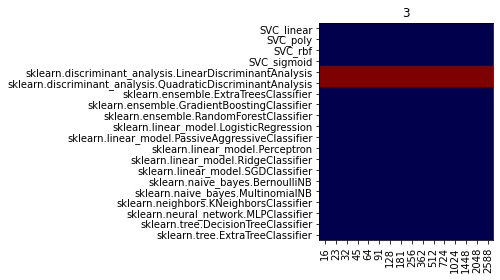

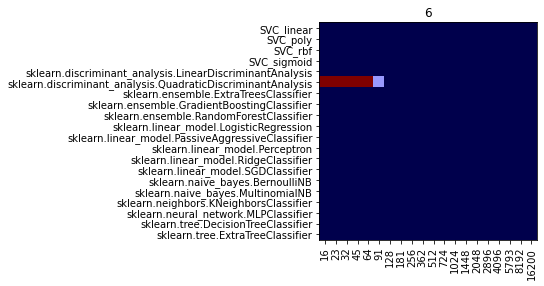

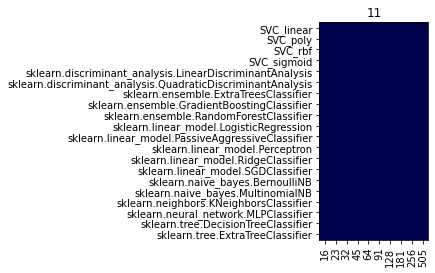

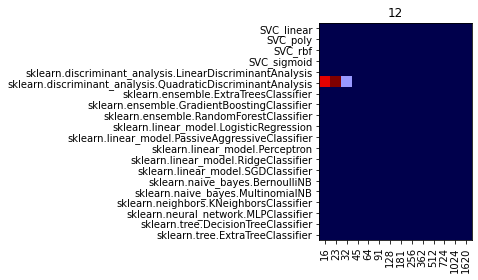

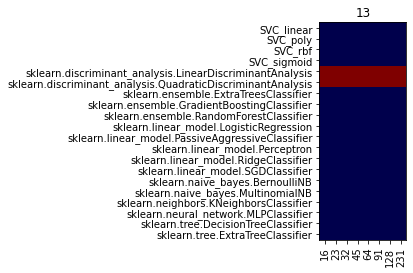

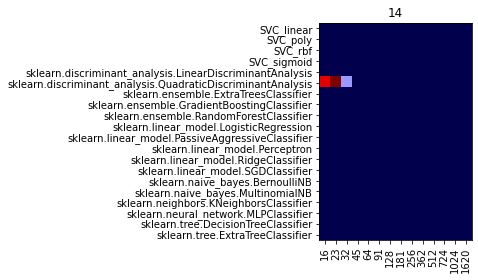

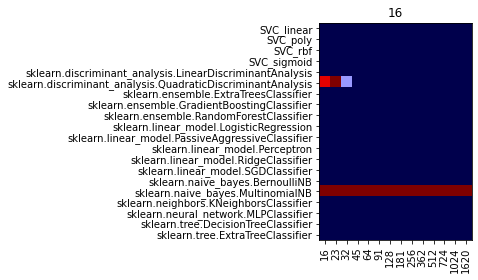

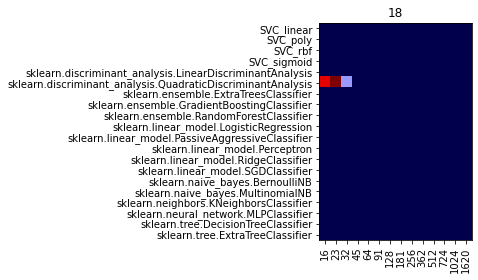

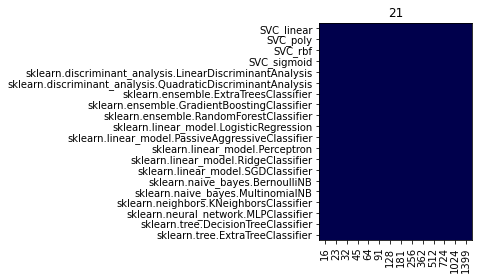

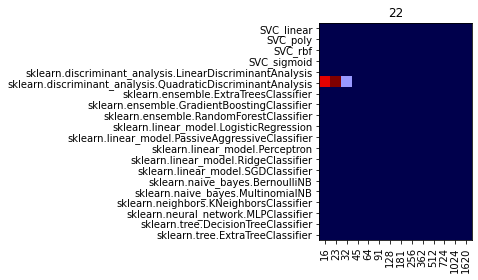

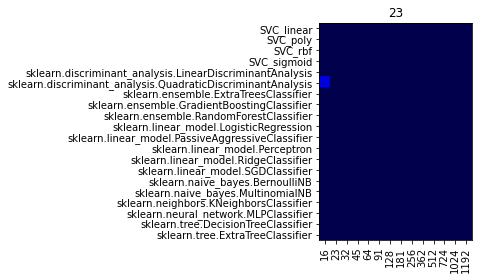

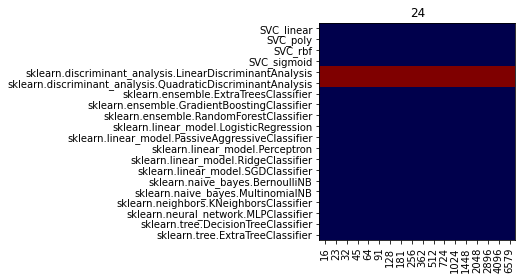

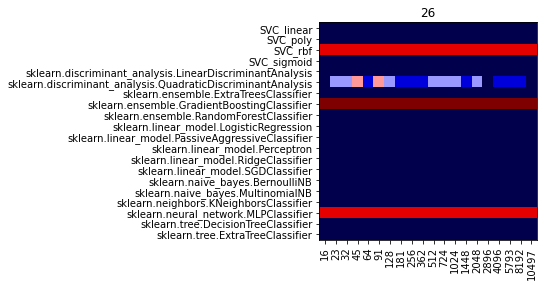

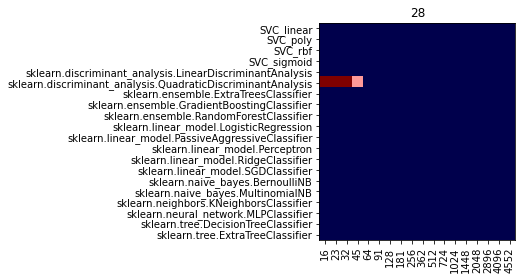

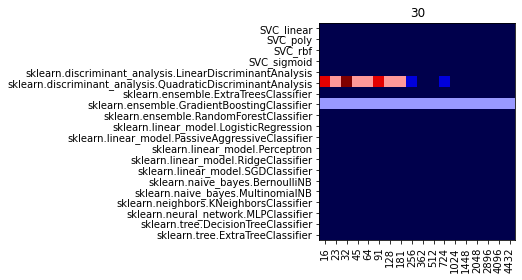

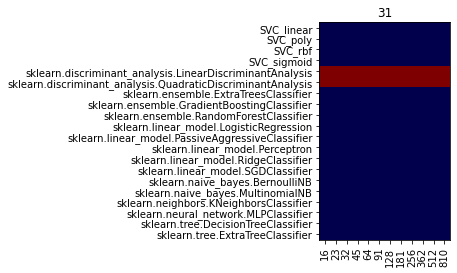

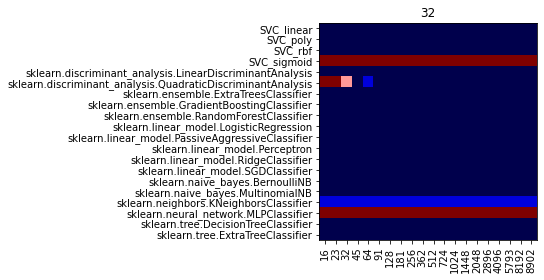

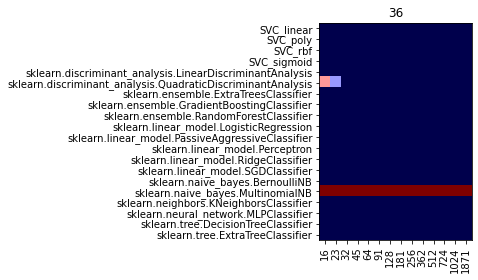

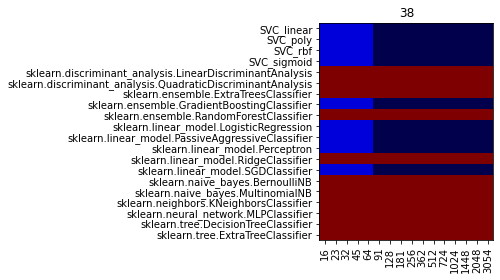

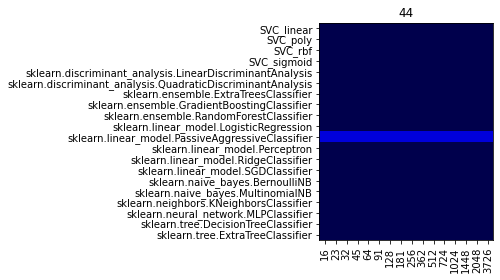

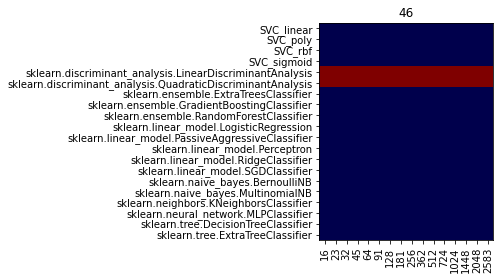

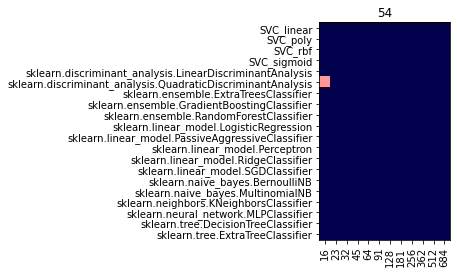

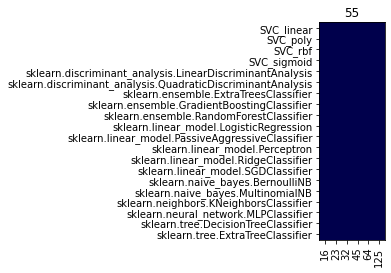

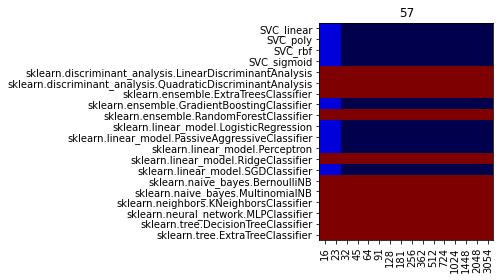

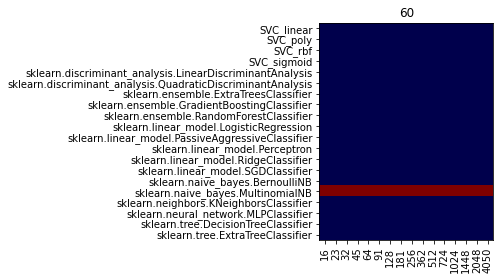

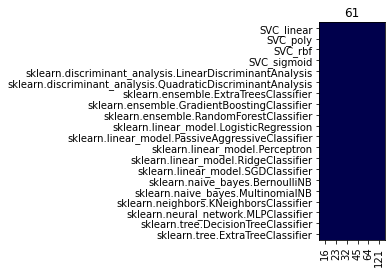

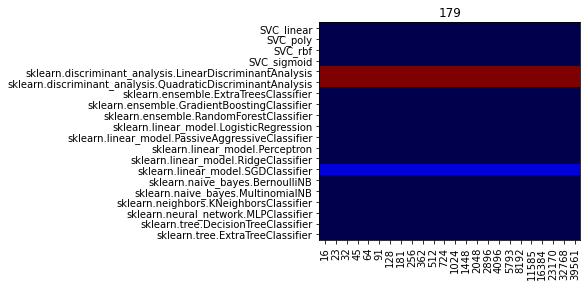

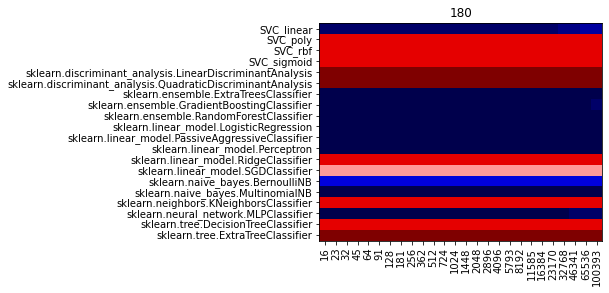

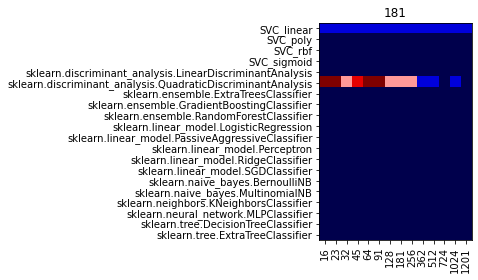

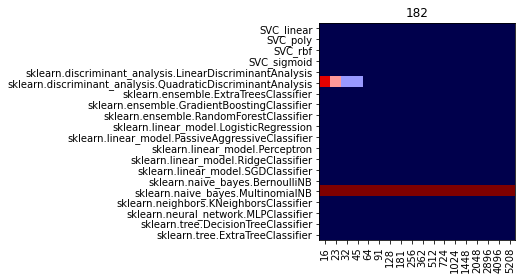

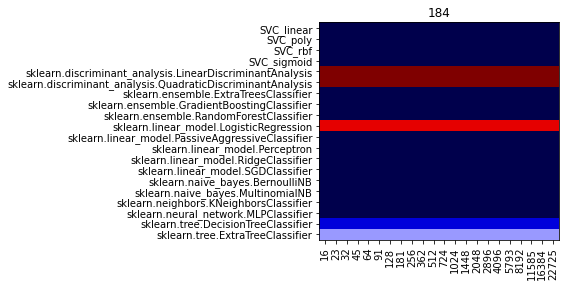

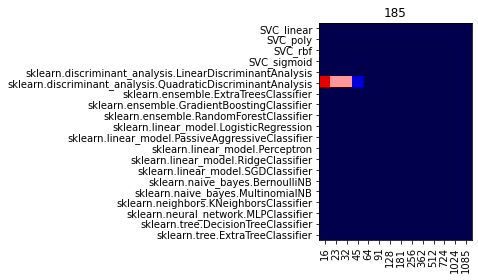

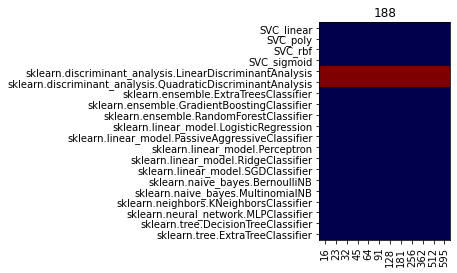

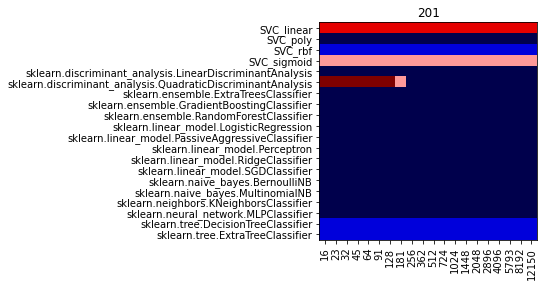

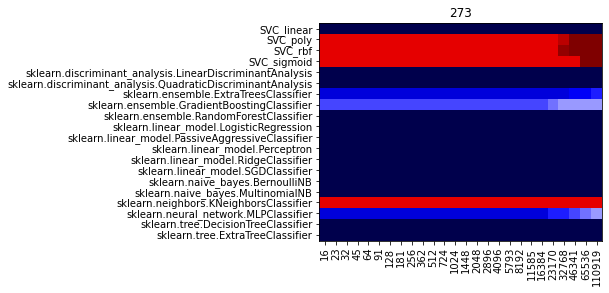

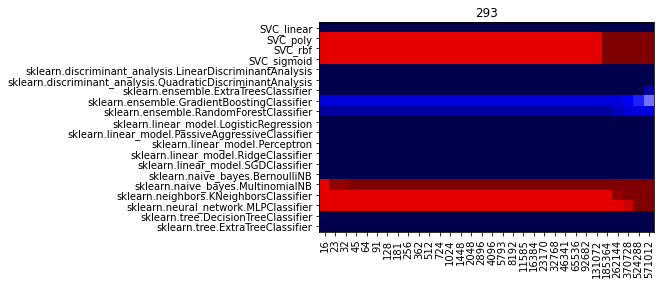

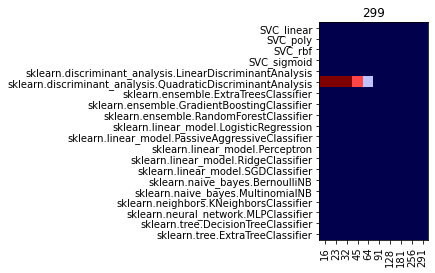

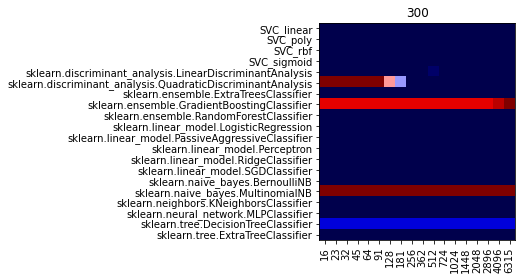

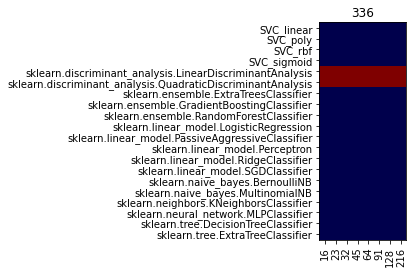

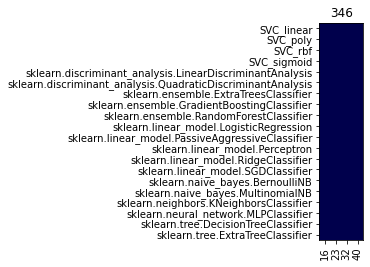

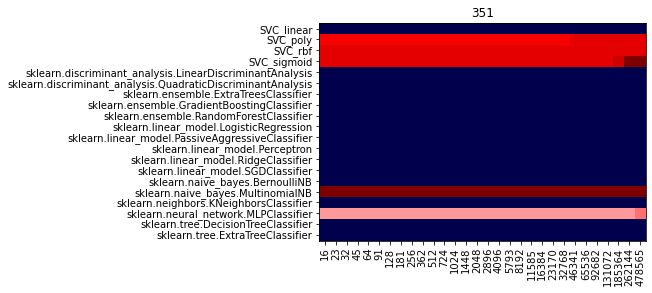

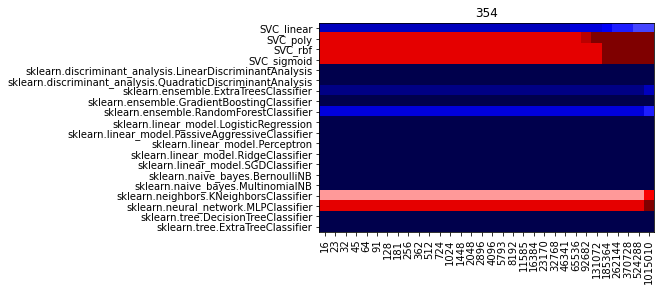

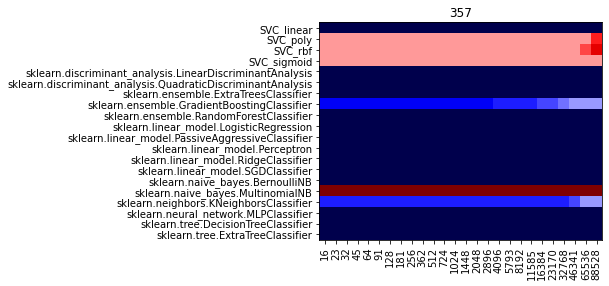

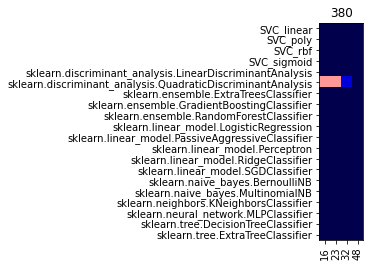

KeyboardInterrupt: 

In [8]:
learners = sorted(pd.unique(df["learner"]))
for openmlid, df_dataset in df.groupby("openmlid"):
    sizes = sorted(pd.unique(df_dataset["size_train"]))
    Z = np.zeros((len(learners), len(sizes)))
    for i, learner in enumerate(learners):
        m1 = df_dataset["learner"] == learner
        for j, size in enumerate(sizes):
            m2 = df_dataset["size_train"] == size
            Z[i,j] = -np.count_nonzero(m1 & m2)
            #if Z[i,j] > -10:
             #   print(f"Missing entries for {learner} on {openmlid} for train size {size}.")
    fig, ax = plt.subplots()
    ax.imshow(Z, cmap="seismic", vmin=-25, vmax=0)
    ax.set_xticks(range(len(sizes)))
    ax.set_xticklabels(sizes, rotation=90)
    ax.set_yticks(range(len(learners)))
    ax.set_yticklabels(learners)
    ax.set_title(openmlid)
    plt.show()

# Visualize Curves

  0%|          | 0/166 [00:00<?, ?it/s]

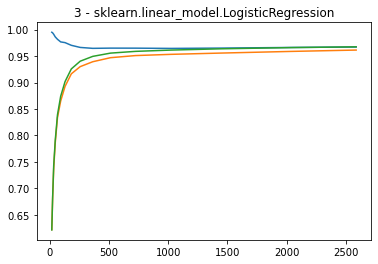

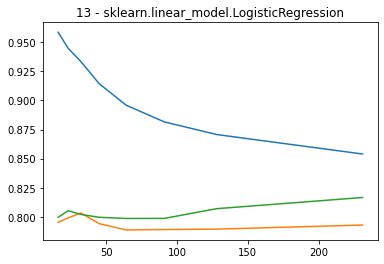

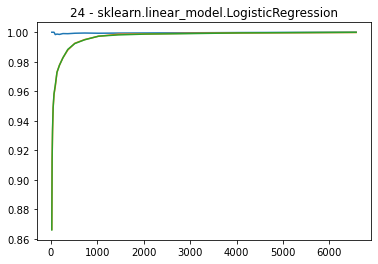

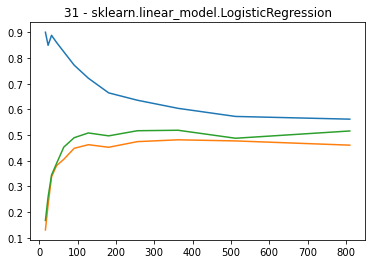

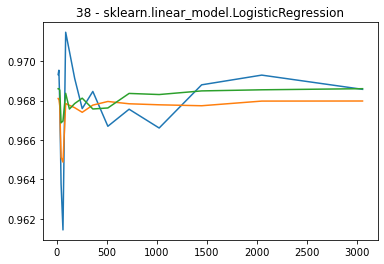

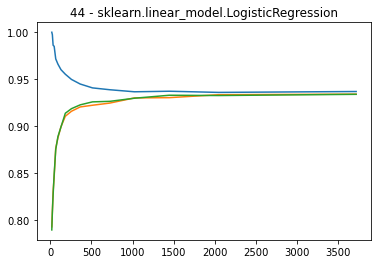

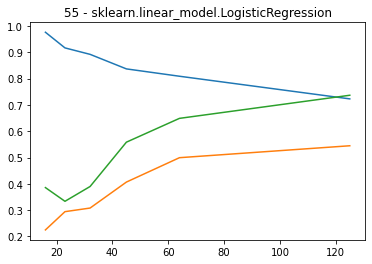

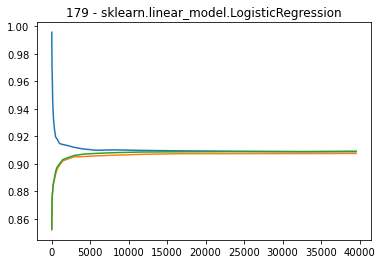

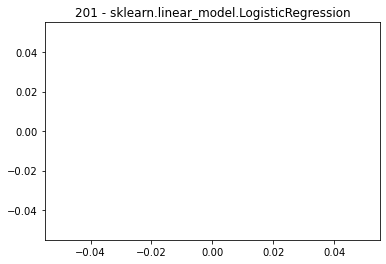

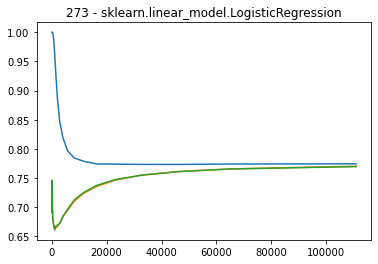

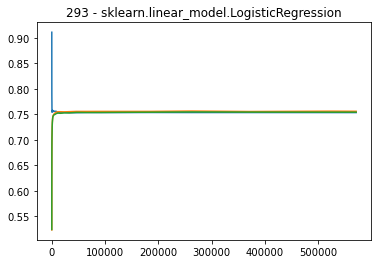

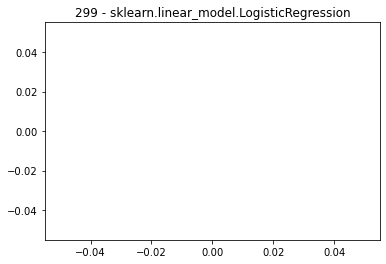

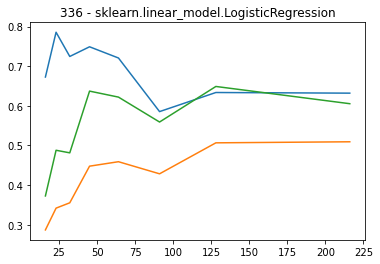

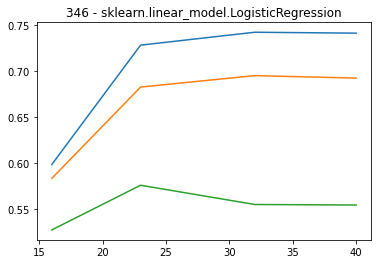

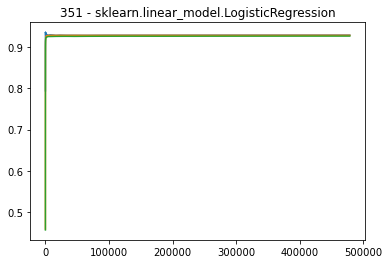

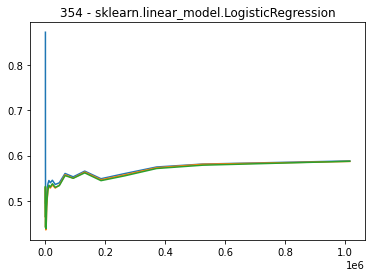

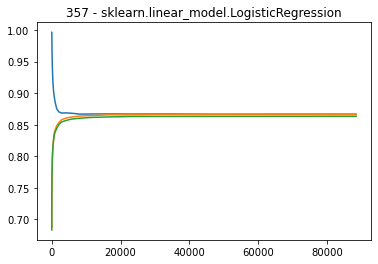

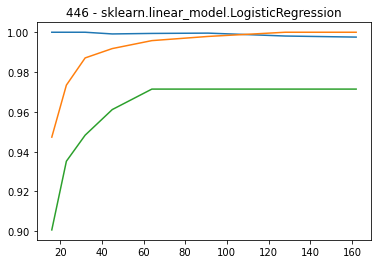

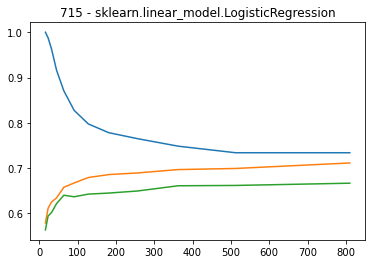

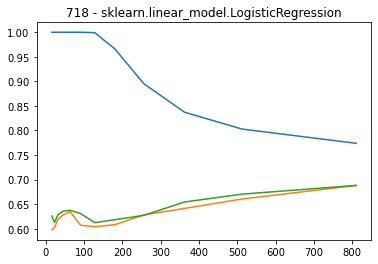

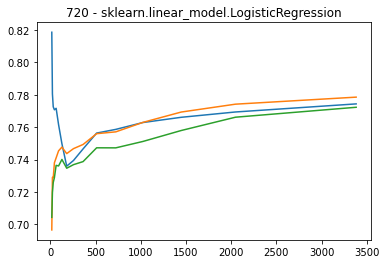

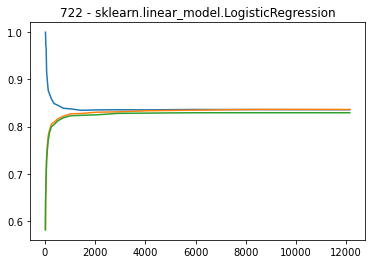

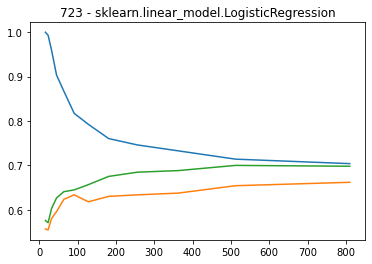

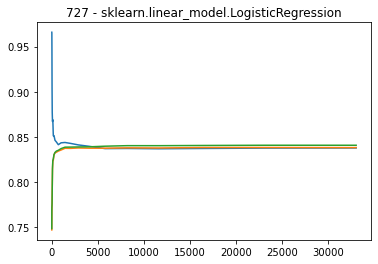

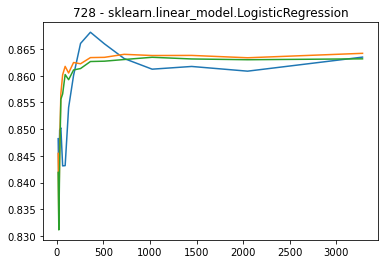

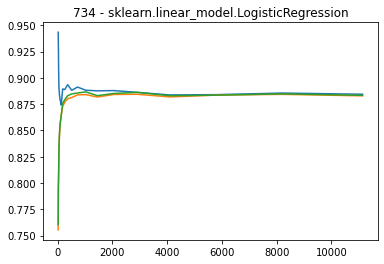

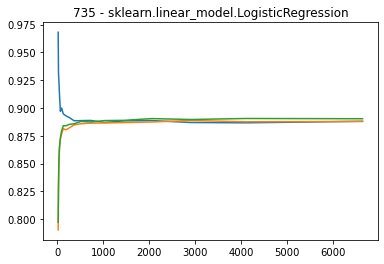

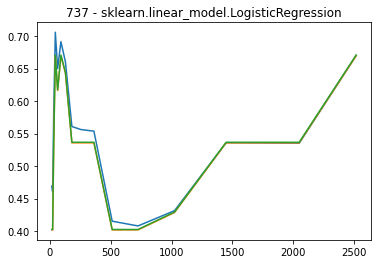

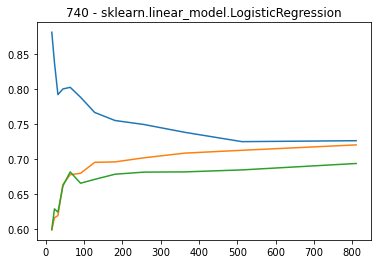

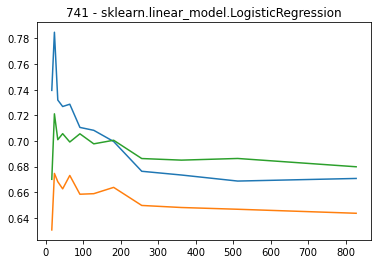

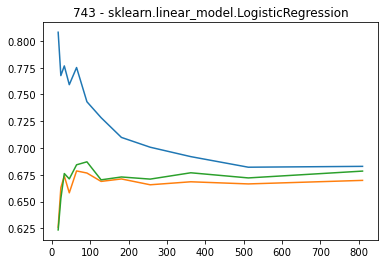

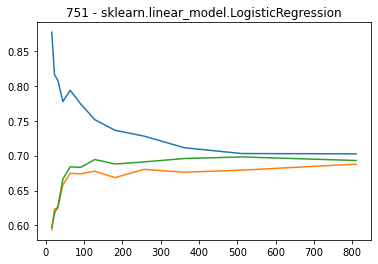

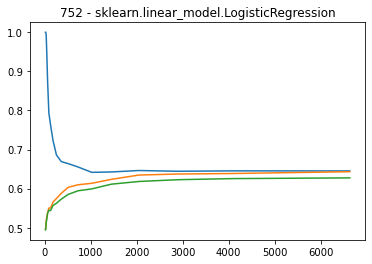

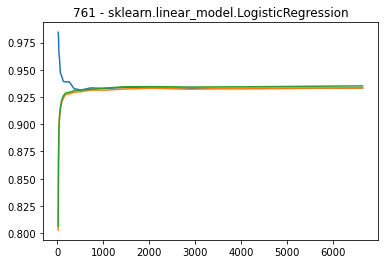

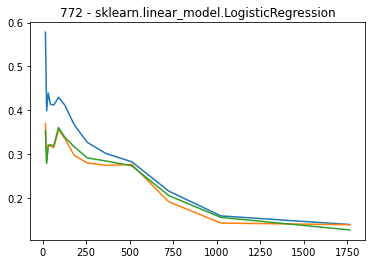

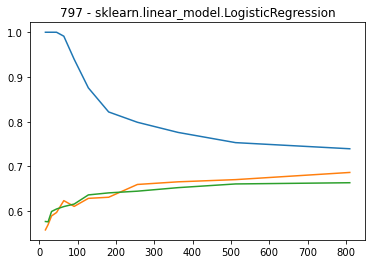

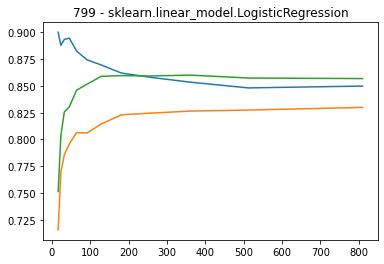

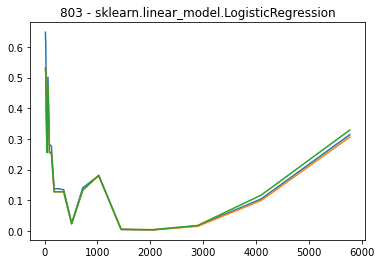

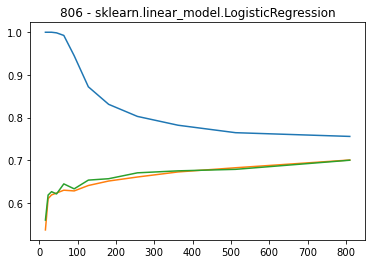

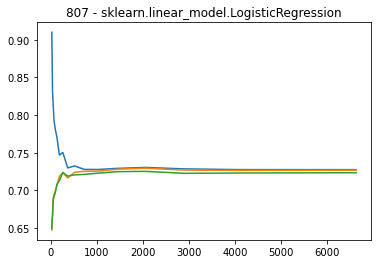

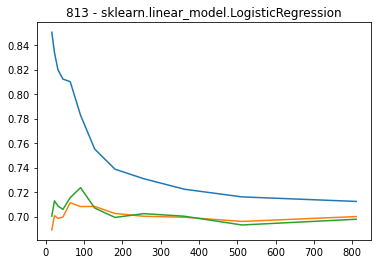

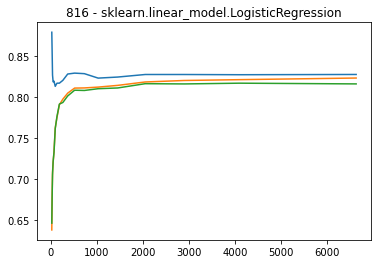

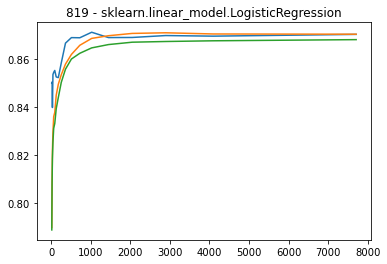

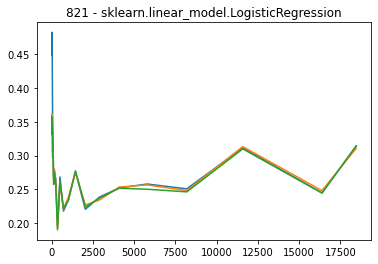

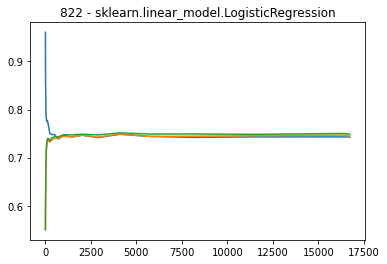

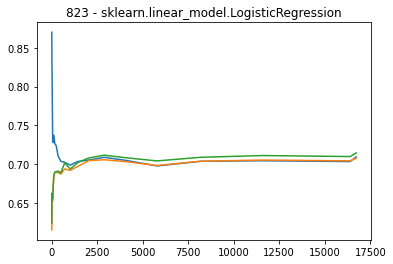

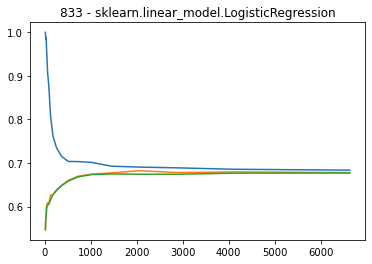

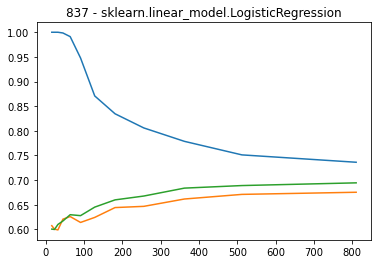

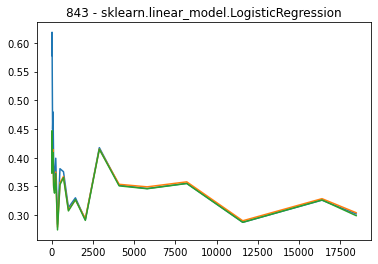

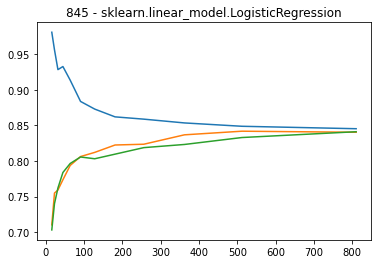

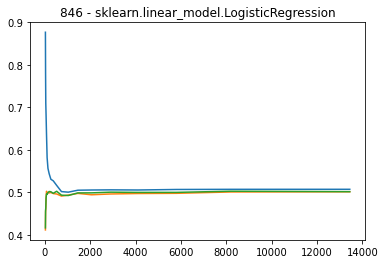

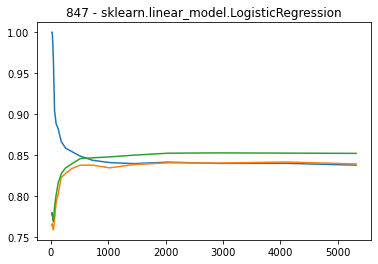

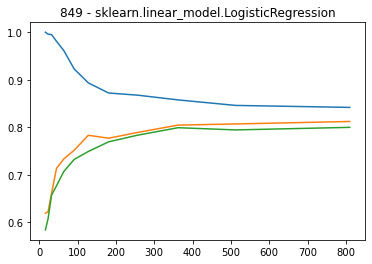

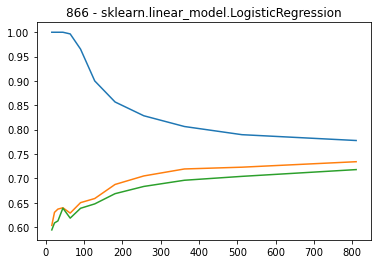

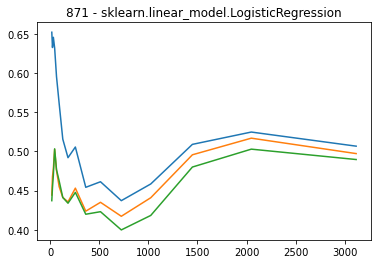

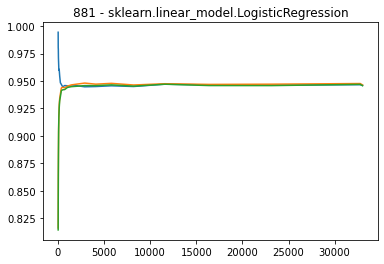

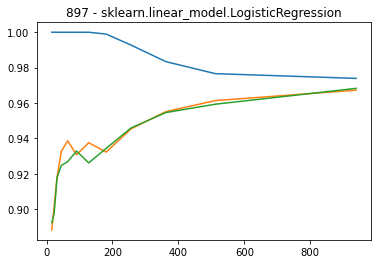

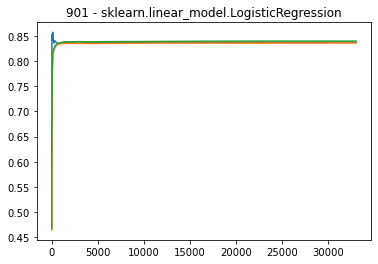

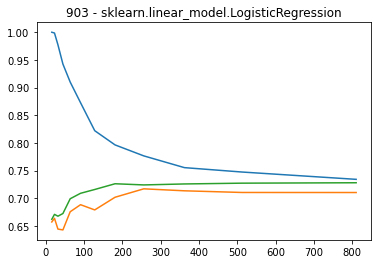

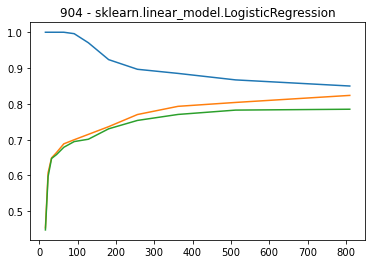

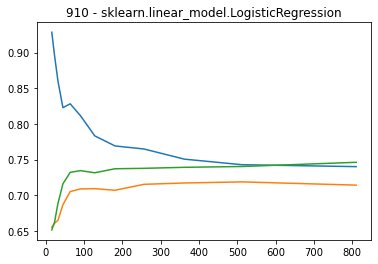

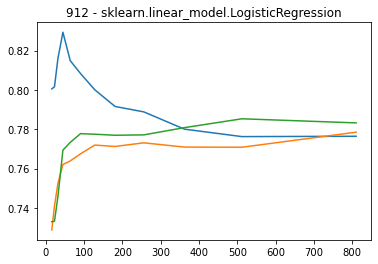

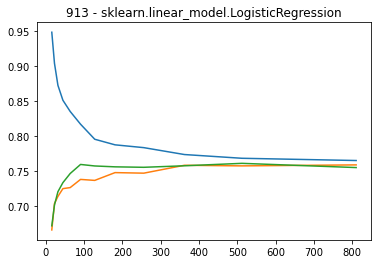

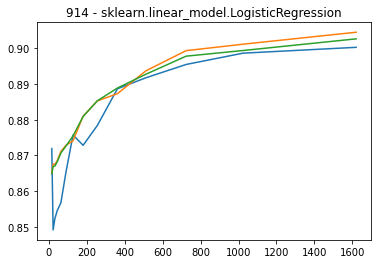

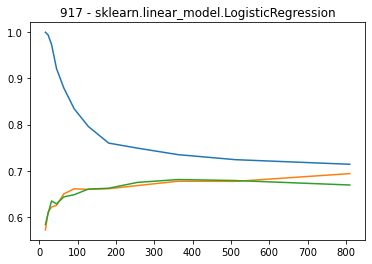

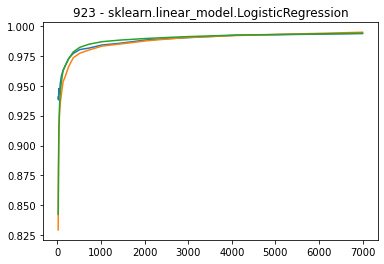

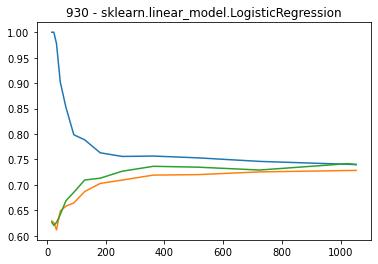

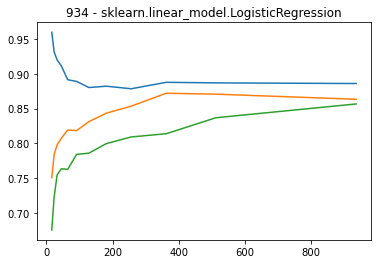

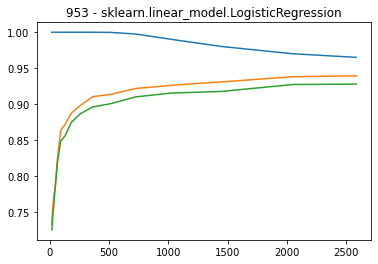

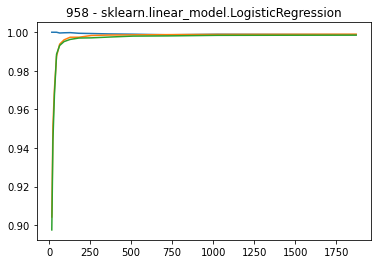

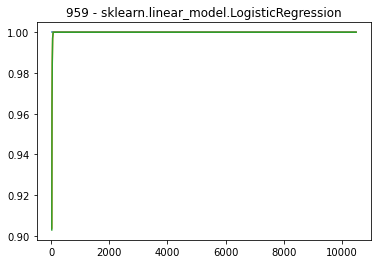

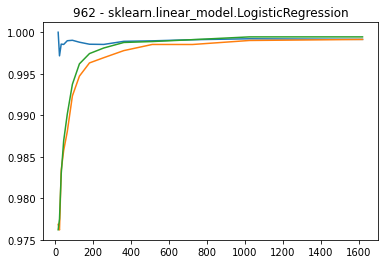

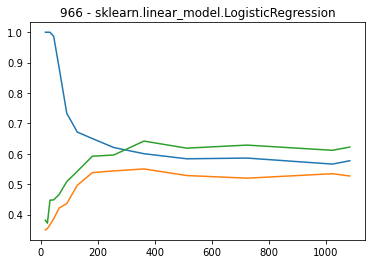

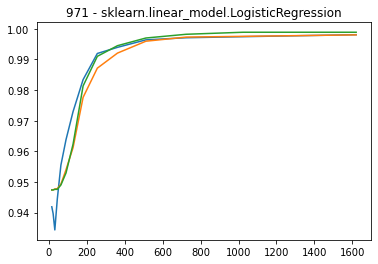

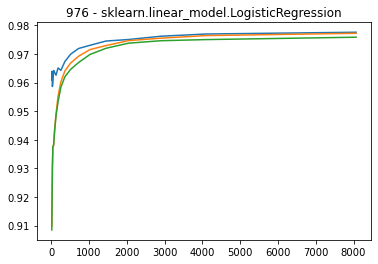

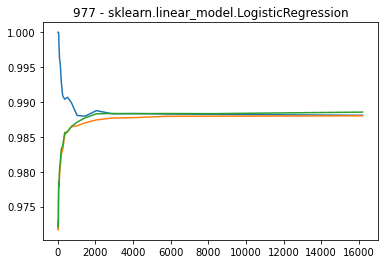

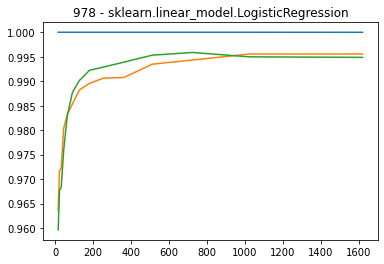

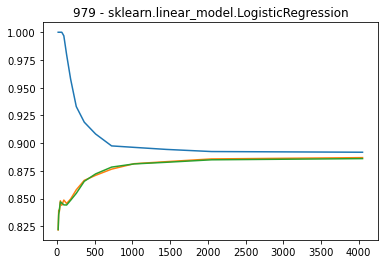

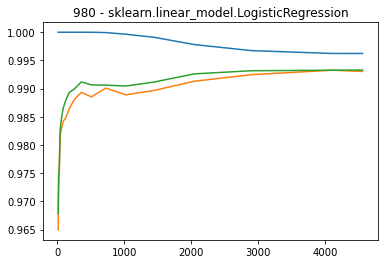

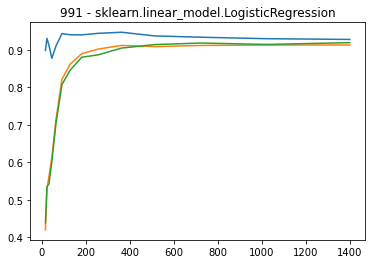

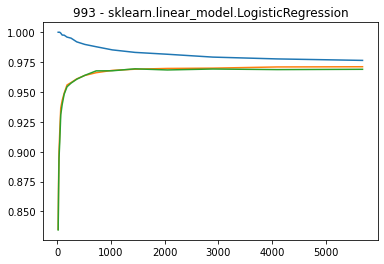

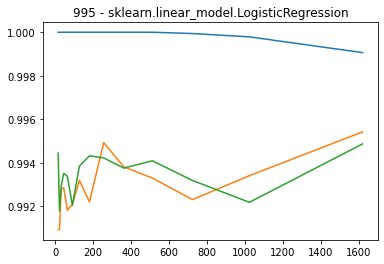

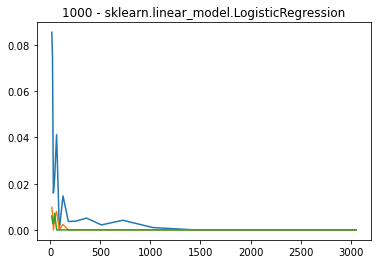

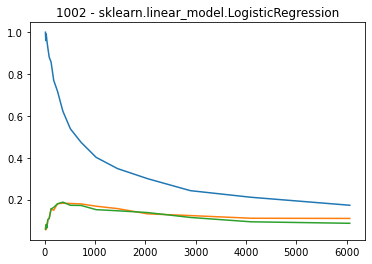

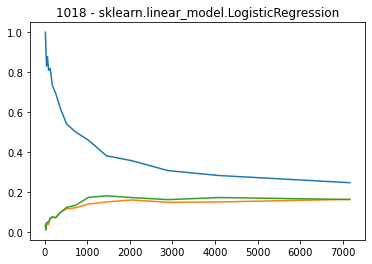

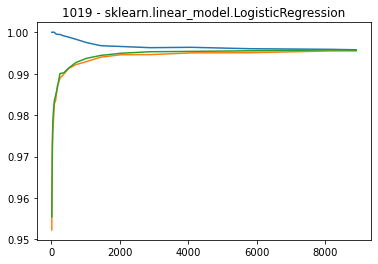

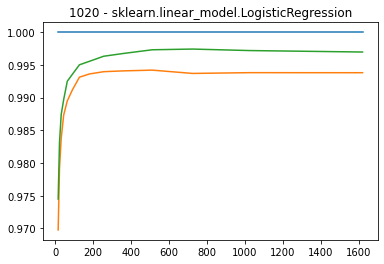

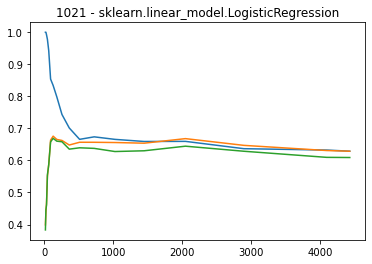

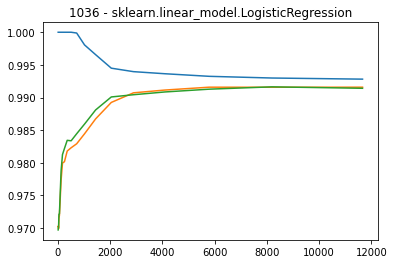

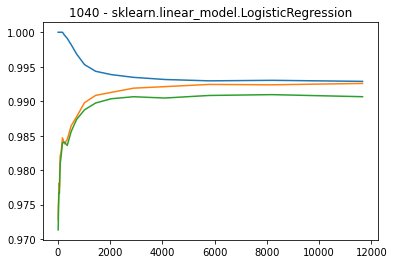

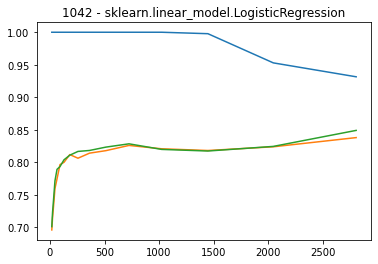

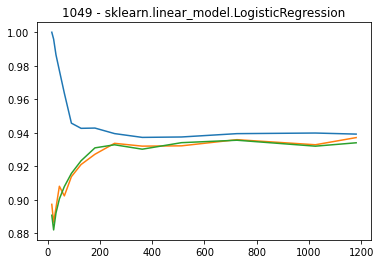

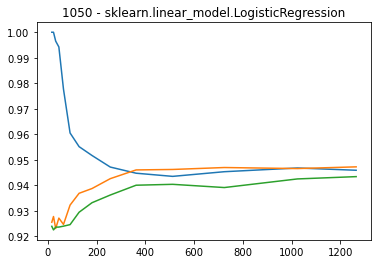

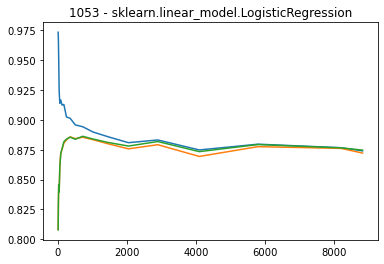

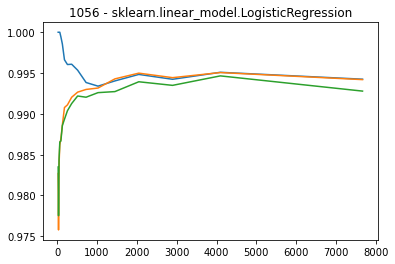

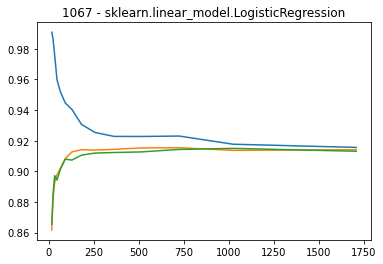

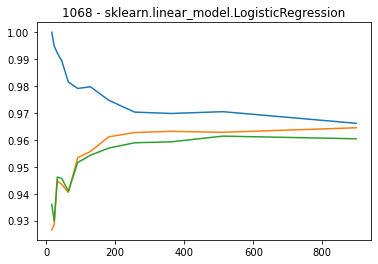

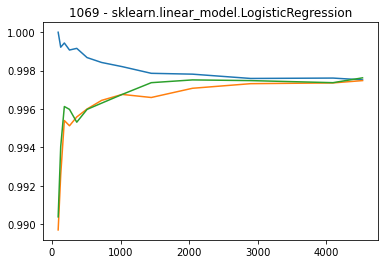

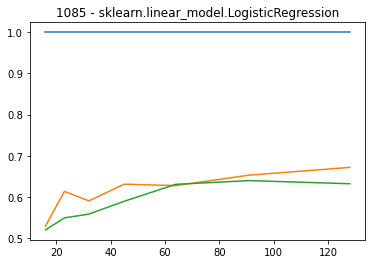

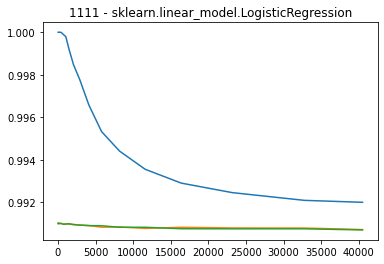

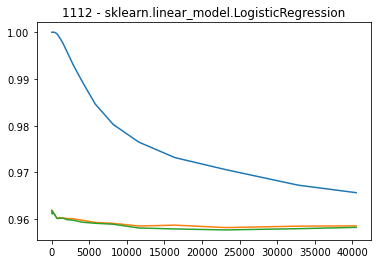

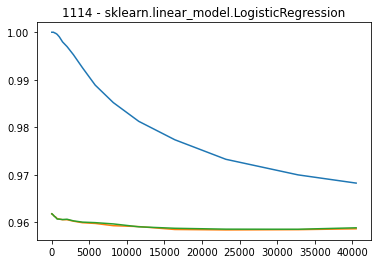

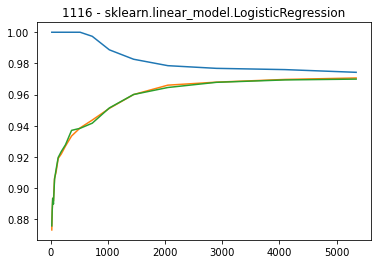

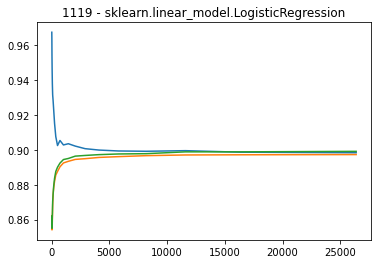

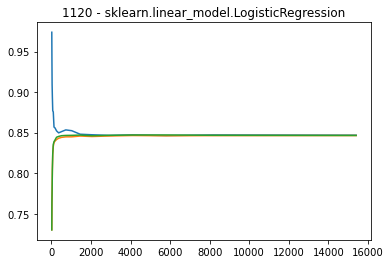

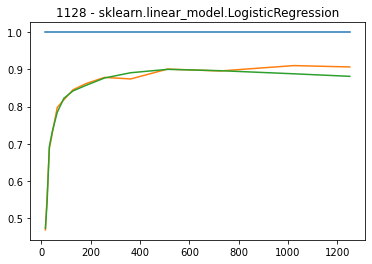

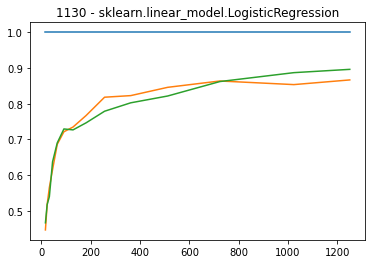

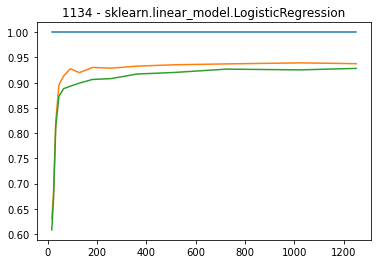

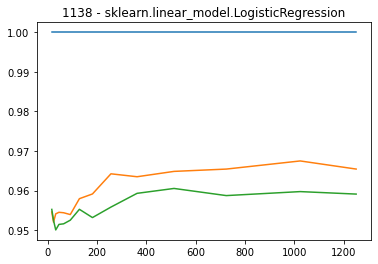

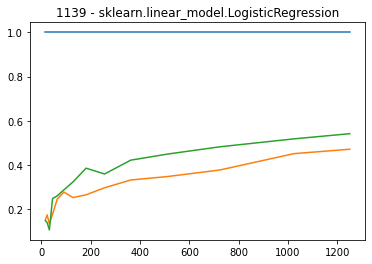

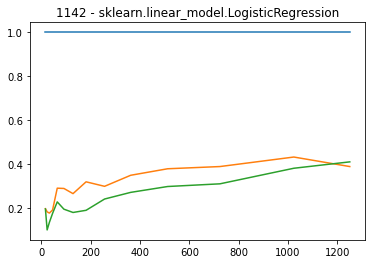

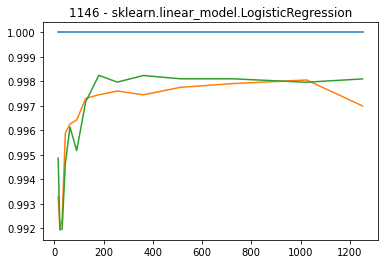

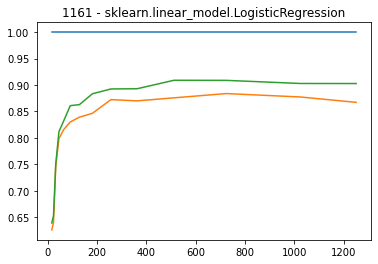

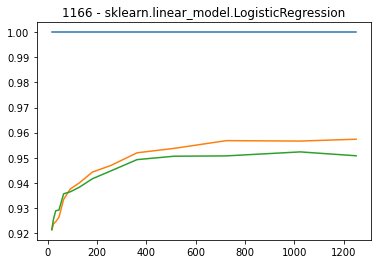

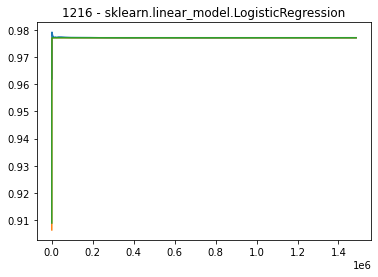

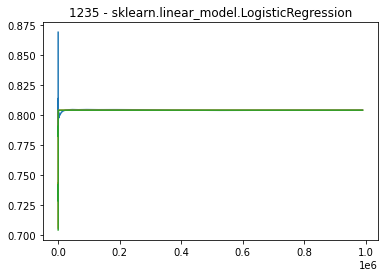

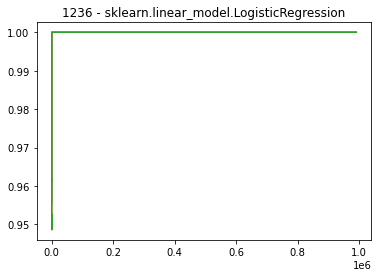

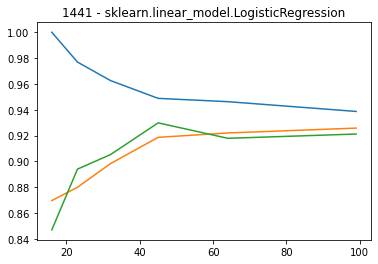

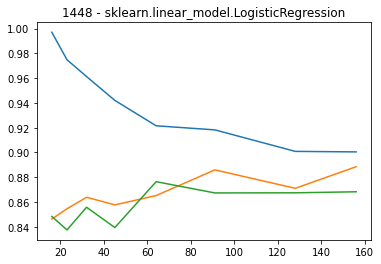

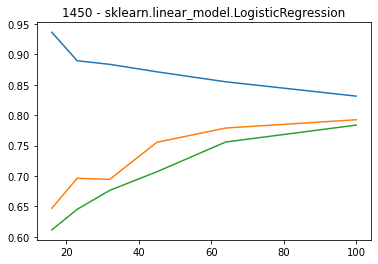

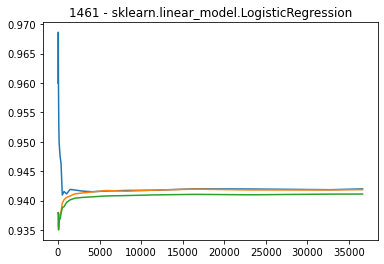

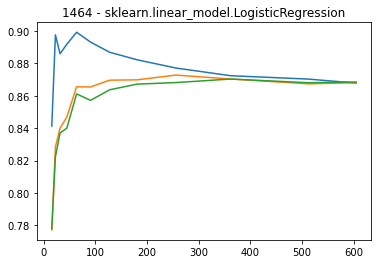

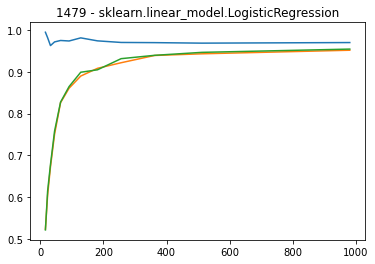

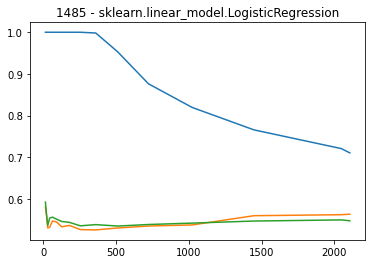

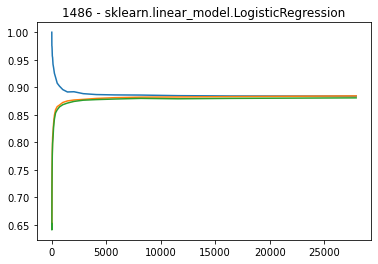

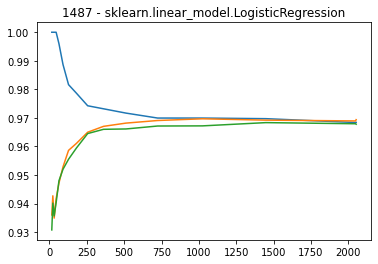

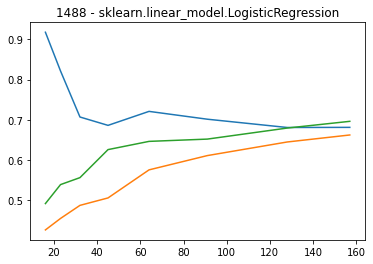

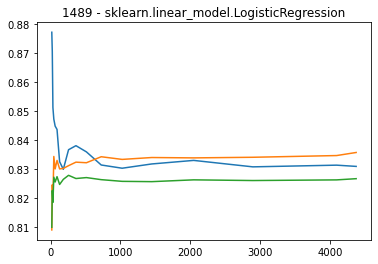

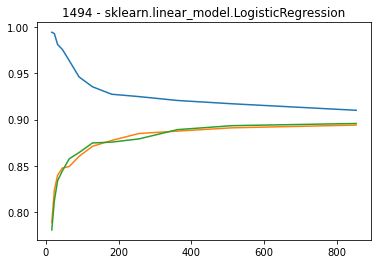

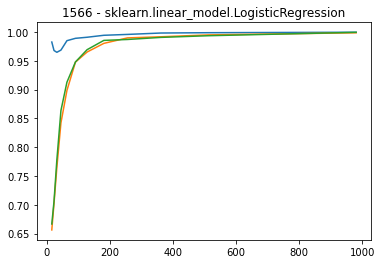

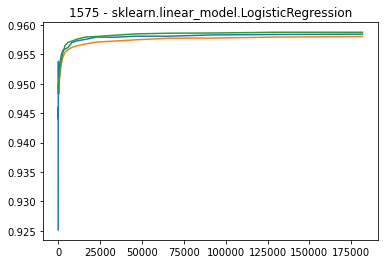

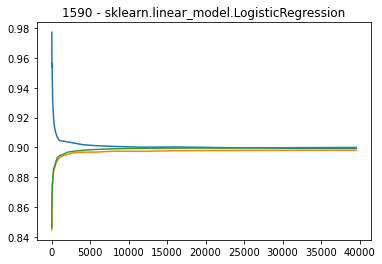

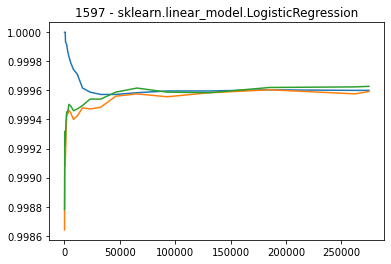

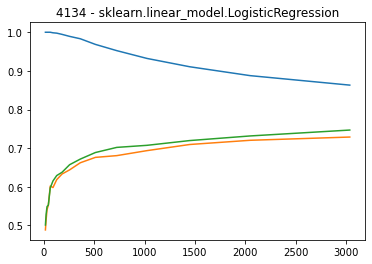

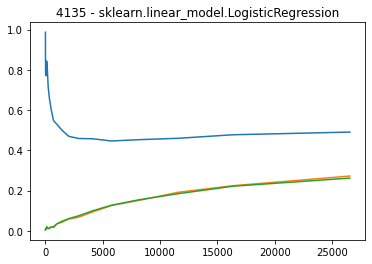

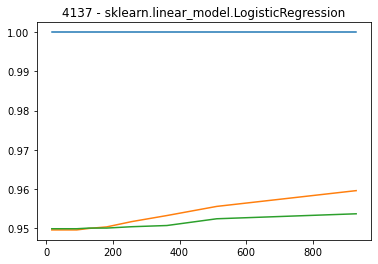

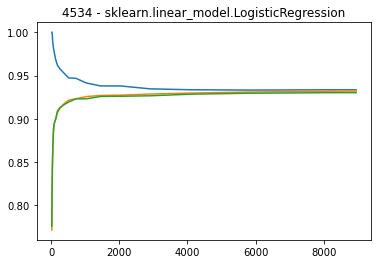

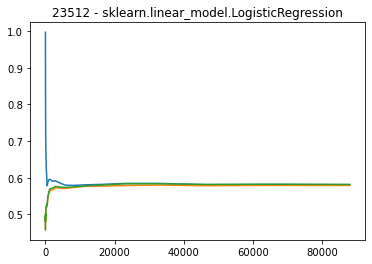

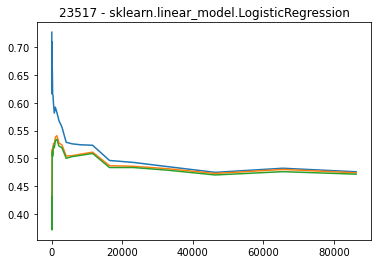

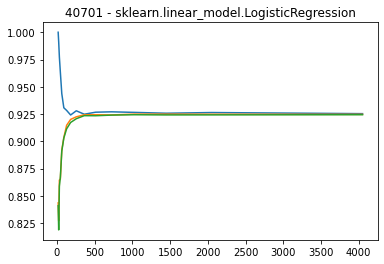

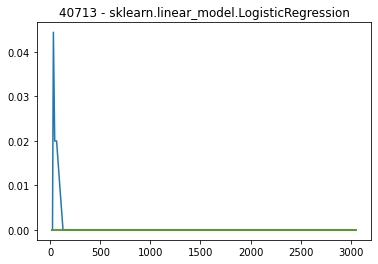

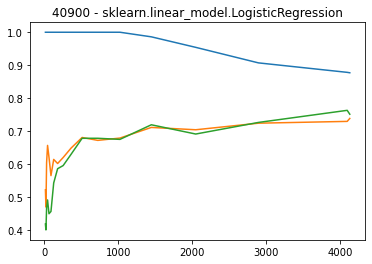

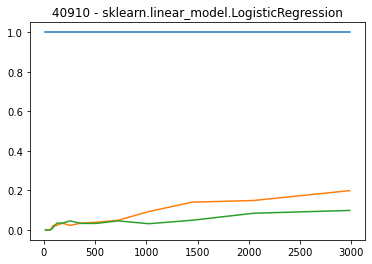

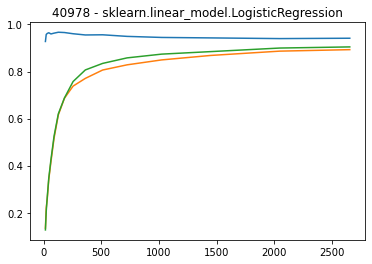

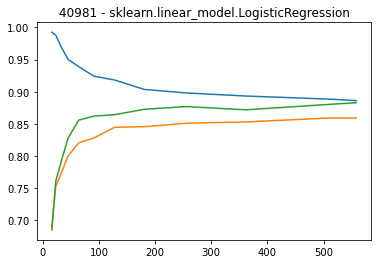

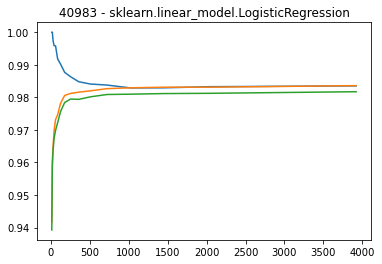

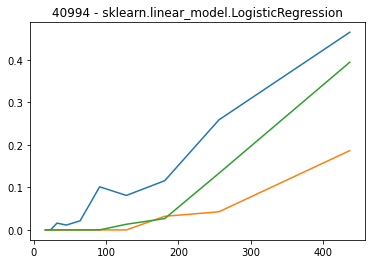

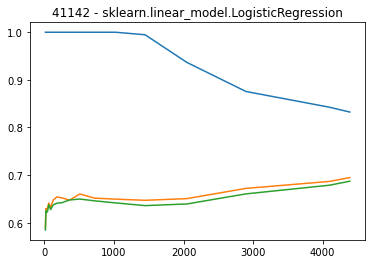

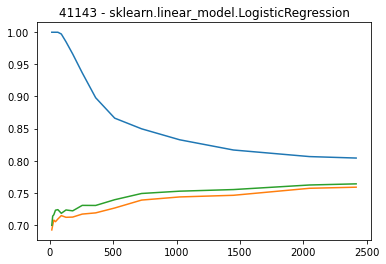

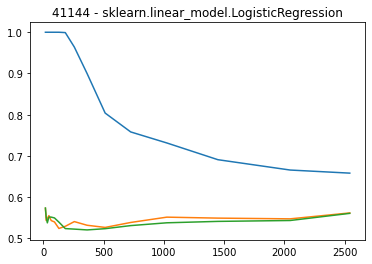

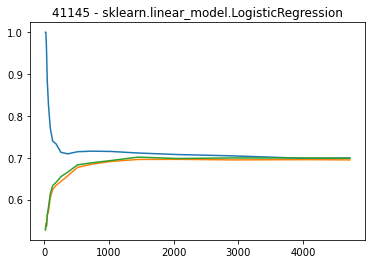

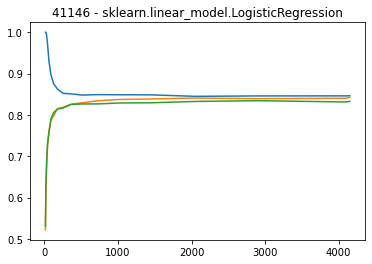

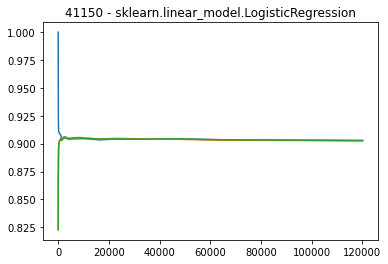

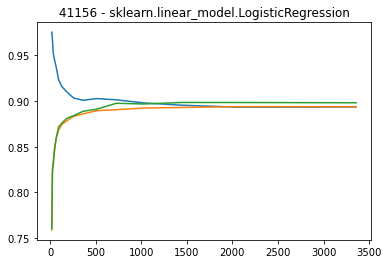

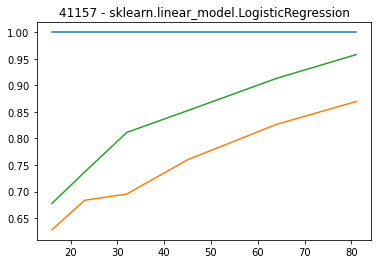

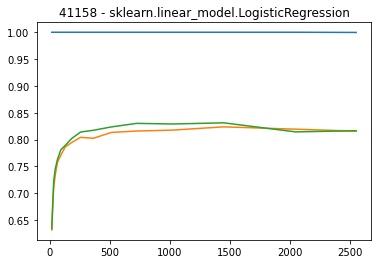

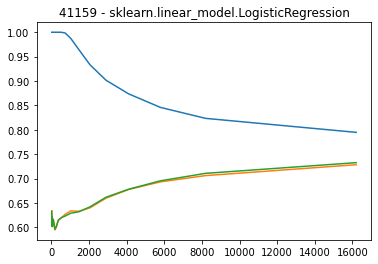

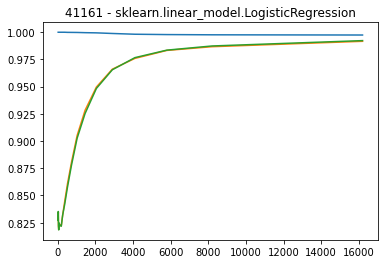

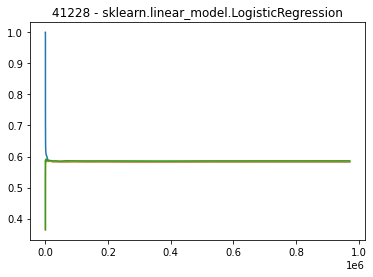

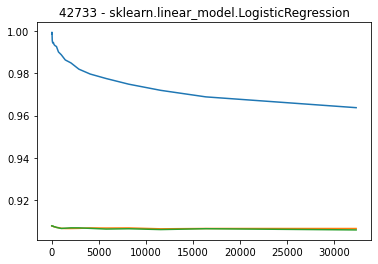

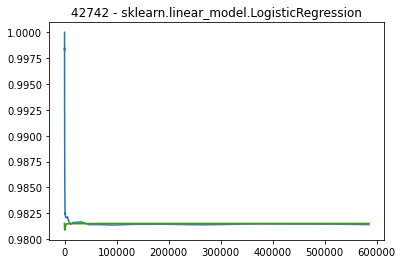

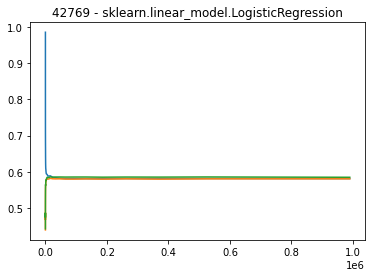

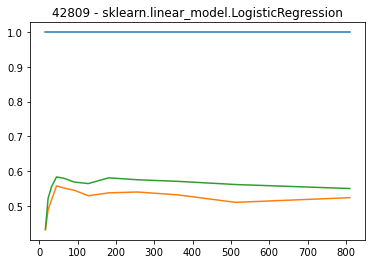

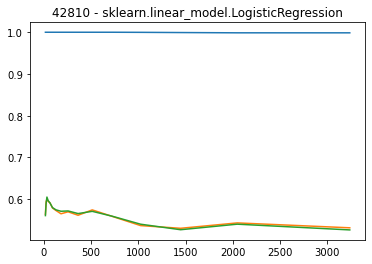

In [13]:
lc_cnt = 0
for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
    for learner, df_learner in df_dataset.groupby("learner"):
    #df_dataset[["size_train", "score_train", "score_valid", "score_test"]]
        sizes = sorted(pd.unique(df_learner["size_train"]))
        
        if learner != "sklearn.linear_model.LogisticRegression":
            continue
        
        c = [df_learner[df_learner["size_train"] == s]["score_train"] for s in sizes]
        lc_cnt += len(c[0])
        
        if True:
            curve_train = [np.mean(df_learner[df_learner["size_train"] == s]["score_train"]) for s in sizes]
            curve_valid = [np.mean(df_learner[df_learner["size_train"] == s]["score_valid"]) for s in sizes]
            curve_test = [np.mean(df_learner[df_learner["size_train"] == s]["score_test"]) for s in sizes]
   
            fig, ax = plt.subplots()
            ax.plot(sizes, curve_train)
            ax.plot(sizes, curve_valid)
            ax.plot(sizes, curve_test)
            ax.set_title(str(openmlid) + " - " + learner)
            plt.show()